In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import decoupler as dc
import sys
import ast
import functools
import neptune

In [2]:
working_dir = '/home/acollin/scPermut/'
fig_dir = '/home/acollin/scPermut/analysis_notebooks/figures/'

In [3]:
import os
os.chdir(working_dir)

In [4]:
sys.path.append(working_dir)

In [5]:
from scpermut.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')


In [6]:
from scpermut.workflow.dataset import load_dataset
from scpermut.tools.utils import ann_subset, check_raw,save_json, load_json, rgb2hex,hex2rgb, load_expe, df_to_dict,dict_to_df,check_dir

/home/acollin/scPermut/analysis_notebooks


In [11]:
def load_run_df(task):
    project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

    runs_table_df = project.fetch_runs_table(query = f'`parameters/task`:string = "{task}"').to_pandas()
    project.stop()

    f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
    runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))
    return runs_table_df


from scpermut.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')

from scpermut.workflow.dataset import load_dataset
from scpermut.tools.utils import ann_subset, check_raw,save_json, load_json, rgb2hex,hex2rgb
from tqdm import trange, tqdm
import warnings

def load_spatial(sysid, adata, working_dir = working_dir):
    res = load_expe(sysid,working_dir = working_dir)
    adata.obs['pred'] = res.obs.pred
    adata.obs['split'] = res.obs.split
    spa = ann_subset(adata, 'modality', 'spatial')
    spa.obsm['X_space'] = spa.obs[['center_x', 'center_y']].values
    sc.pp.normalize_total(spa)
    return spa


In [12]:
dataset_names = {'htap':'htap',
                "ajrccm_by_batch":"ajrccm_by_batch",
                'hlca_par_dataset_harmonized':'hlca_par_dataset_harmonized',
                'hlca_trac_dataset_harmonized':'hlca_trac_dataset_harmonized' ,
                'koenig_2022' : 'celltypist_dataset/koenig_2022/koenig_2022_healthy',
                'tosti_2021' : 'celltypist_dataset/tosti_2021/tosti_2021',
                'yoshida_2021' : 'celltypist_dataset/yoshida_2021/yoshida_2021',
                'tran_2021' : 'celltypist_dataset/tran_2021/tran_2021',
                'dominguez_2022_lymph' : 'celltypist_dataset/dominguez_2022/dominguez_2022_lymph',
                'dominguez_2022_spleen' : 'celltypist_dataset/dominguez_2022/dominguez_2022_spleen',
                'tabula_2022_spleen' : 'celltypist_dataset/tabula_2022/tabula_2022_spleen',
                'litvinukova_2020' : 'celltypist_dataset/litvinukova_2020/litvinukova_2020',
                 'lake_2021': 'celltypist_dataset/lake_2021/lake_2021'
                }

dataset_list = ['htap', 'yoshida_2021', 'hlca_trac_dataset_harmonized',
               'lake_2021', 'dominguez_2022_spleen', 'ajrccm_by_batch',
               'tosti_2021', 'tran_2021', 'litvinukova_2020','koenig_2022',
               'hlca_par_dataset_harmonized', 'dominguez_2022_lymph',
                'tabula_2022_spleen']


diff_dict = {'homo': ['tosti_2021', 'tran_2021', 'yoshida_2021', 'htap', 'ajrccm_by_batch'],
           'assays': ['dominguez_2022_lymph', 'dominguez_2022_spleen', 'tabula_2022_spleen'],
           'suspension': ['koenig_2022', 'litvinukova_2020', 'lake_2021'],
           'datasets': ['hlca_par_dataset_harmonized','hlca_trac_dataset_harmonized']}

aestetic_data_name = {'tosti_2021': 'Tosti 2021',
                      'tran_2021': 'Tran 2021', 
                      'yoshida_2021': 'Yoshida 2021',
                      'htap': 'Mbouamboua 2024', 
                      'ajrccm_by_batch': 'Deprez 2020',
                      'dominguez_2022_lymph': 'Dominguez 2022 - lymph',
                      'dominguez_2022_spleen': 'Dominguez 2022 - spleen',
                      'tabula_2022_spleen': 'Tabula Sapiens - spleen',
                      'koenig_2022': 'Koenig 2022', 
                      'litvinukova_2020': 'Litvinukova 2020', 
                      'lake_2021': 'Lake 2021',
                      'hlca_par_dataset_harmonized': 'HLCA - Parenchyma',
                      'hlca_trac_dataset_harmonized': 'HLCA - Airway'}

aestetic_model_name = {'scPermut' : 'scPermut',
                       'scPermut_default' : 'scPermut - default',
                       'uce' : 'UCE', 
                       'scanvi' : 'scANVI',
                       'harmony_svm' : 'Harmony',
                       'celltypist' : 'Celltypist',
                       'pca_svm' : 'PCA',
                       'scmap_cells' : 'scmap - cells',
                       'scmap_cluster' : 'scmap - cluster'}
aestetic_model_name = {'scPermut' : '1.scMusketeers',
                       'scPermut_default' : '1.scMusketeers',
                        'scanvi' : '2.scANVI',
                       'uce' : '3.UCE', 
                       'harmony_svm' : '4.Harmony',
                       'pca_svm' : '5.PCA',
                        'celltypist' : '6.Celltypist',
                       'scmap_cells' : '7.scmap - cells',
                       'scmap_cluster' : '8.scmap - cluster'}

hp_list=['use_hvg',
'batch_size',
'clas_w',
'dann_w',
'rec_w',
'ae_bottleneck_activation',
         'clas_loss_name',
'size_factor',
'weight_decay',
'learning_rate',
'warmup_epoch',
'dropout',
'layer1',
'layer2',
'bottleneck',
        'training_scheme']



# Loading spatial

In [9]:
runs_table_df = load_run_df('task_4')

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/becavin-lab/benchmark/
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/becavin-lab/benchmark/metadata


In [10]:
dataset_name = 'tenx_hlca_par_cell'
test_fold_selection = load_json(working_dir + 'experiment_script/benchmark/hp_test_folds')
test_obs = load_json(working_dir + 'experiment_script/benchmark/hp_test_obs')

In [13]:
runs_table_df.query(f"dataset_name == '{dataset_name}'")[['sys_id', 'model', 'class_key', 'training_scheme']]

sys_id          model    class_key    training_scheme
0   BEN-11237            uce  ann_level_3                NaN
1   BEN-11236     celltypist  ann_level_3                NaN
4   BEN-11233    harmony_svm  ann_level_3                NaN
7   BEN-11230        pca_knn  ann_level_3                NaN
9   BEN-11228        pca_svm  ann_level_3                NaN
11  BEN-11226  scmap_cluster  ann_level_3                NaN
15  BEN-11222    scmap_cells  ann_level_3                NaN
6   BEN-11231       scPermut  ann_level_3  training_scheme_8
14  BEN-11223         scanvi  ann_level_3                NaN

In [14]:
adata = load_dataset(dataset_name, working_dir + 'data/')

dataset loaded at /home/acollin/scPermut/data//tenx_hlca_par_cell.h5ad
AnnData object with n_obs × n_vars = 613127 × 390
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_g

In [ ]:
tenx_par = adata[adata.obs['tissue_ontology_term_id'] != 'UBERON:0001005']

In [ ]:
ct_none_lv3 = tenx_par.obs['ann_level_3'] == 'None'
tenx_par.obs['ann_level_3'] = tenx_par.obs['ann_level_3'].astype(str)
tenx_par.obs['ann_level_3'][ct_none_lv3] = tenx_par.obs['ann_level_2'][ct_none_lv3] # Replace few None with lv2, here only Smooth Muscle

ct_none_lv4 = tenx_par.obs['ann_level_4'] == 'None'
tenx_par.obs['ann_level_4'] = tenx_par.obs['ann_level_4'].astype(str)
tenx_par.obs['ann_level_4'][ct_none_lv4] = tenx_par.obs['ann_level_3'][ct_none_lv4] # Replace few None with lv2, here only Smooth Muscle

tenx_par.write('/home/acollin/scPermut/data/tenx_hlca_par.h5ad')

# Analysis

In [ ]:
os.getcwd()

In [ ]:
sysid = 'BEN-11040'

sysid = 'BEN-11077'

res = load_expe(sysid,working_dir = working_dir)


In [ ]:
adata.obs['pred'] = res.obs.pred
adata.obs['split'] = res.obs.split

In [ ]:
spa = ann_subset(adata, 'modality', 'spatial')
spa.obsm['X_space'] = spa.obs[['center_x', 'center_y']].values

In [ ]:
with plt.rc_context({"figure.figsize": (10,10), "figure.dpi": (300)}):
    sc.pl.embedding(spa, 'X_space', color = 'pred', size = 5)

In [ ]:
with plt.rc_context({"figure.figsize": (10,10), "figure.dpi": (300)}):
    sc.pl.embedding(spa, 'X_space', color = 'pred', size = 5)

In [ ]:
with plt.rc_context({"figure.figsize": (10,10), "figure.dpi": (300)}):
    sc.pl.embedding(spa, 'X_space', color = 'pred', size = 5)

In [ ]:
with plt.rc_context({"figure.figsize": (10,10), "figure.dpi": (300)}):
    sc.pl.embedding(spa, 'X_space', color = 'pred', size = 5)

In [ ]:
sc.pl.umap(res, color = 'pred', size = 0.5)
sc.pl.umap(res, color = 'split', size = 0.5)

In [ ]:
filter_ct= spa.obs['pred'].value_counts()[spa.obs['pred'].value_counts() <= 1].index

In [ ]:
filter_ct= spa.obs['pred'].value_counts()[spa.obs['pred'].value_counts() <= 1].index
spa = spa[~spa.obs['pred'].isin(filter_ct)]
sc.tl.rank_genes_groups(spa, groupby = 'pred', method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(spa, groupby = 'pred',n_genes = 5)

In [ ]:
filter_ct= spa.obs['pred'].value_counts()[spa.obs['pred'].value_counts() <= 1].index
spa = spa[~spa.obs['pred'].isin(filter_ct)]
sc.tl.rank_genes_groups(spa, groupby = 'pred', method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(spa, groupby = 'pred',n_genes = 5)

In [ ]:
hlca = adata[adata.obs['split'].isin(['train', 'val'])]

In [ ]:
sc.pl.umap(hlca, color = 'ann_level_3', size = 20)

In [ ]:

sc.pl.dotplot(hlca,  var_names = ['SFTA2', 'AGER', 'ETV5','SFTPD'], groupby = 'ann_level_3')

## Marker lists

In [ ]:
markers = pd.read_csv('/home/acollin/scPermut/data/Marker_genes_LCA.csv', sep = ';')

In [ ]:
mask = ~markers.isin(spa.var_names)

In [ ]:
mask_markers = markers.mask(mask)
marker_dict = {ct : list(mask_markers[ct].dropna()) for ct in mask_markers.columns}

In [ ]:
ct_mapping = adata.obs.loc[:,['ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_finest_level']].drop_duplicates()

In [ ]:
finest_to_three = {k:v for k,v in zip(ct_mapping['ann_finest_level'],ct_mapping['ann_level_3'])}
finest_to_four = {k:v for k,v in zip(ct_mapping['ann_finest_level'],ct_mapping['ann_level_4'])}

In [ ]:
lv3_markers = {k:[] for k in ct_mapping['ann_level_3'].unique()}
lv4_markers = {k:[] for k in ct_mapping['ann_level_4'].unique()}

In [ ]:
for ct in marker_dict.keys(): 
    if ct in finest_to_three.keys():
        lv3_markers[finest_to_three[ct]] += marker_dict[ct]

for ct in marker_dict.keys(): 
    if ct in finest_to_four.keys():
        lv4_markers[finest_to_four[ct]] += marker_dict[ct]


lv3_markers = {k: list(set(v)) for k,v in lv3_markers.items()}
lv4_markers = {k: list(set(v)) for k,v in lv4_markers.items()}

In [ ]:
lv3_markers['AT2'] += ['SFTPD', 'ETV5']
lv3_markers['Multiciliated lineage'] = ['FOXJ1']
lv3_markers['Macrophages'] += ['MARCO']
lv3_markers['AT2'] = [i for i in lv3_markers['AT2'] if i != 'TOP2A']
lv3_markers['Fibroblasts'] += ['SVEP1', 'FGFR4']
lv3_markers['EC venous'] += ['SELP']

lv4_markers['AT2'] += ['SFTPD', 'ETV5']
lv4_markers['Interstitial macrophages'] += ['CXCL10']
lv4_markers['Multiciliated'] = ['FOXJ1']
lv4_markers['EC venous pulmonary'] += ['SELP']

lv3_markers = {k: list(set(v)) for k,v in lv3_markers.items()}
lv4_markers = {k: list(set(v)) for k,v in lv4_markers.items()}

In [ ]:
marker_net = dict_to_df(lv3_markers)
marker_net =marker_net.rename(columns = {"keys" : 'source', 'values': 'target'})
marker_net.to_csv('/home/acollin/scPermut/data/markers_lv3.csv')
marker_net = dict_to_df(lv4_markers)
marker_net =marker_net.rename(columns = {"keys" : 'source', 'values': 'target'})
marker_net.to_csv('/home/acollin/scPermut/data/markers_lv4.csv')

## Figure 6 -  aucell heatmaps

### lv 3 

In [ ]:
lv3_id = runs_table_df.query(f"dataset_name == '{dataset_name}'").query('class_key == "ann_level_3"')[['sys_id', 'model', 'training_scheme']]

In [ ]:
marker_net = pd.read_csv('/home/acollin/scPermut/data/markers_lv3.csv')

In [ ]:
celltype_order = ['AT1','AT2', 'EC capillary' ,'Fibroblasts', 'Smooth muscle',
                   'EC arterial', 'EC venous', 'Lymphatic EC mature', 
                  'Basal', 'Secretory','Multiciliated lineage',
               'Macrophages','Monocytes', 'Mast cells', 'B cell lineage', 'Dendritic cells', 'T cell lineage',              
               'Innate lymphoid cell NK']

In [ ]:
# From scratch (recomputing aucell)

sc.set_figure_params(dpi=100, figsize=(12,10), scanpy=False, 
                     frameon=False, vector_friendly=False, color_map=None, facecolor=None, transparent=True, ipython_format='png2x')

aucell_dict = {}
for sysid, model, training_scheme in zip(lv3_id['sys_id'], lv3_id['model'],lv3_id['training_scheme']):
    if model != 'uce':
        if model != 'scanvi':
            if training_scheme != 'training_scheme_20':
                print(sysid, model, str(training_scheme))
                save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/aucell_heatmap/lv3_transfer/'
                check_dir(save_path)
                spa = load_spatial(sysid, adata)
                dc.run_aucell(spa, marker_net, min_n = 0)
            
                aucell = spa.obsm['aucell_estimate']
                aucell['pred'] = spa.obs['pred']
                agg_aucell = aucell.groupby('pred').agg('mean')
                if 'scmap' in model : 
                    ct_order = celltype_order + ['Unassigned']
                ct_order = [i for i in celltype_order if i in agg_aucell.index]
                agg_aucell = agg_aucell.loc[ct_order, ct_order]
                for vm in [0.5,0.8]:
                    plt.figure()
                    sns.heatmap(agg_aucell, cmap = 'Blues',vmax = vm)
                    plt.title(model + ' lv3 transfer')
                    plt.tight_layout()
                    # training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
                    plt.savefig(save_path + model + '_' + 
                                str(training_scheme) + 'vmax_' + str(vm) + '.png', transparent=False)
                plt.figure()
                agg_aucell_norm = pd.DataFrame(np.array(agg_aucell) / np.array(agg_aucell).sum(axis = 1, keepdims=True), index = agg_aucell.index, columns = agg_aucell.columns)
                sns.heatmap(agg_aucell_norm, cmap = 'Blues')
                plt.title(model + ' lv3 transfer norm ')
                plt.tight_layout()
                plt.savefig(save_path + model + '_' + 
                                str(training_scheme) + 'norm' + '.png', transparent=False)
                aucell_dict[model + '_' + str(training_scheme)] = agg_aucell
                agg_aucell.to_csv(save_path + model + '_' + 
                            str(training_scheme) + '.csv')

In [87]:
save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/aucell_heatmap/lv3_transfer/'
p_list = {i : save_path + i for i in os.listdir(save_path) if i.endswith('.csv')}

aucell_dict = {mod.rstrip('.csv') : pd.read_csv(path, index_col = 0) for mod, path in p_list.items()}

/tmp/ipykernel_19846/2761264483.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


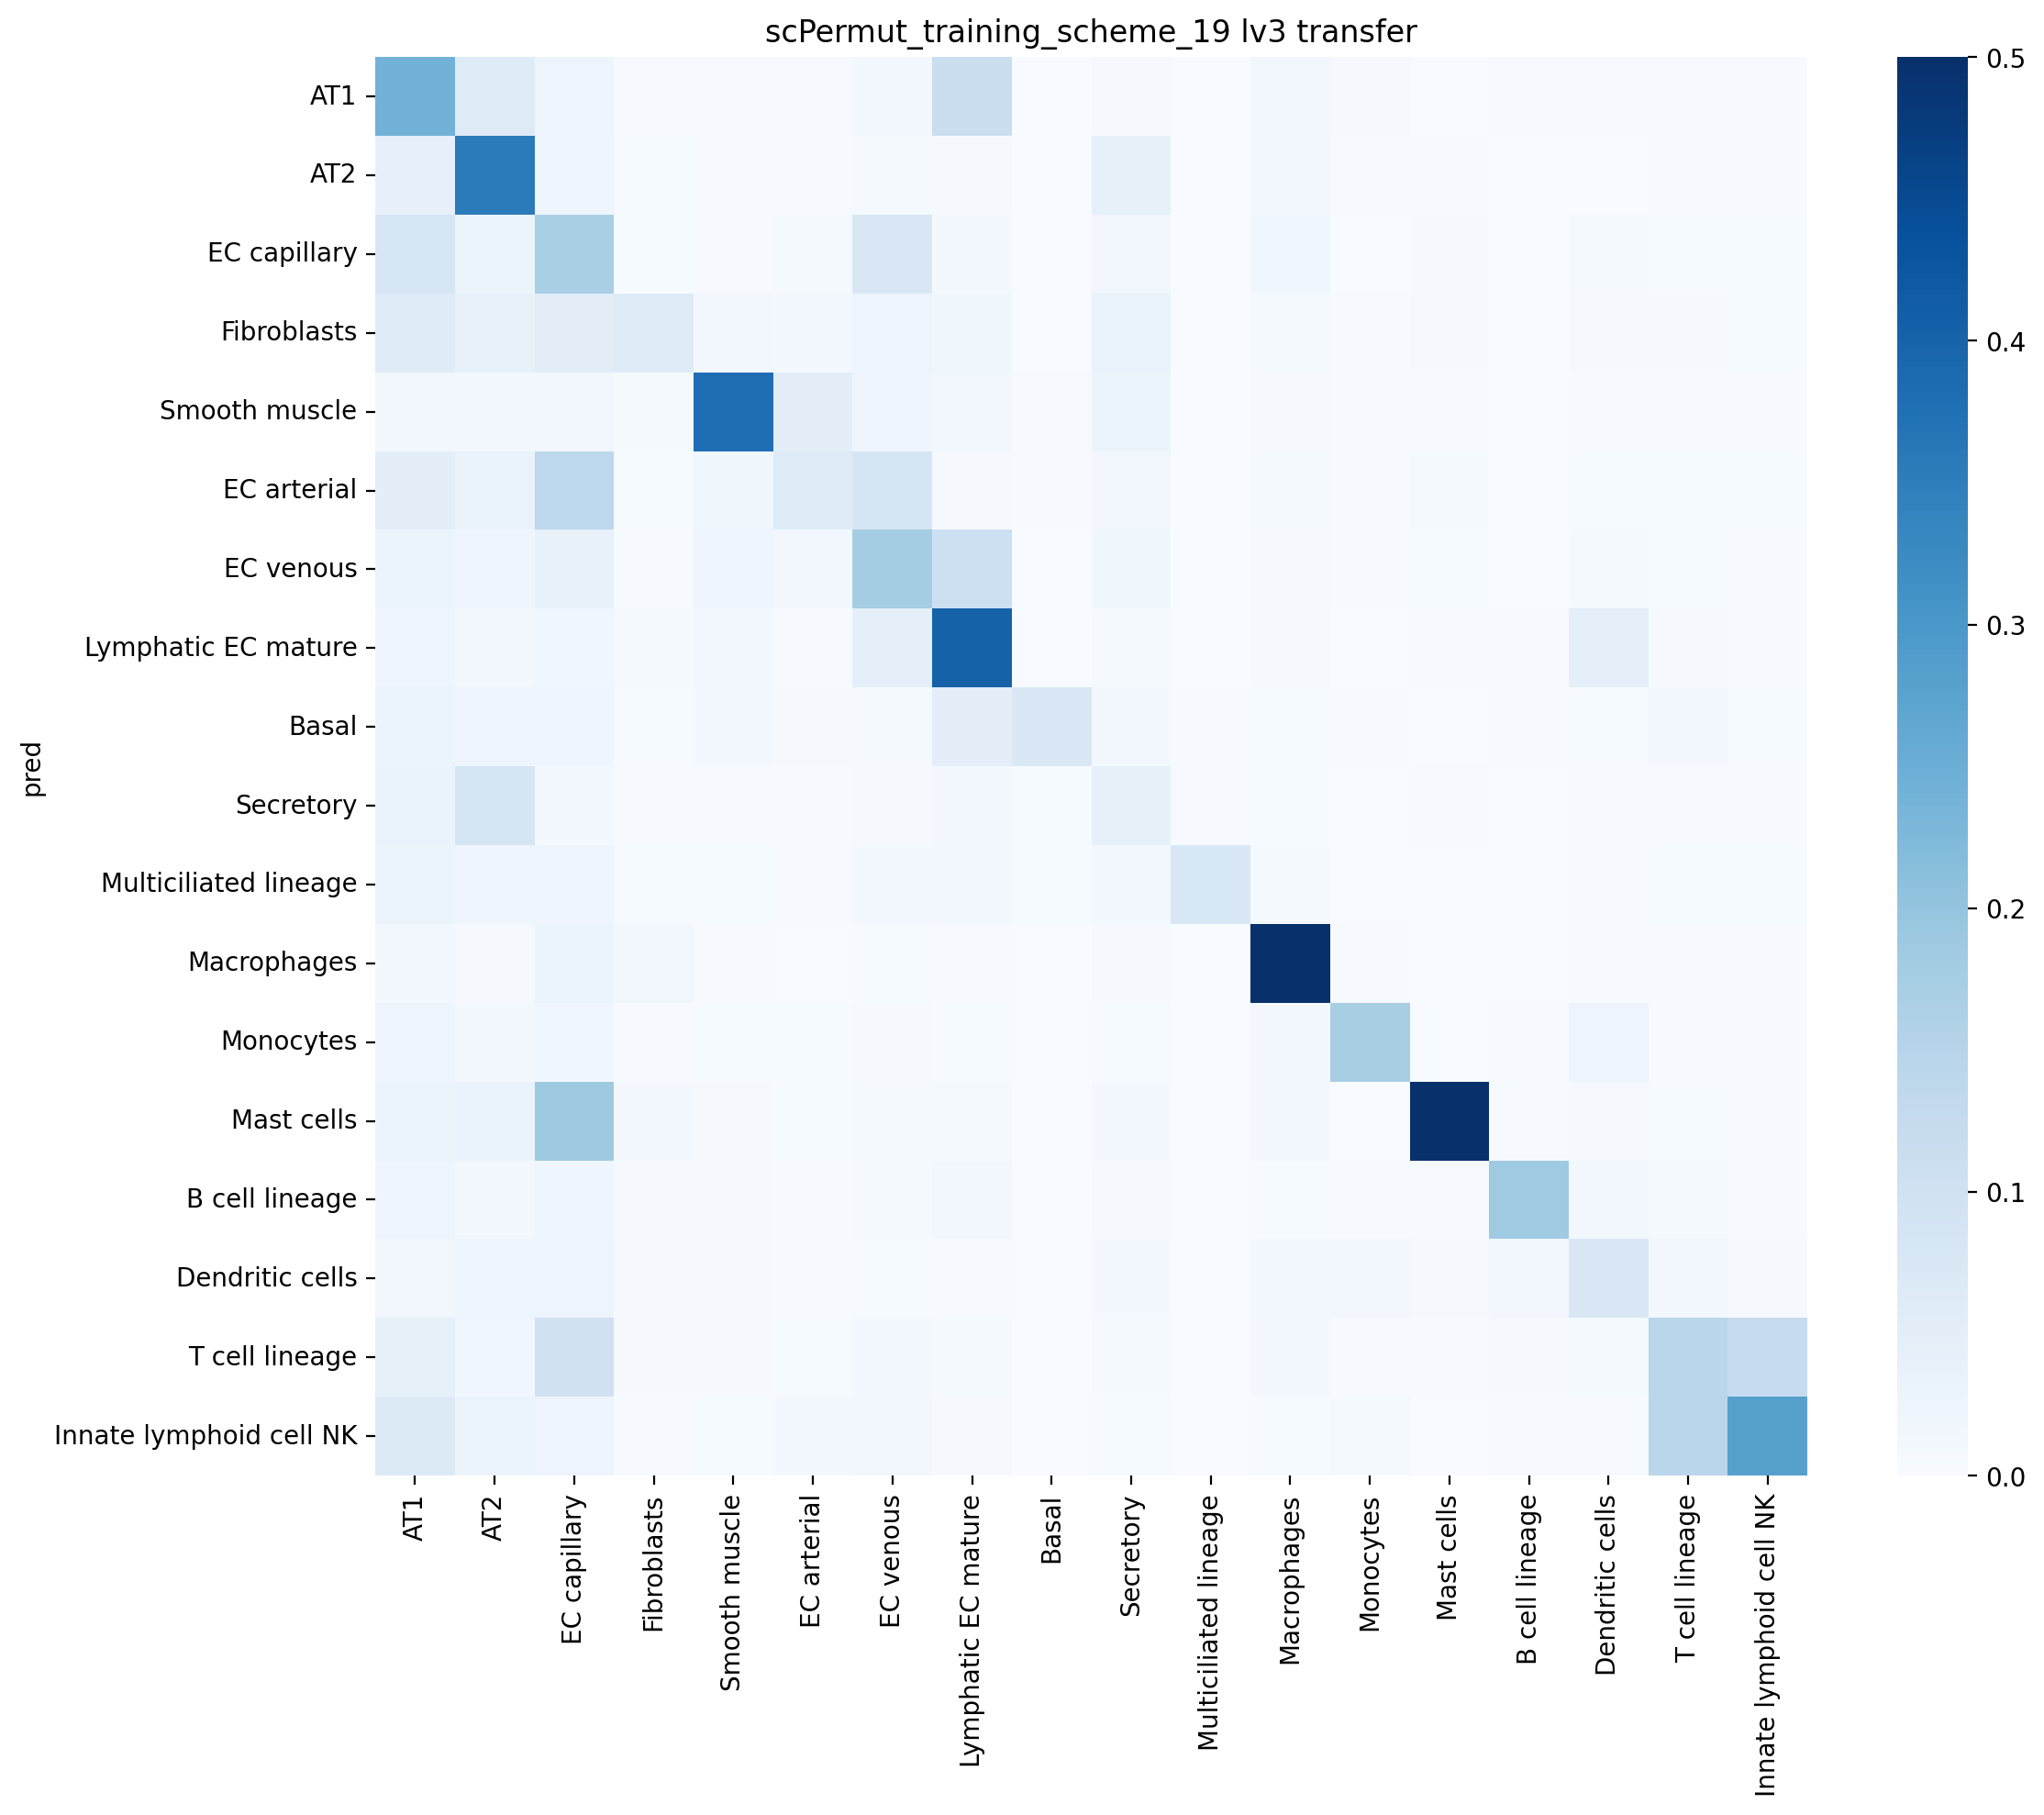

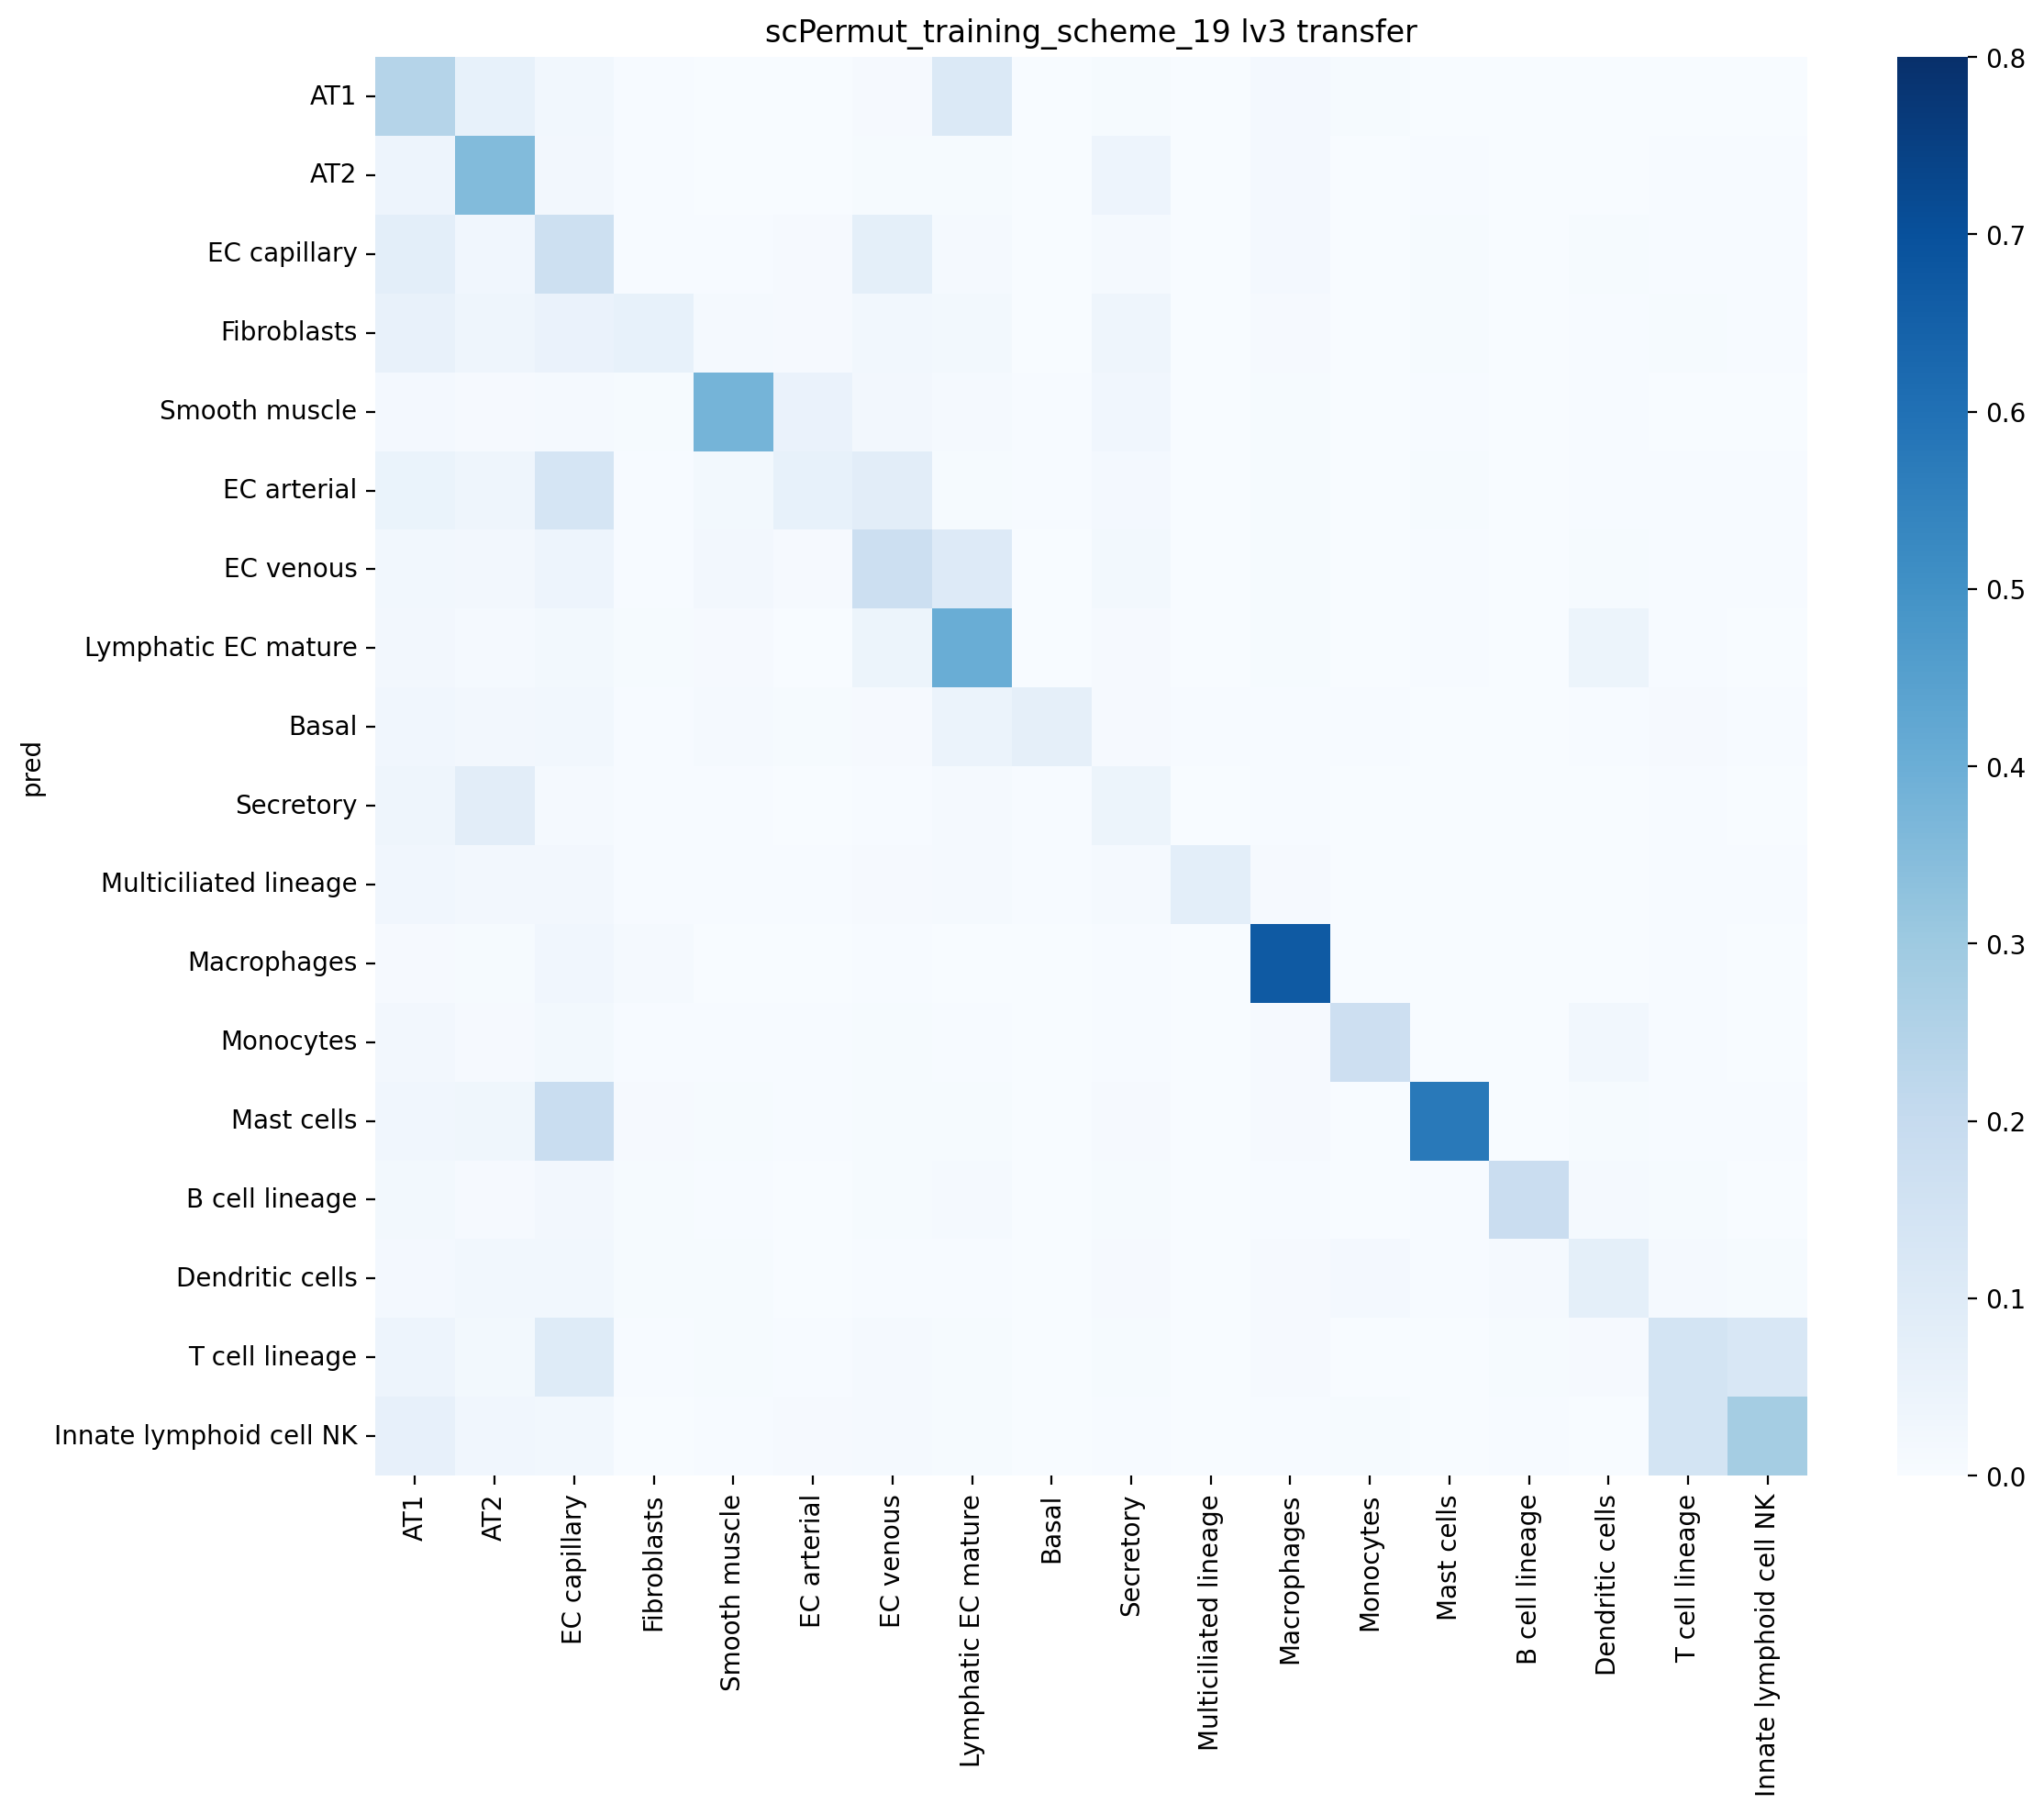

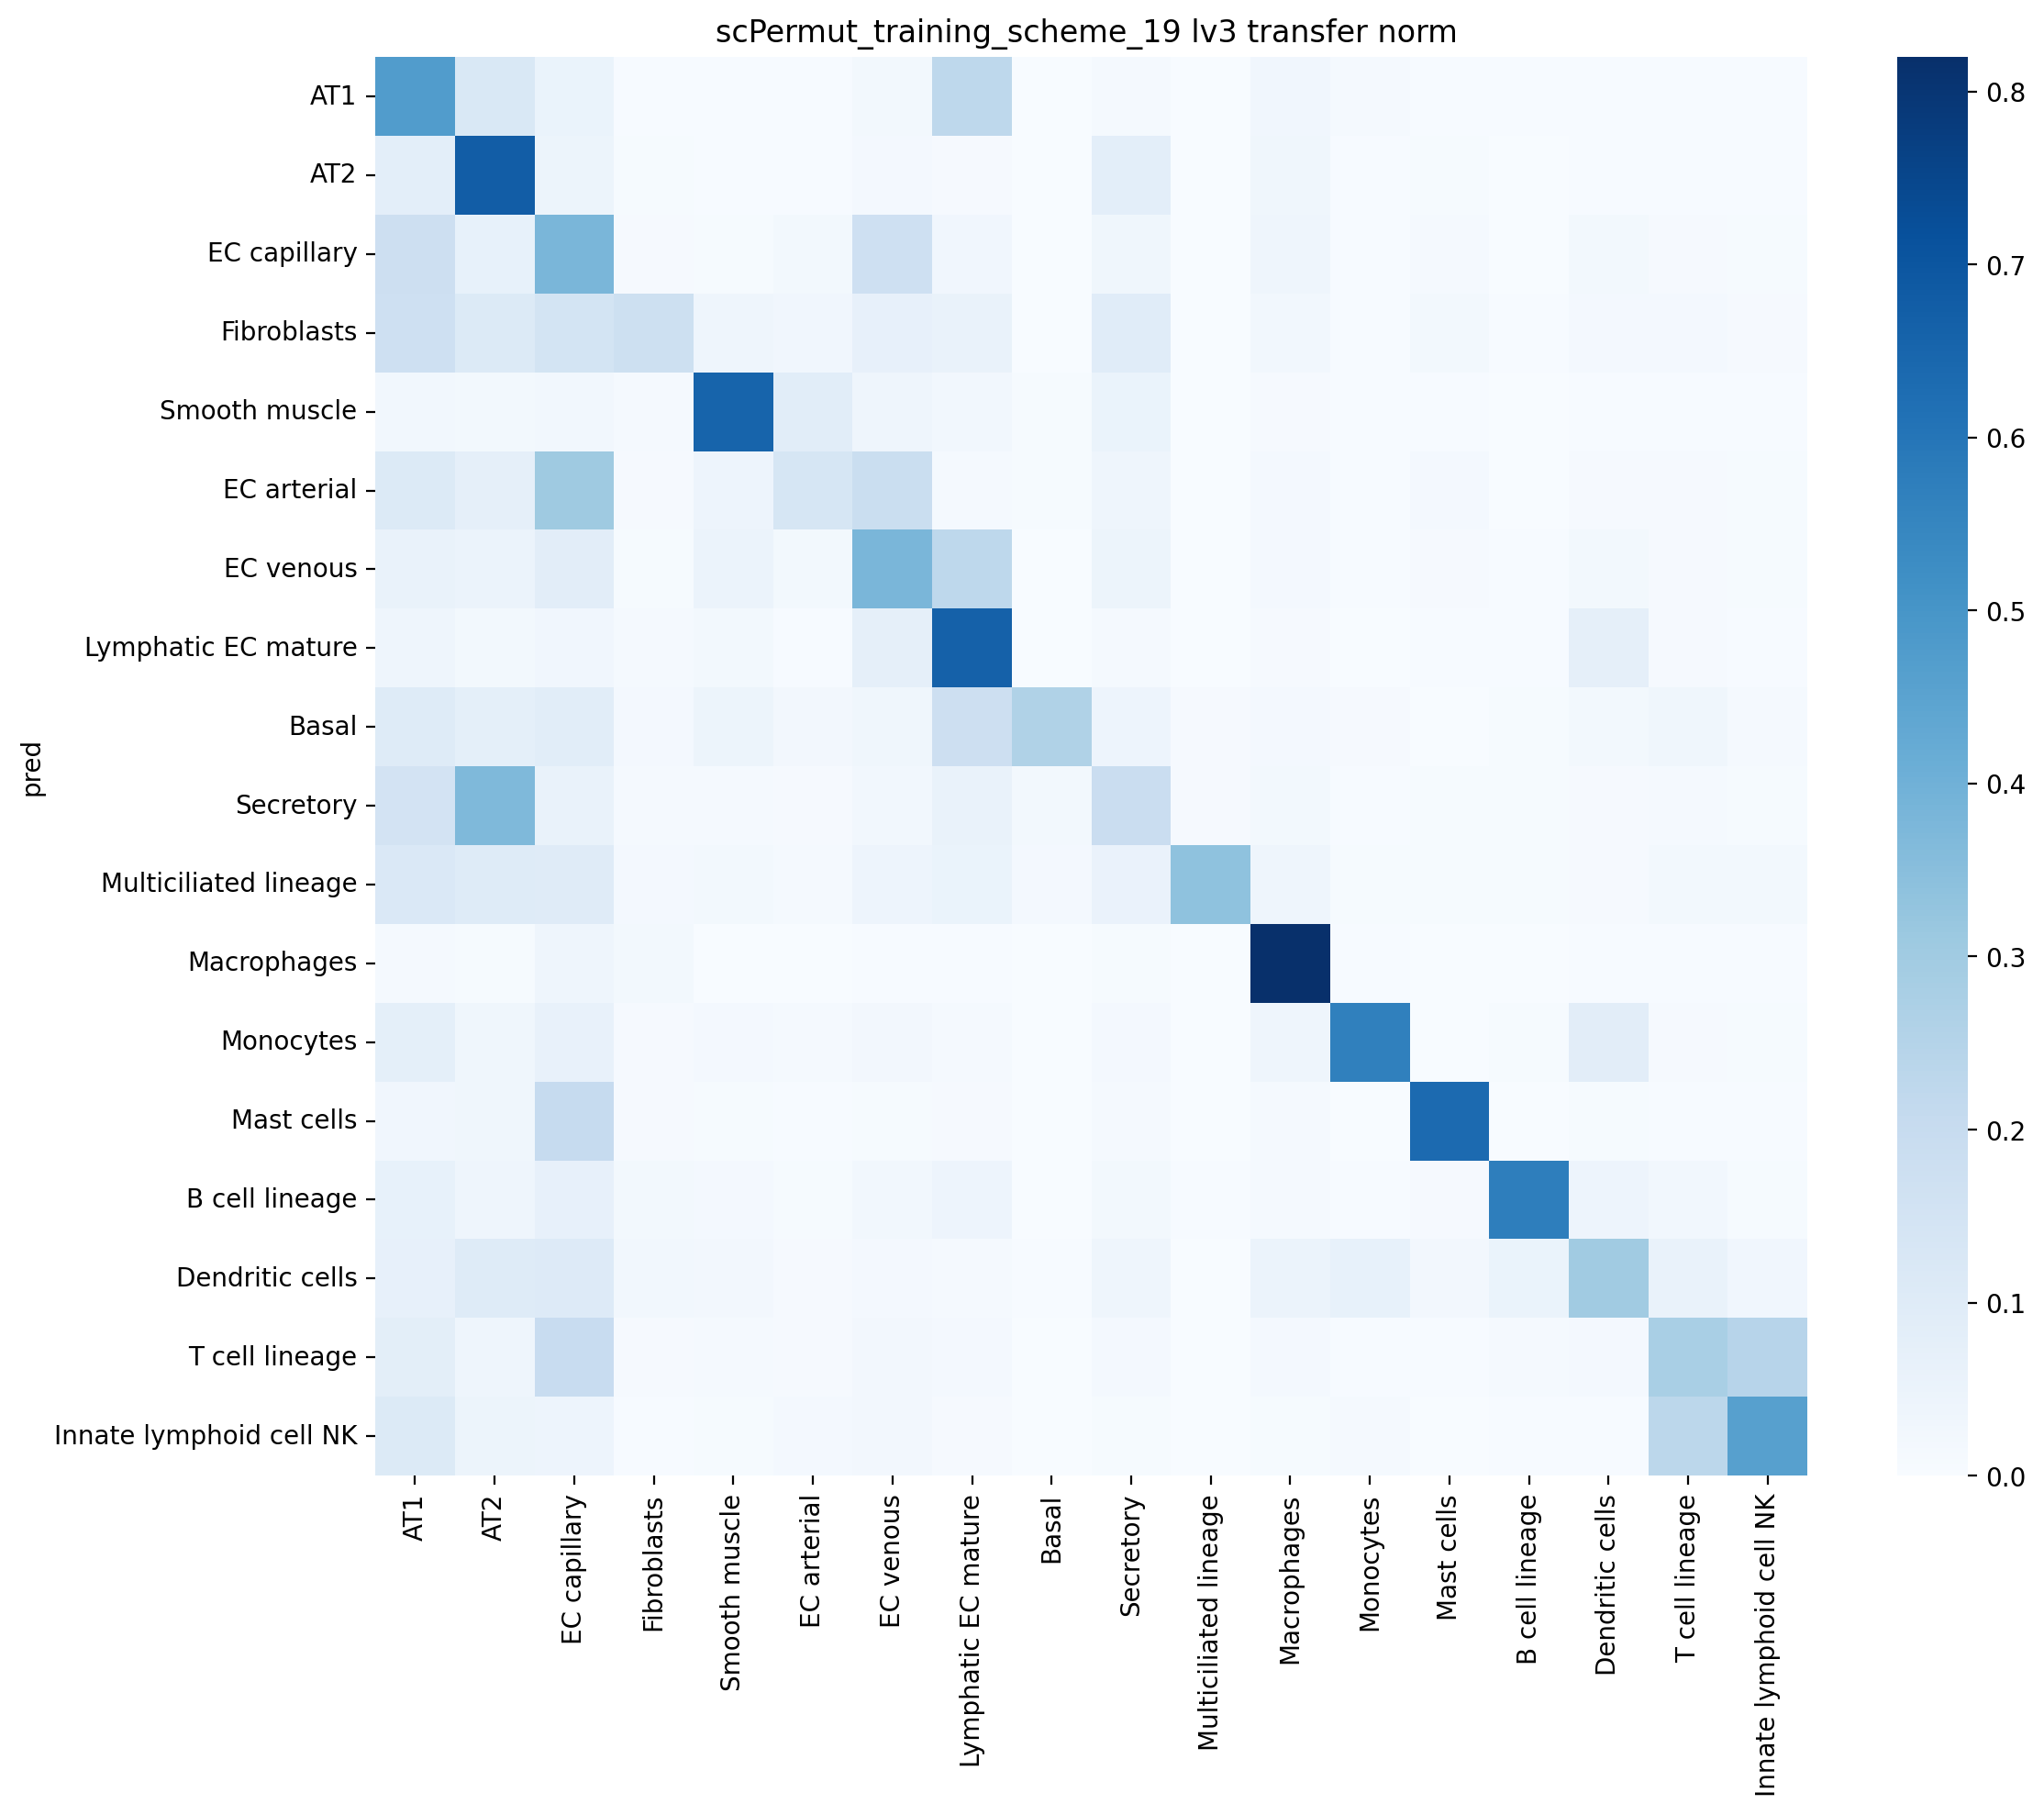

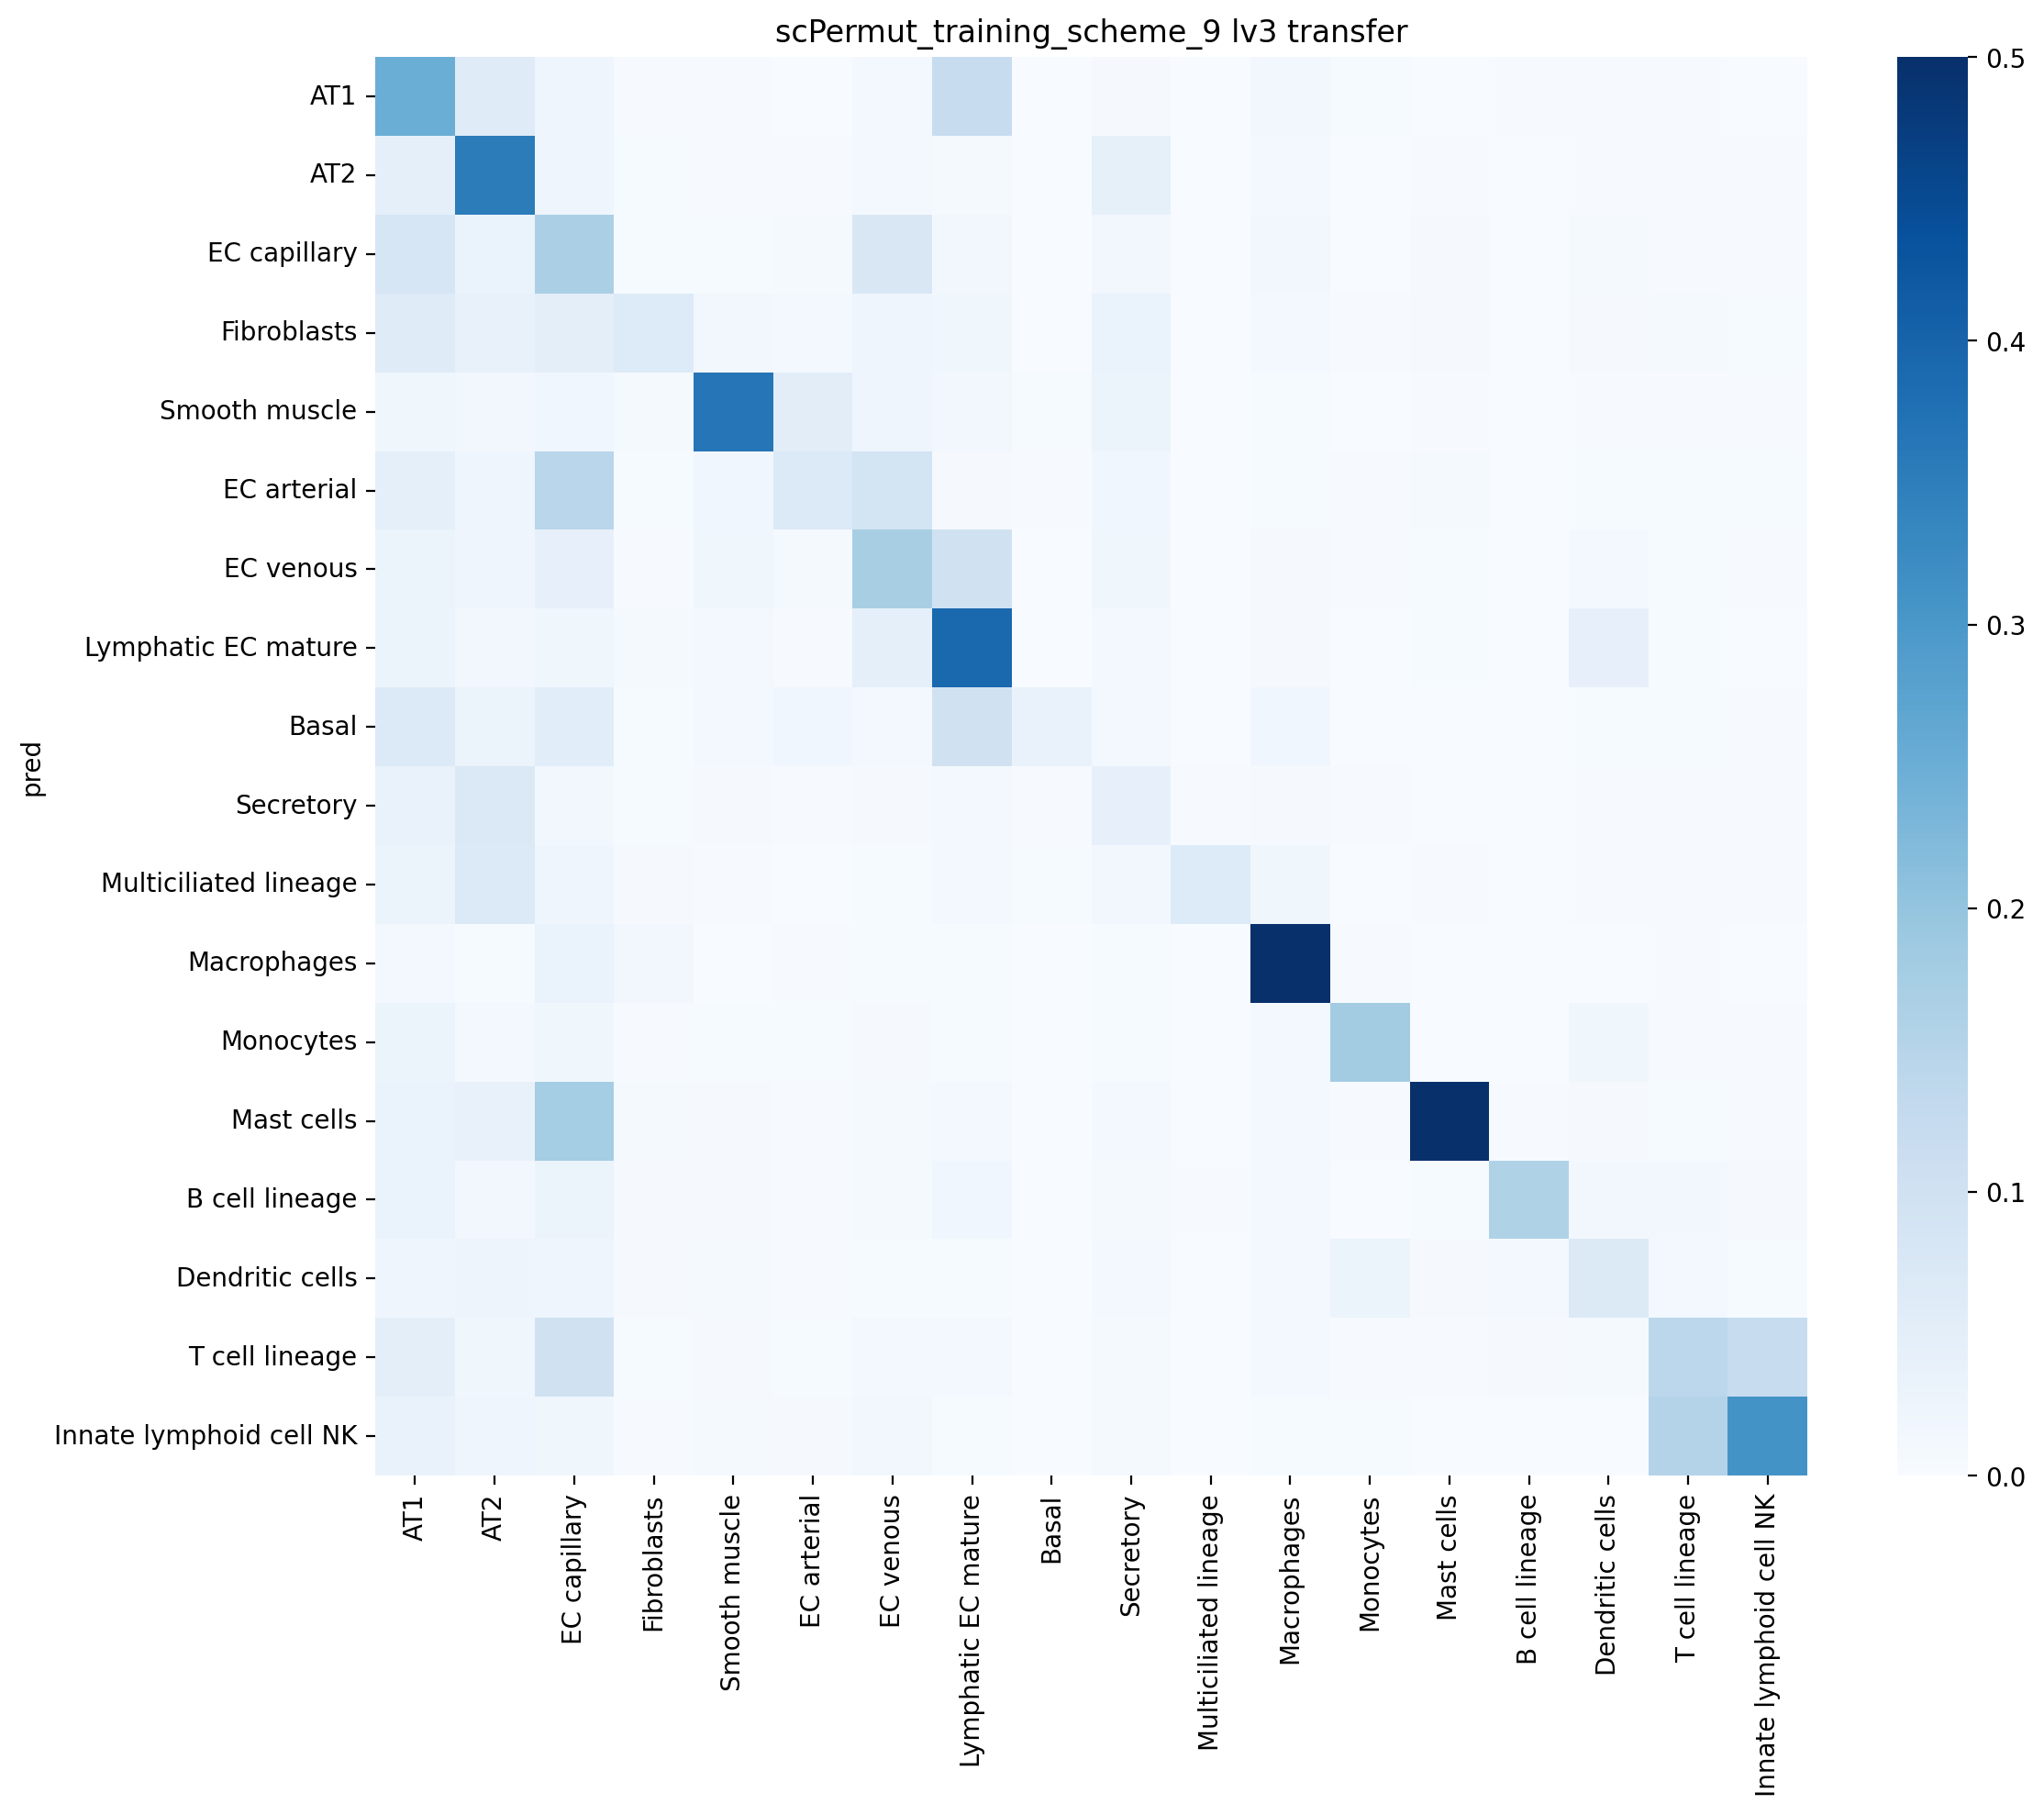

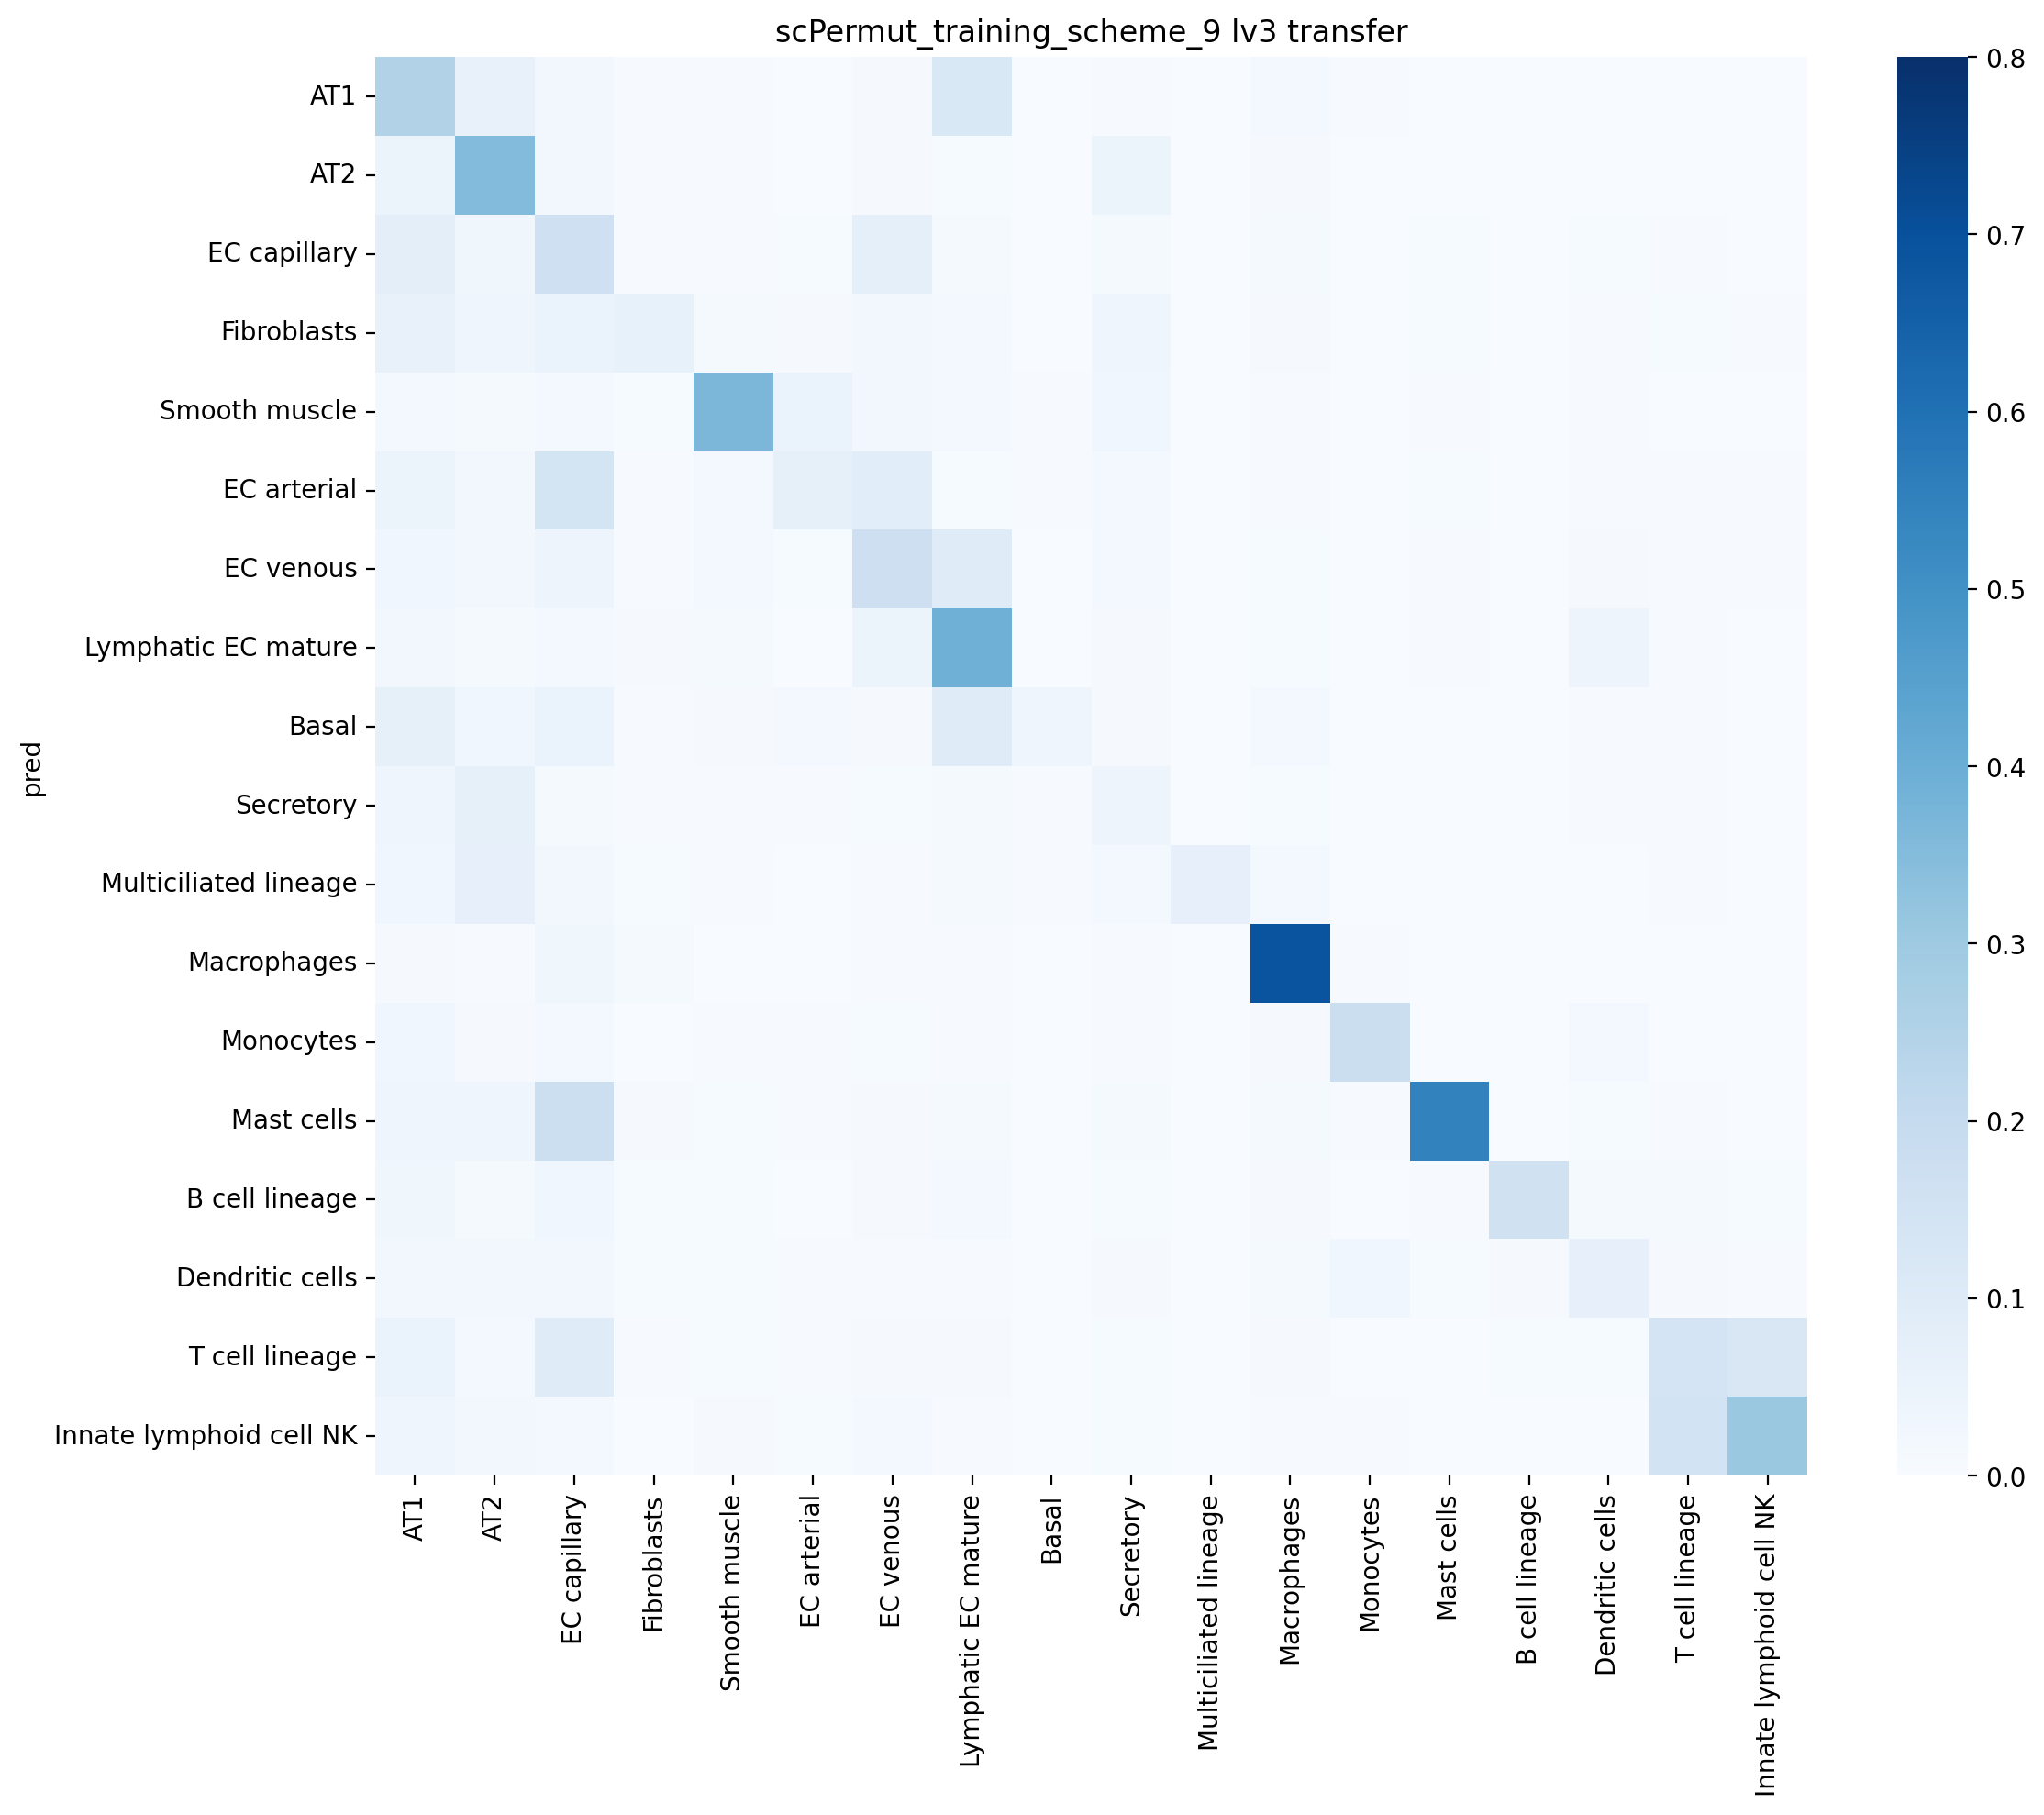

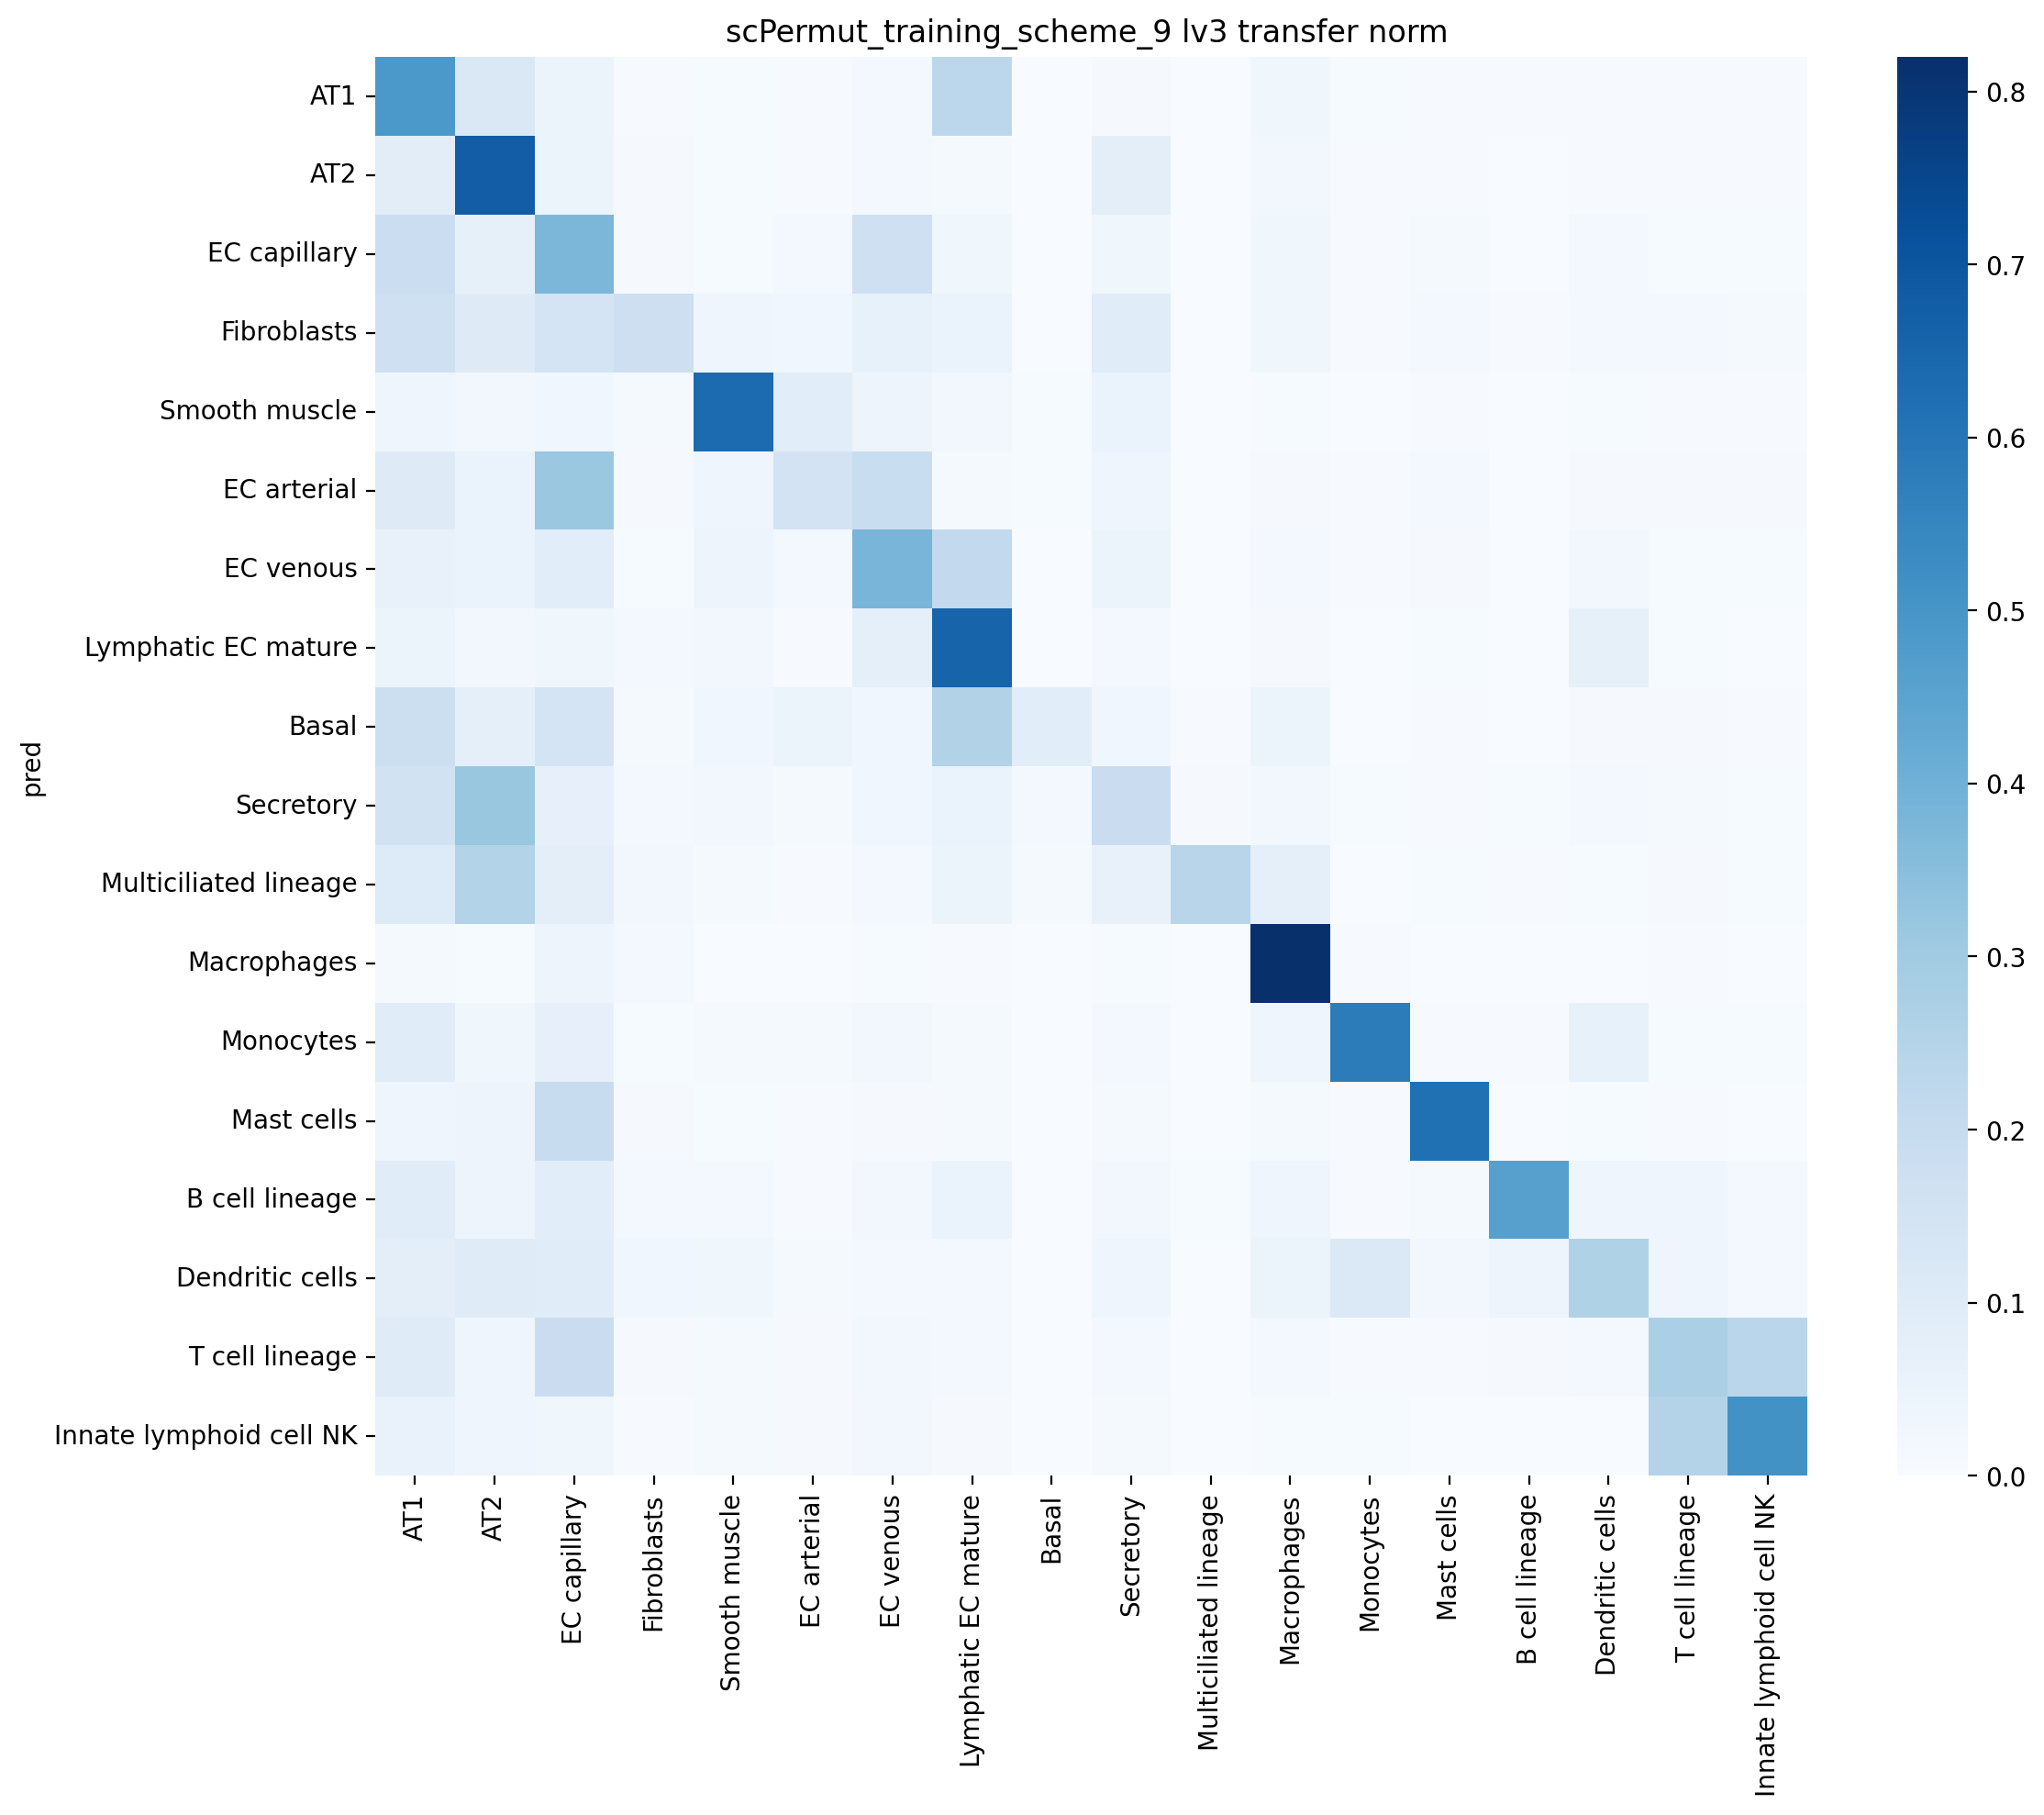

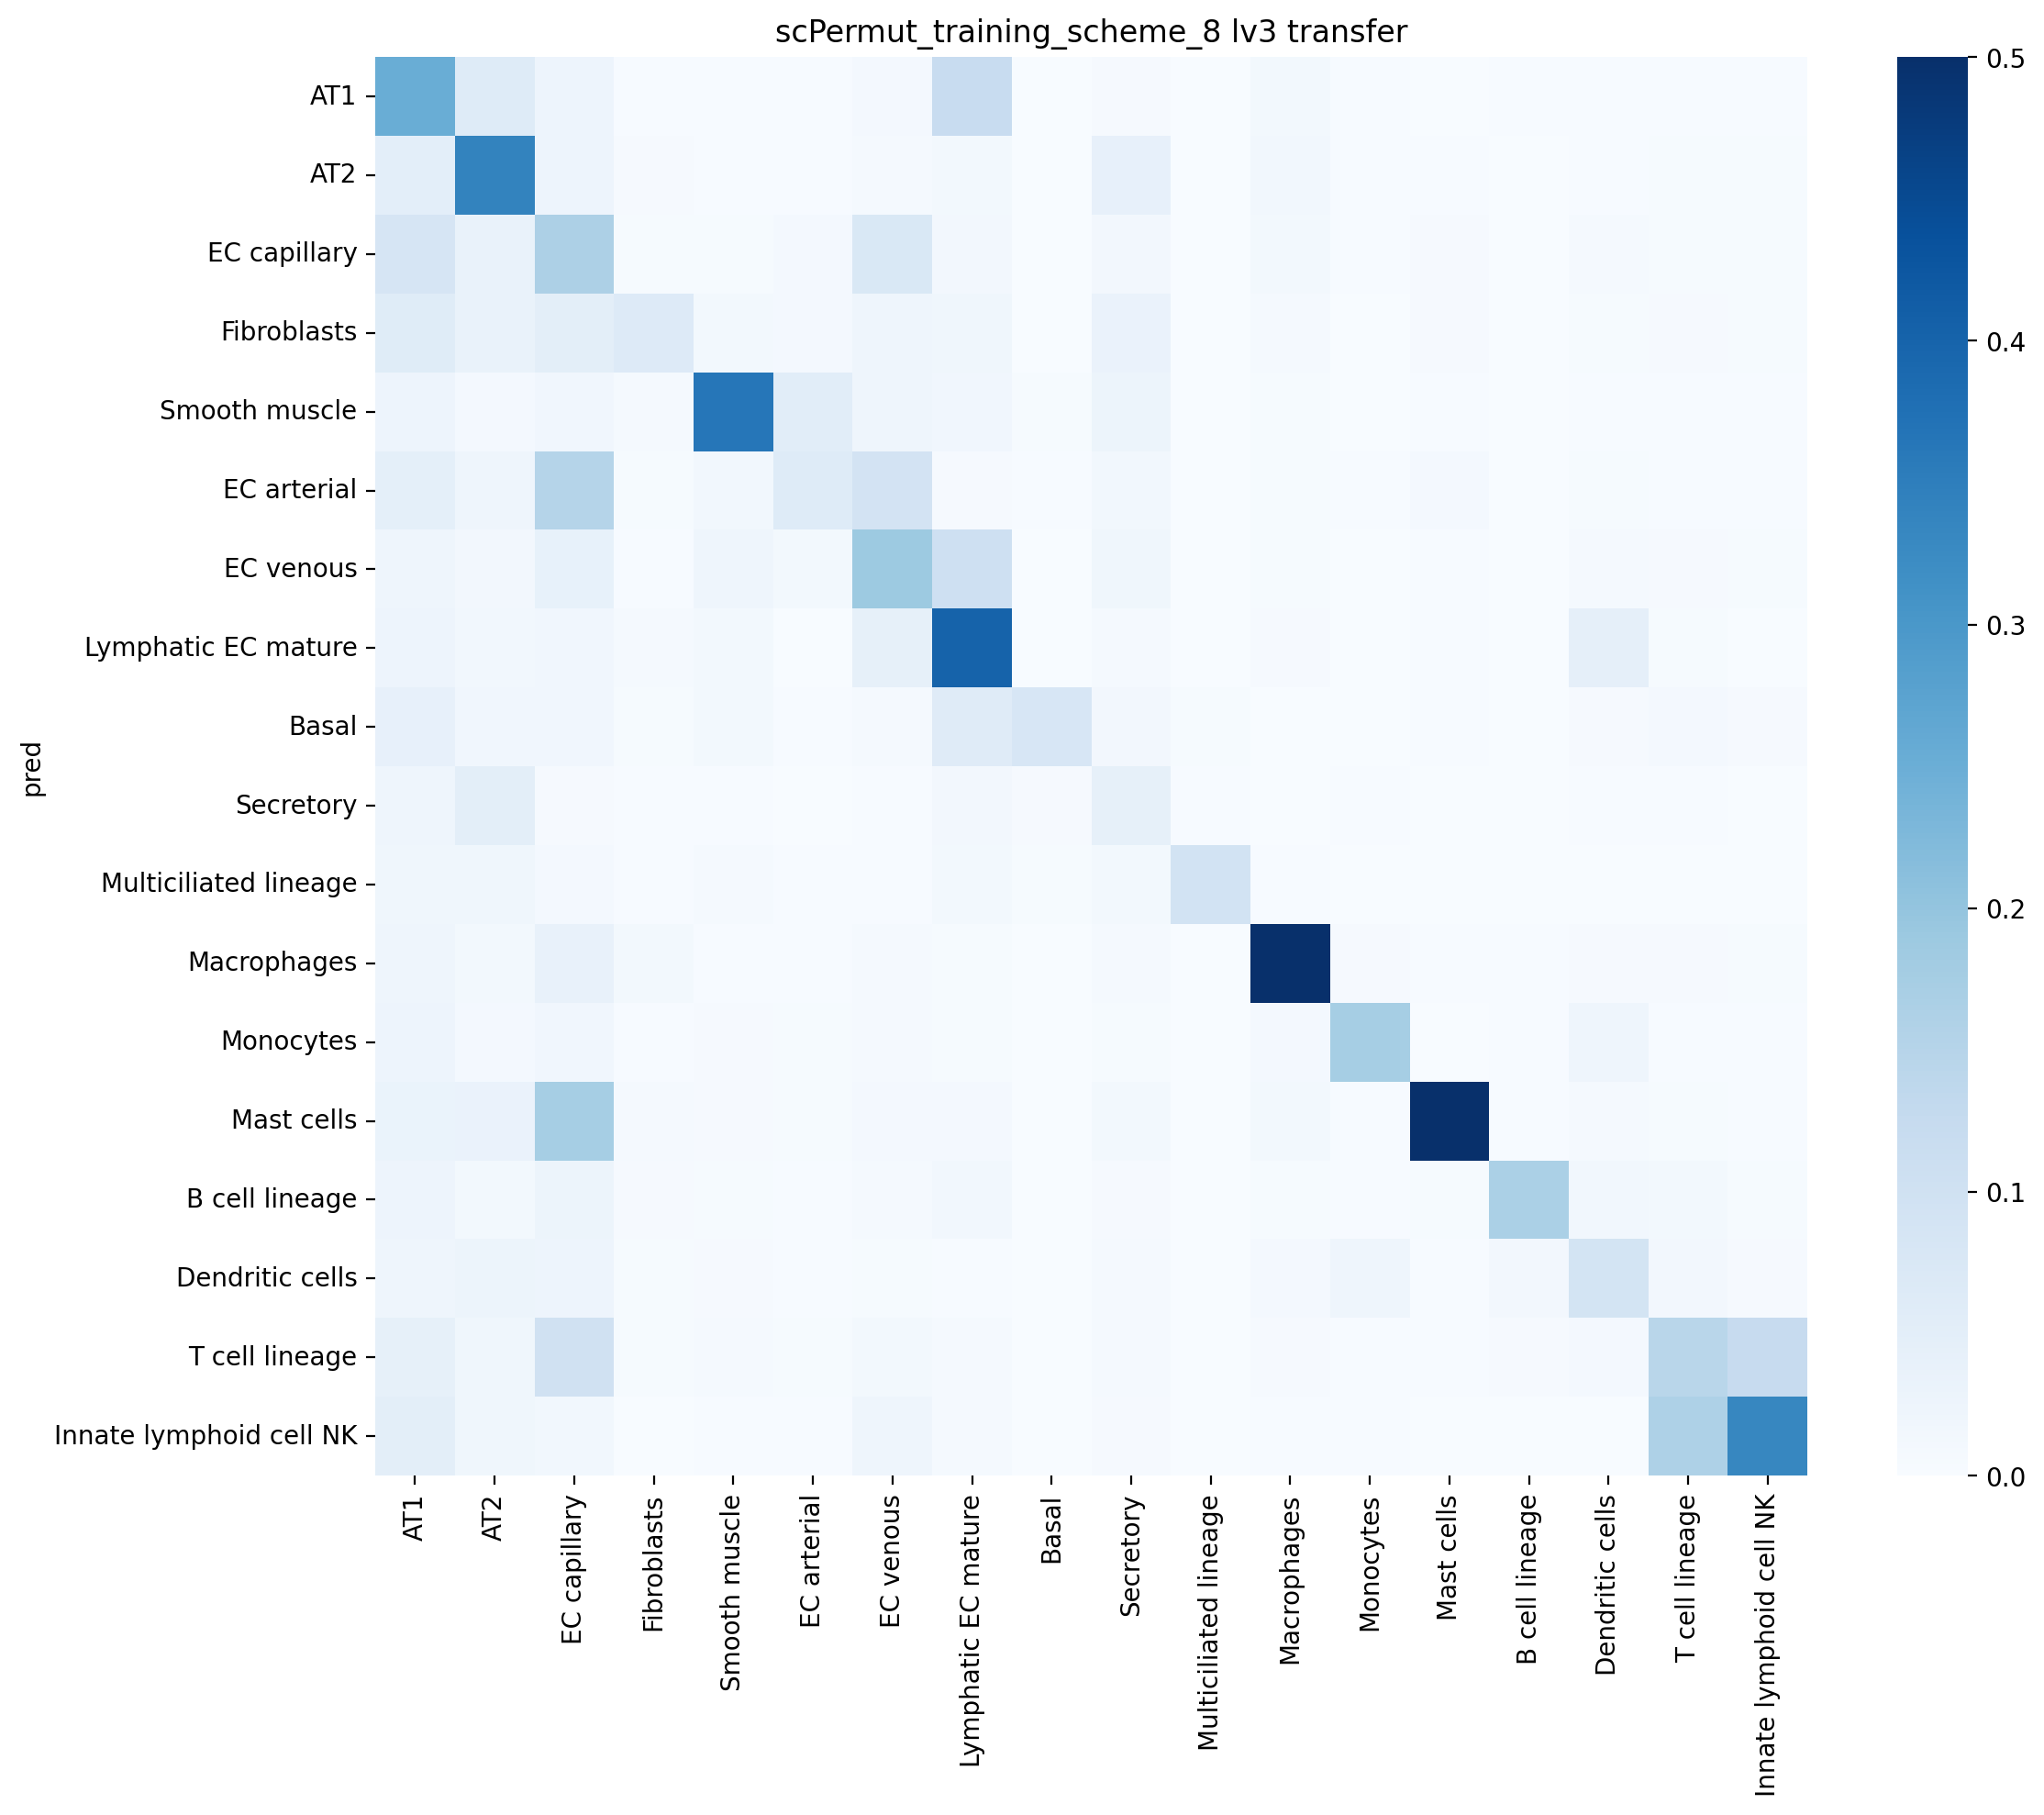

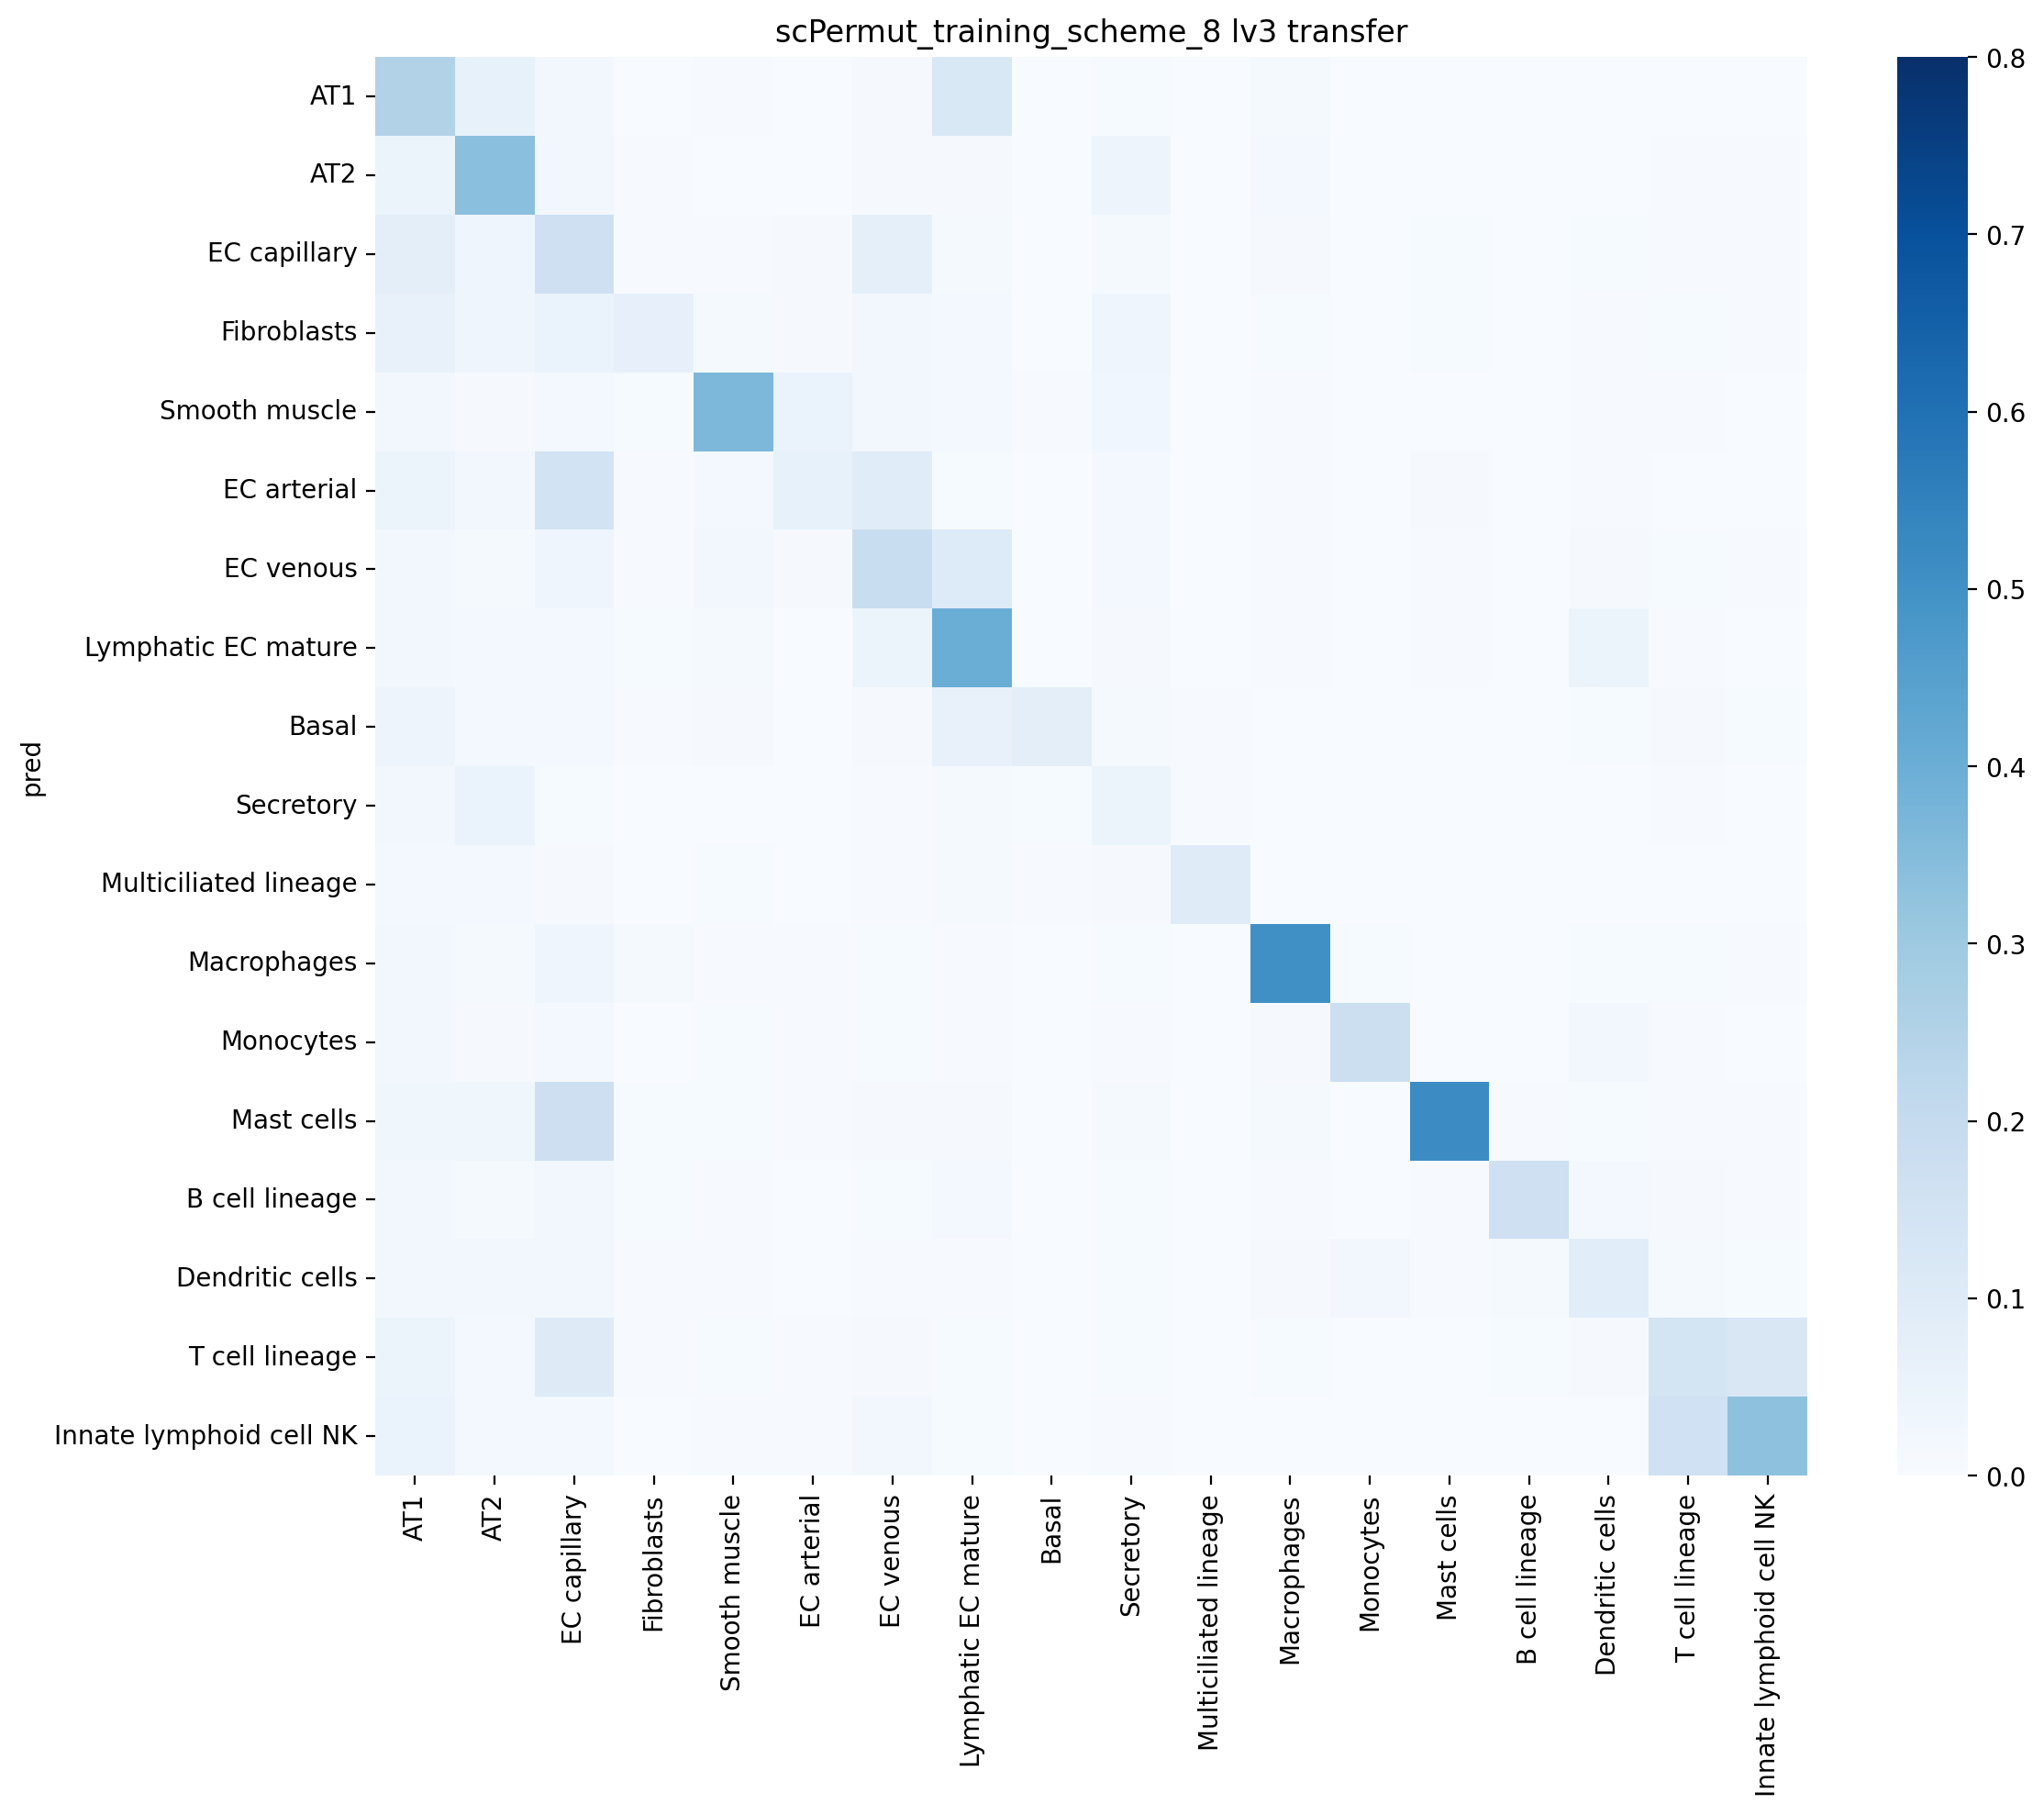

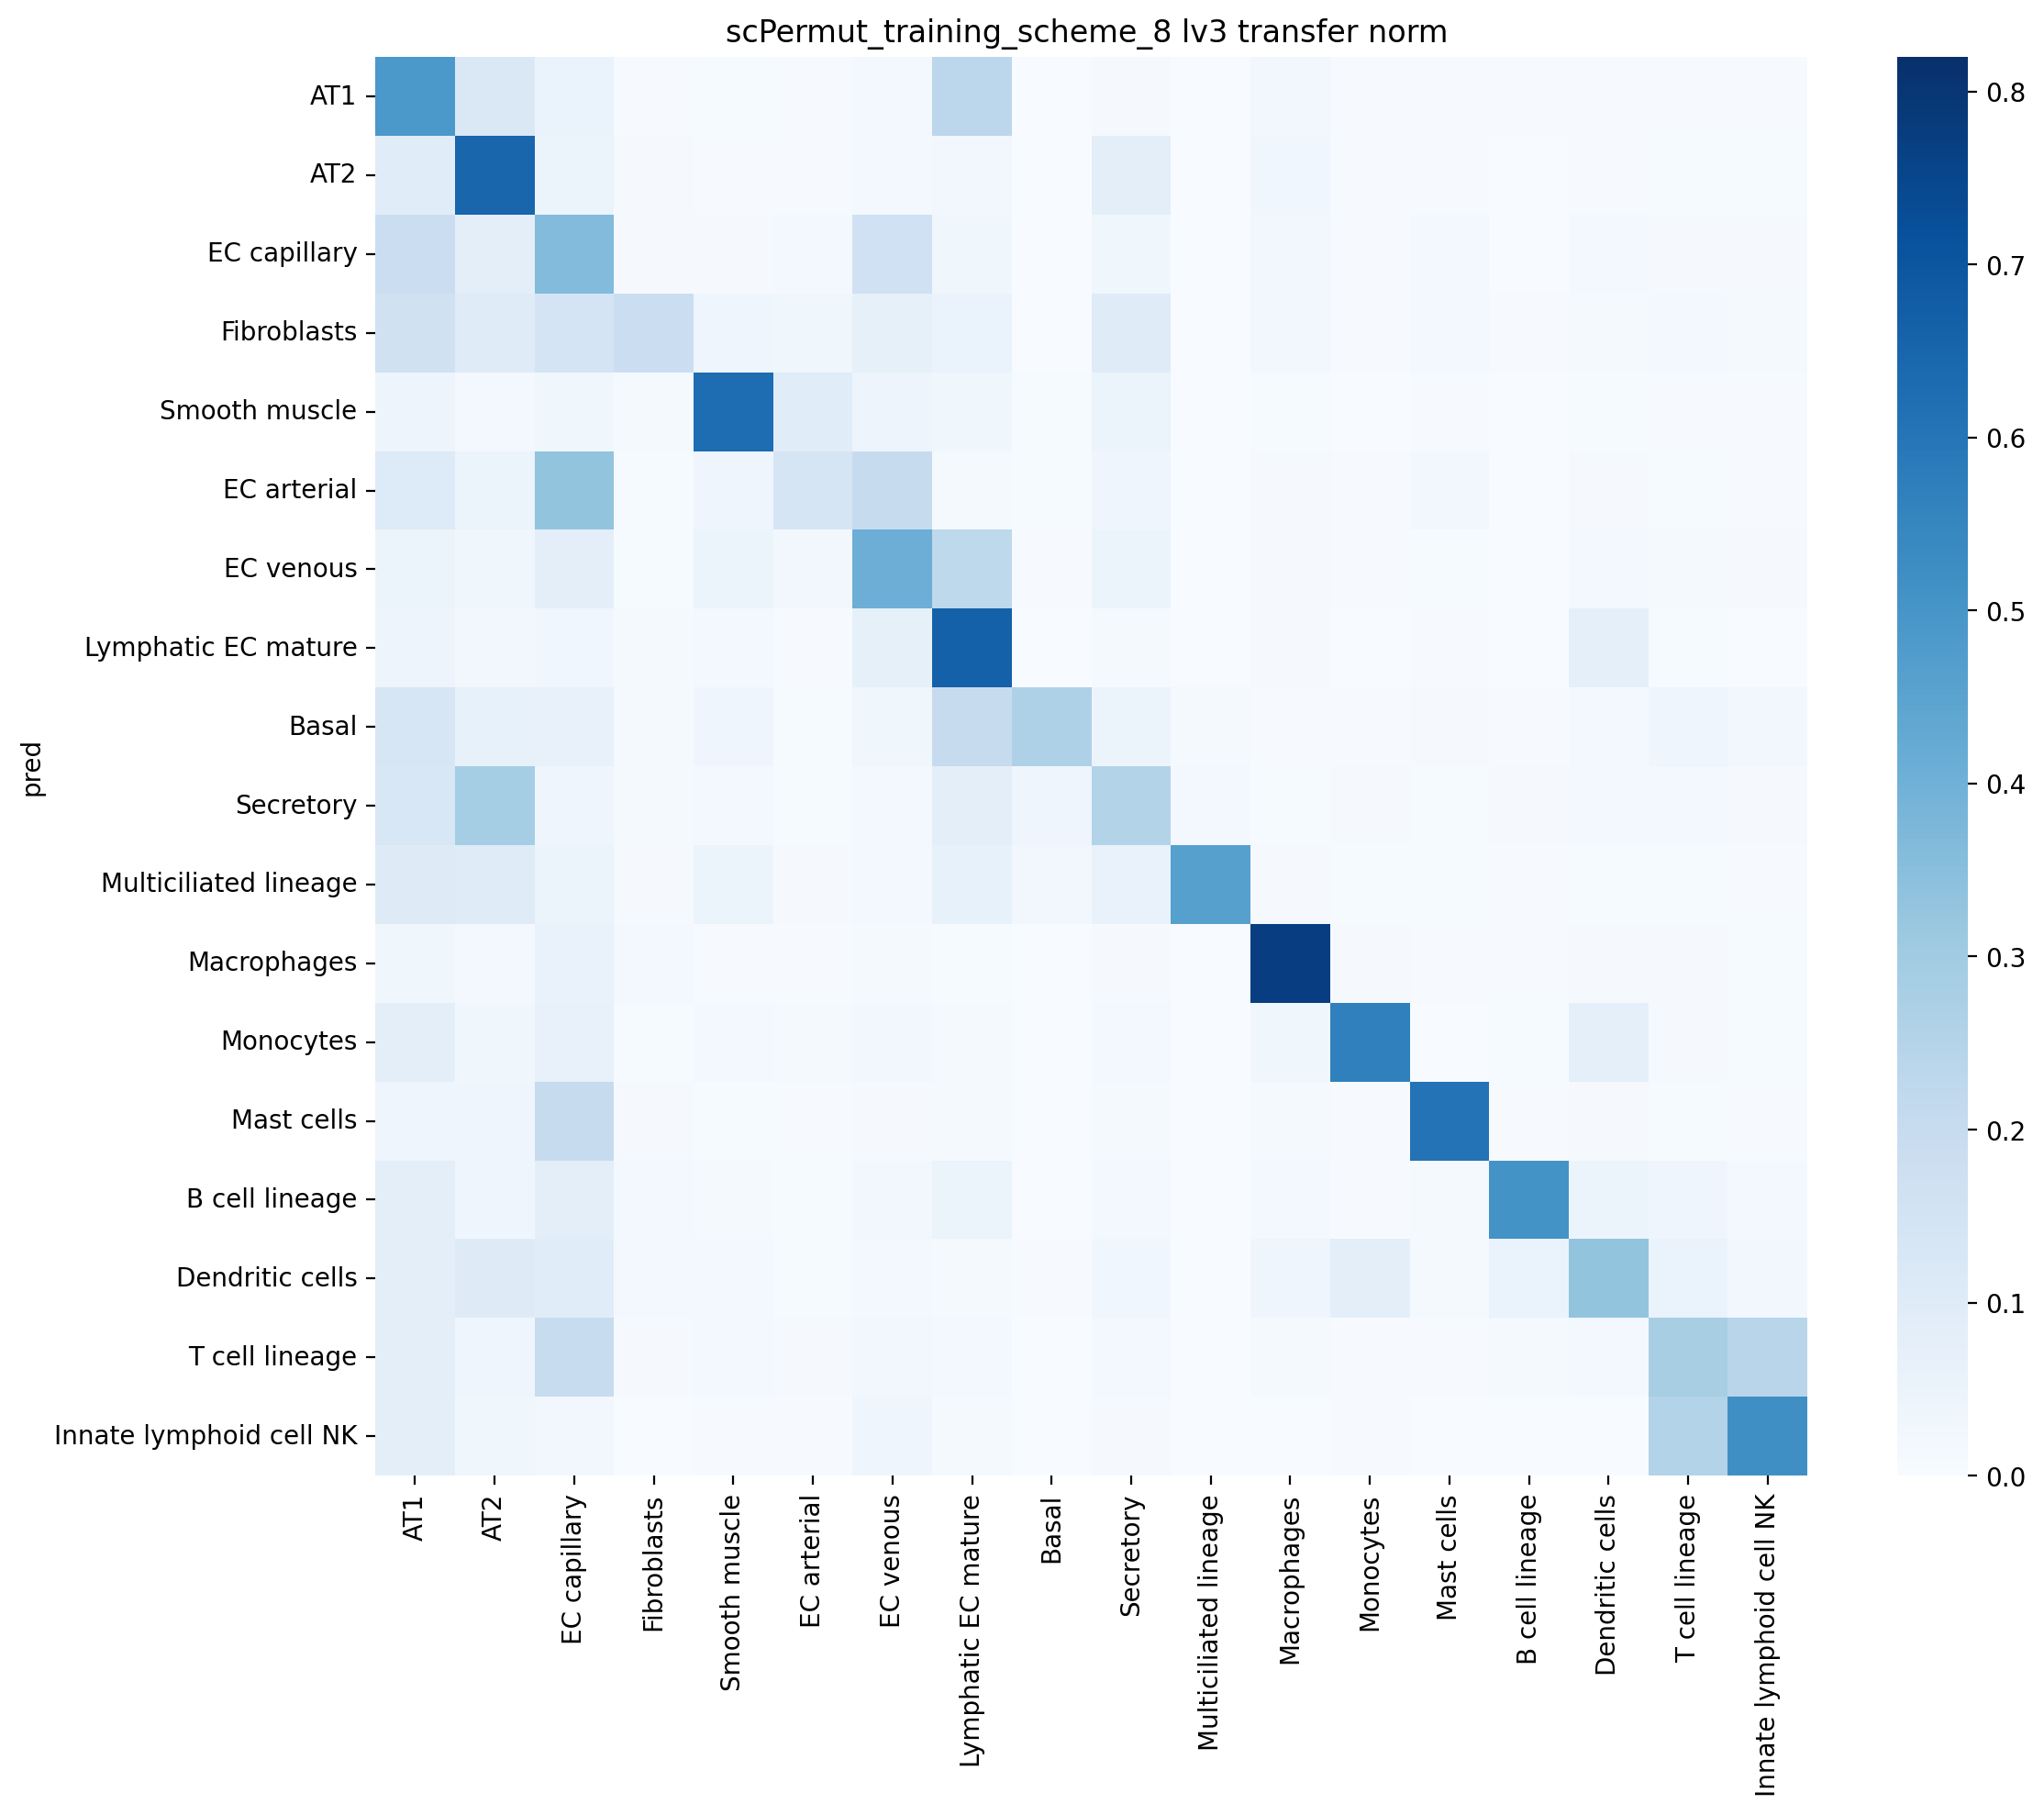

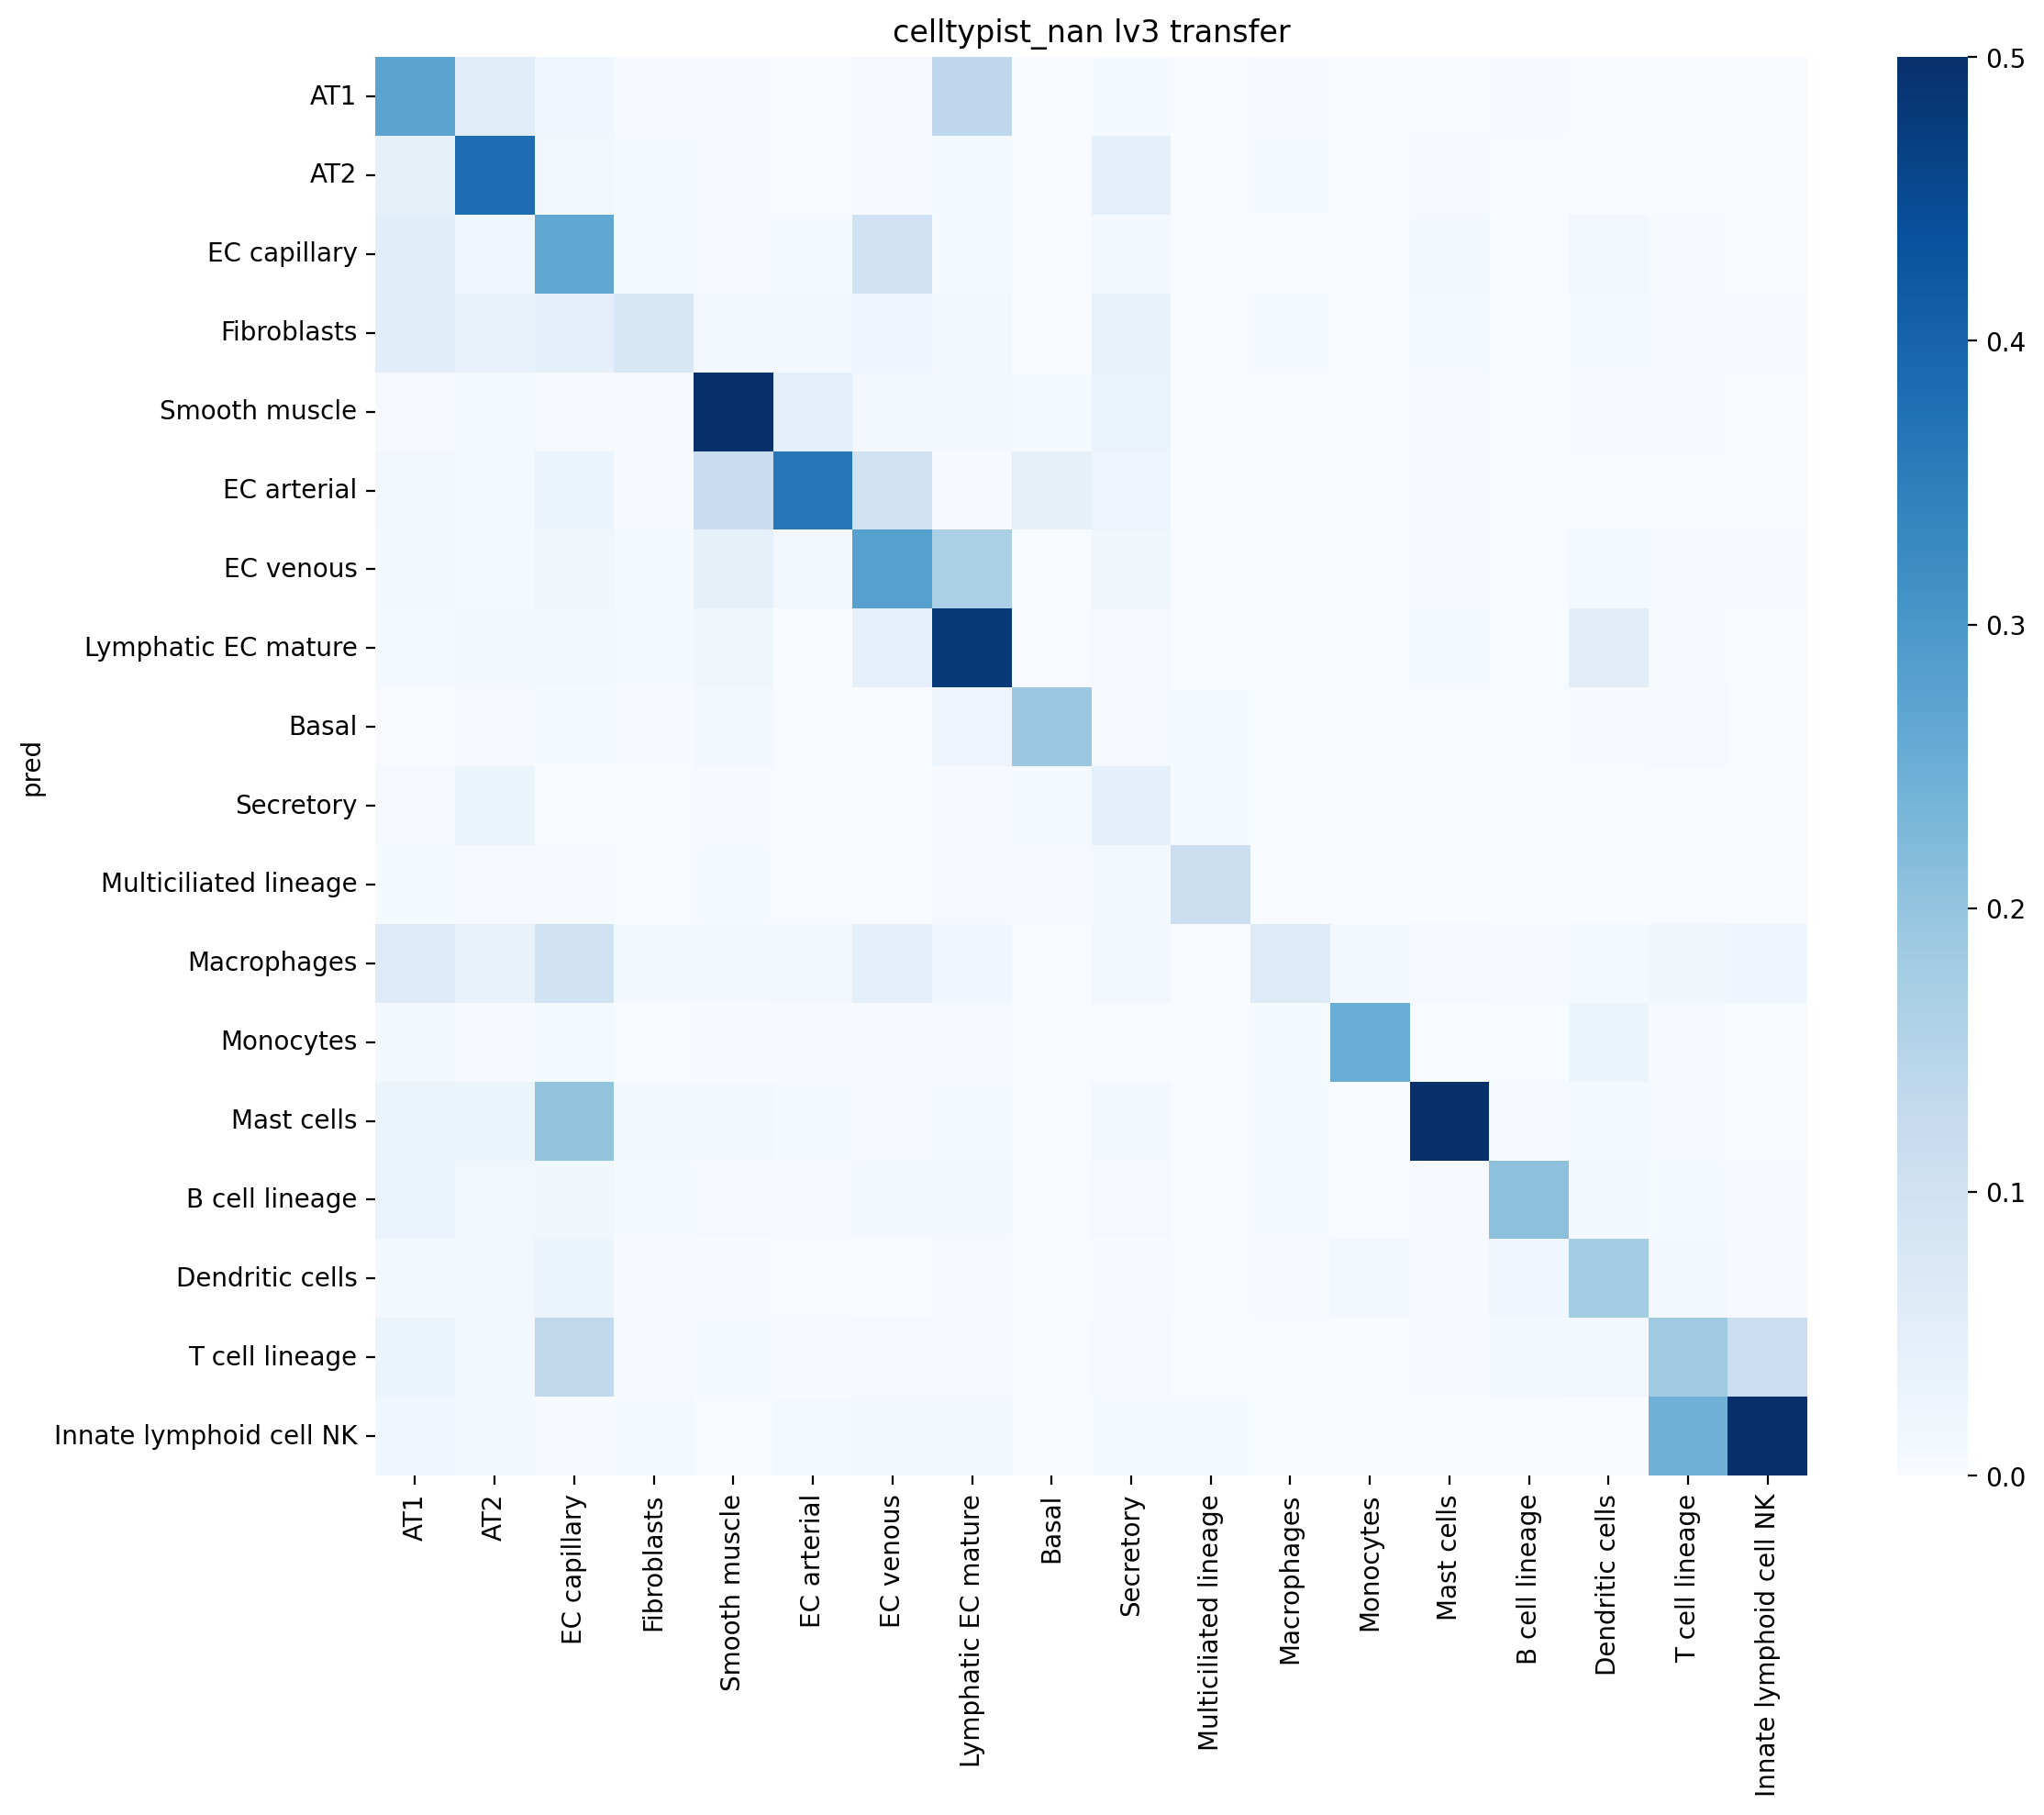

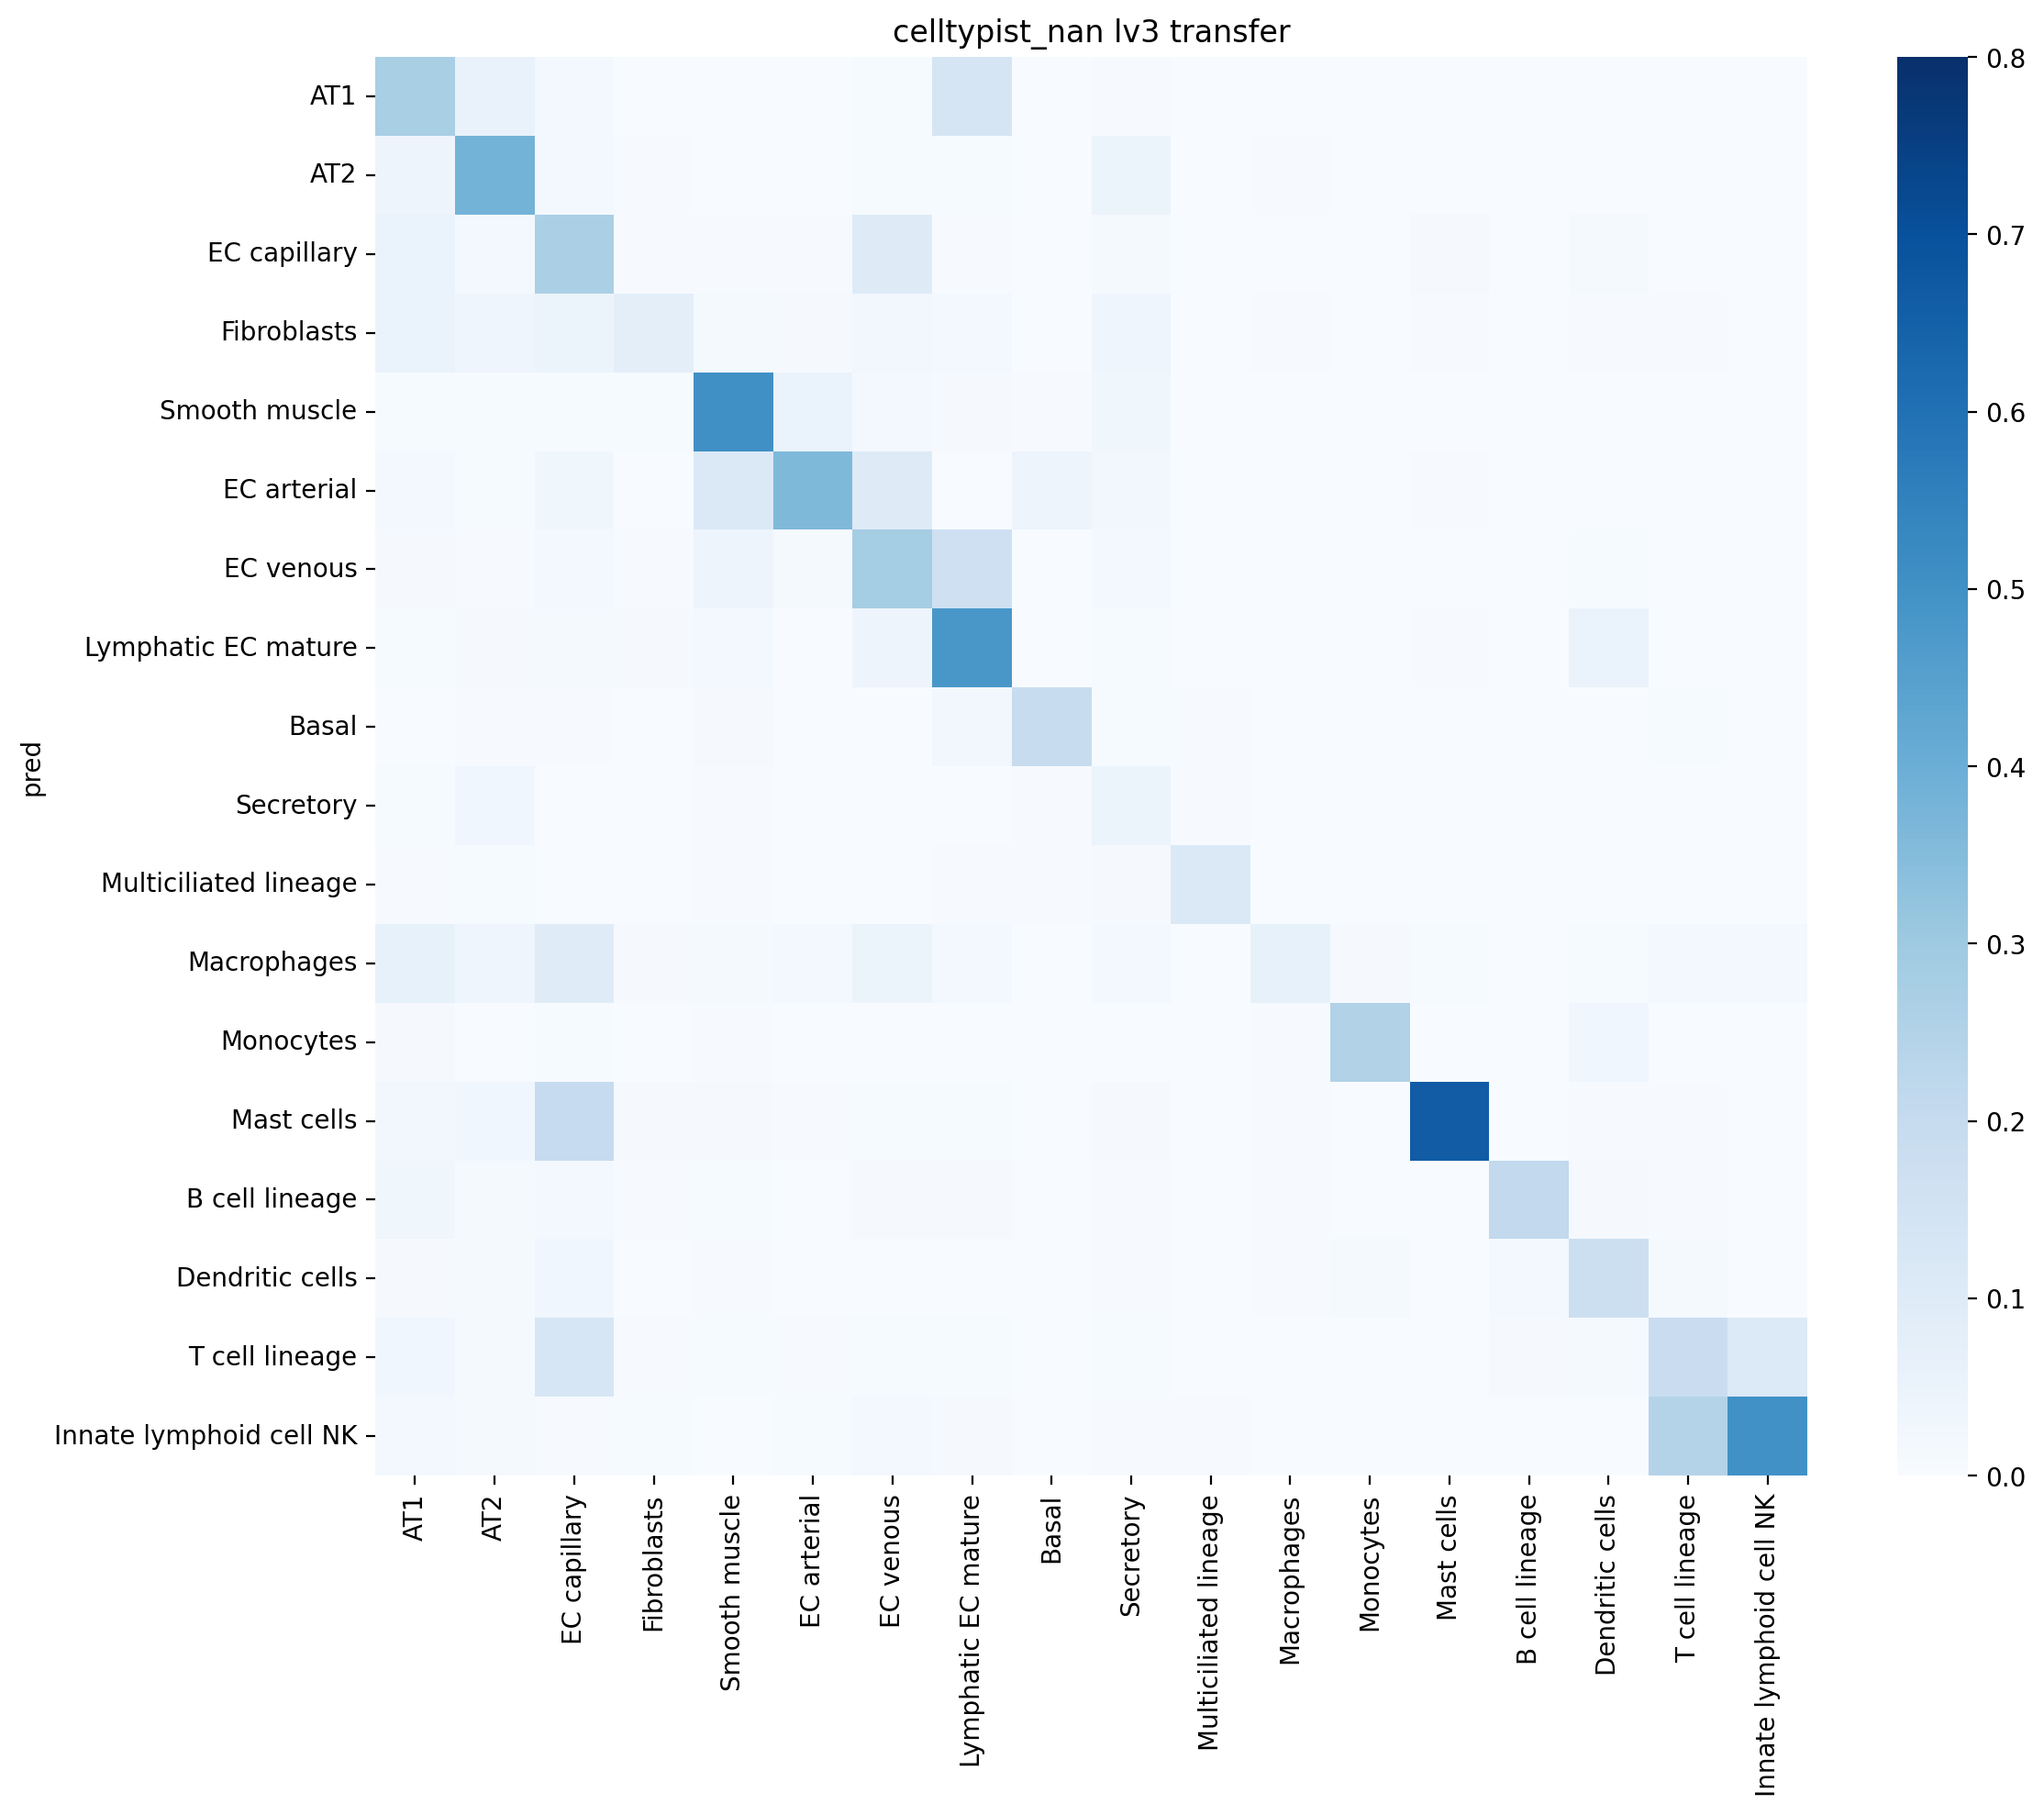

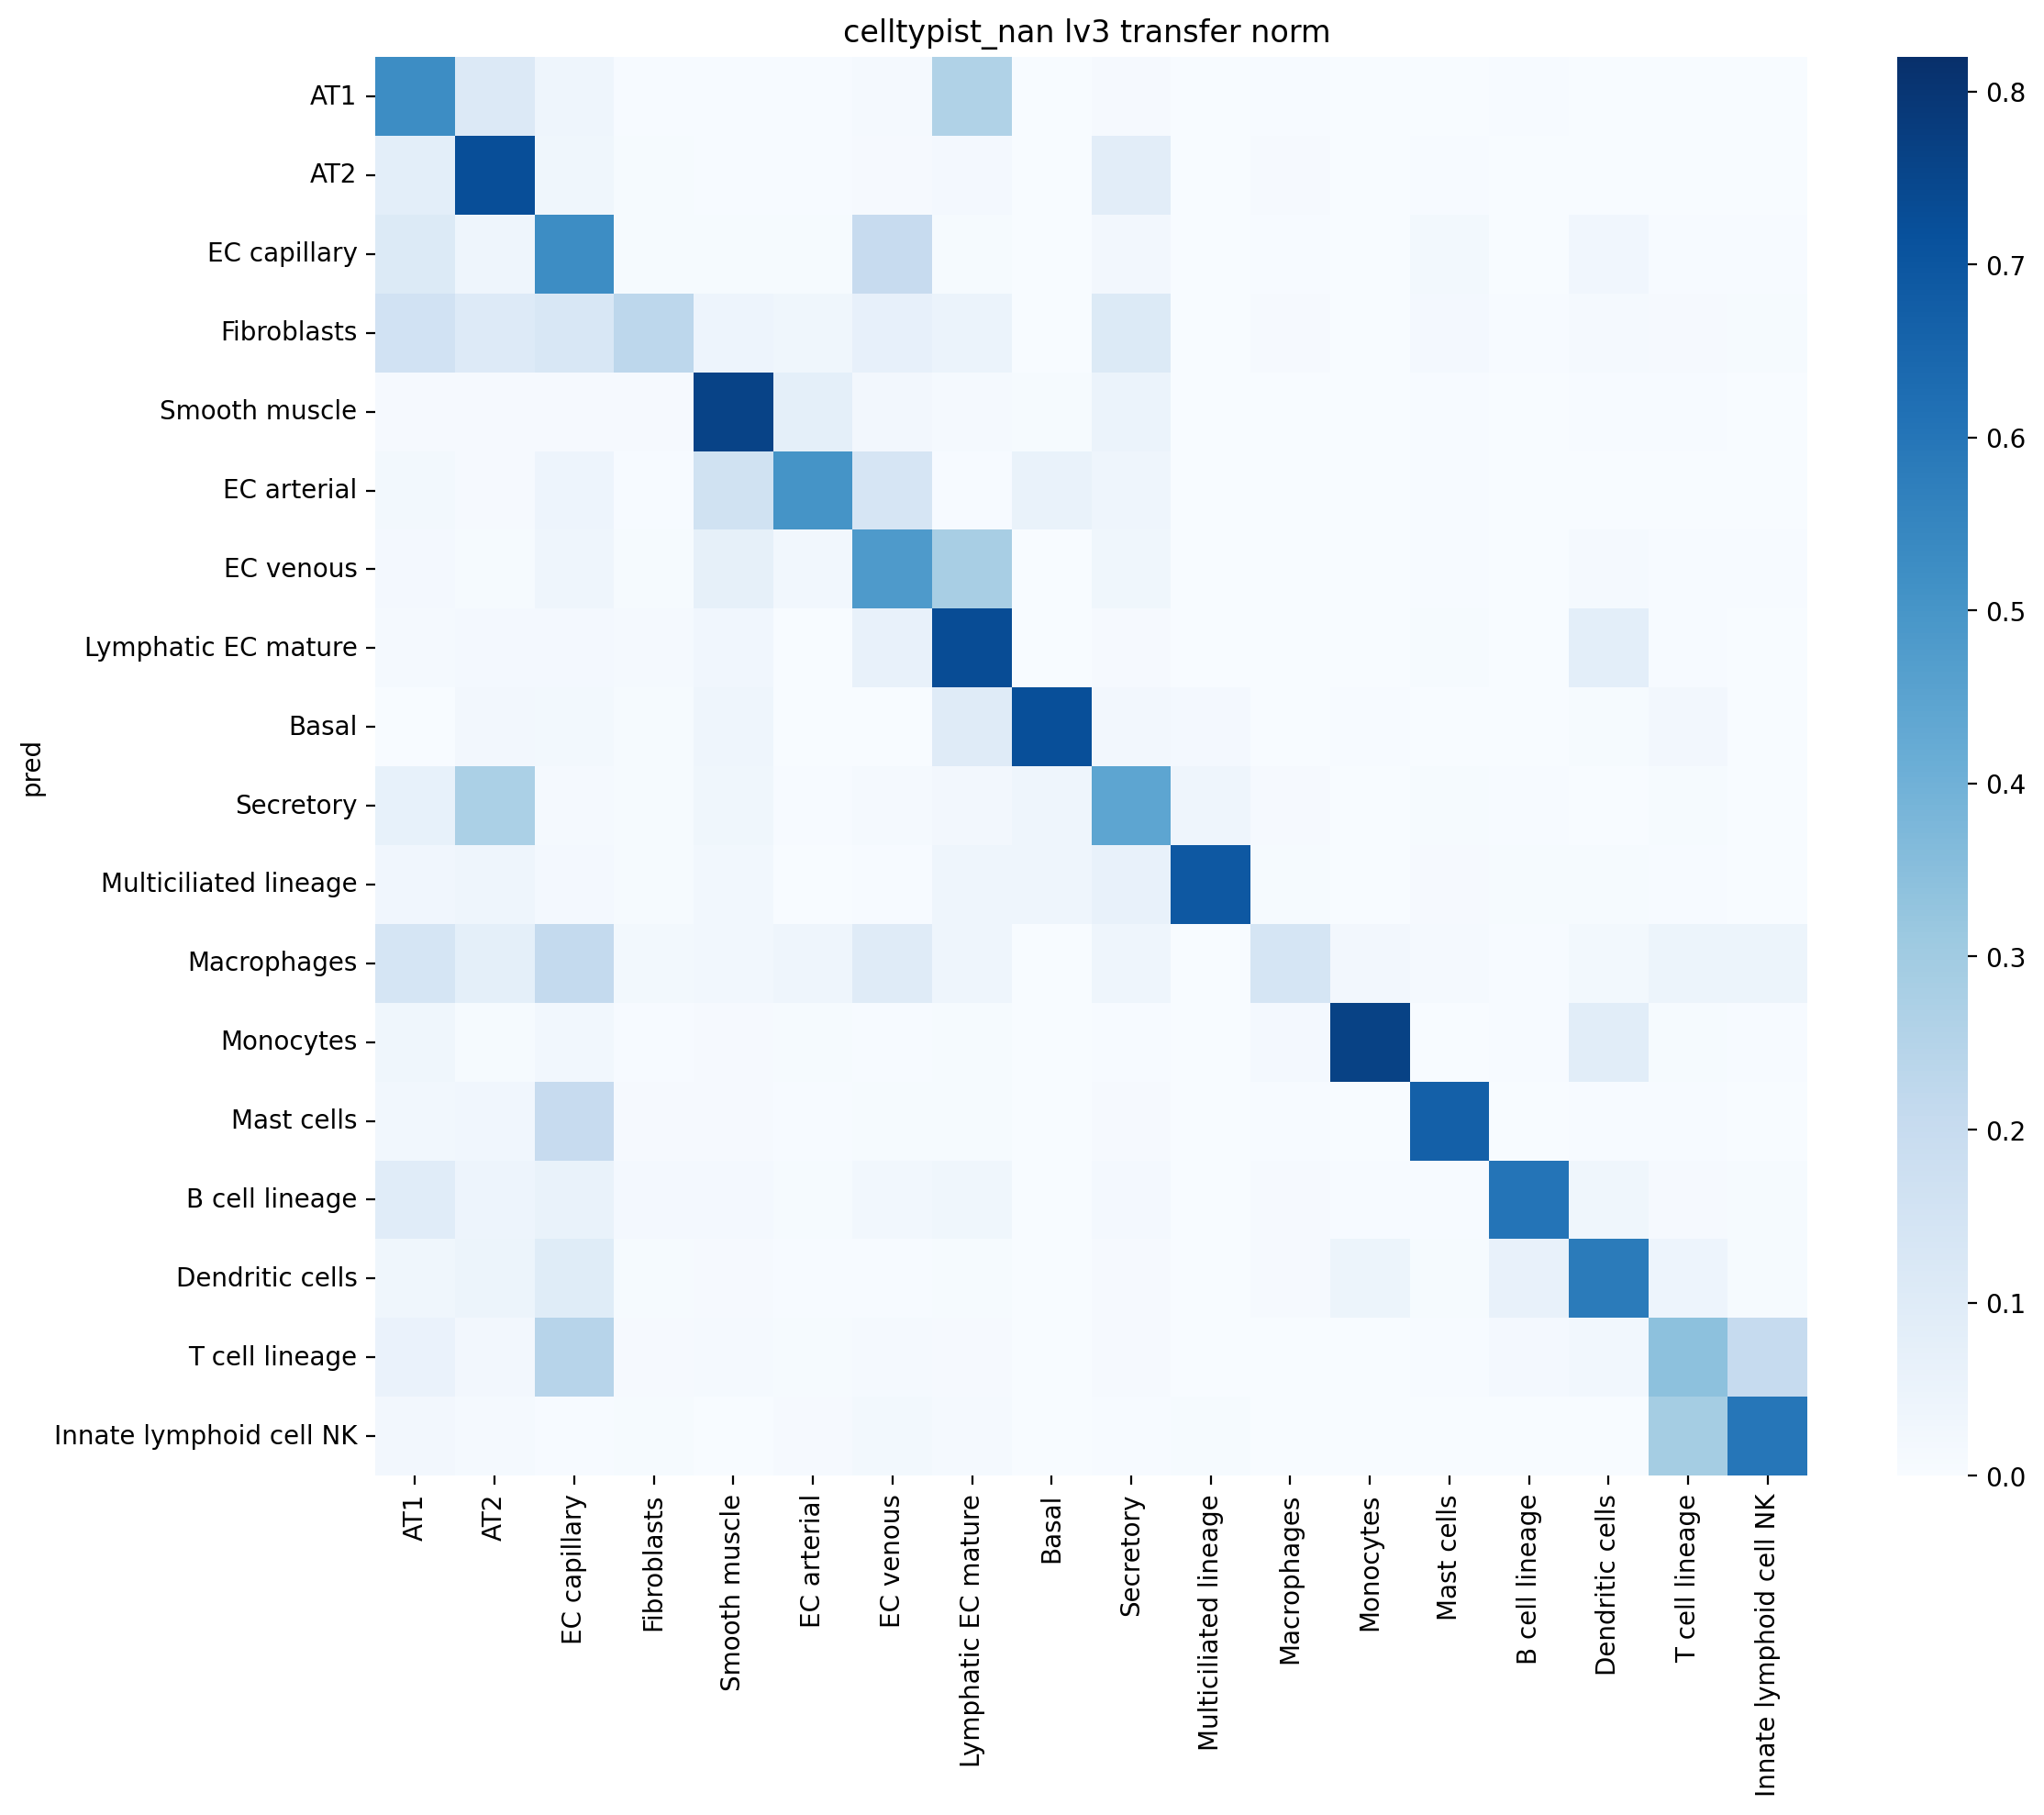

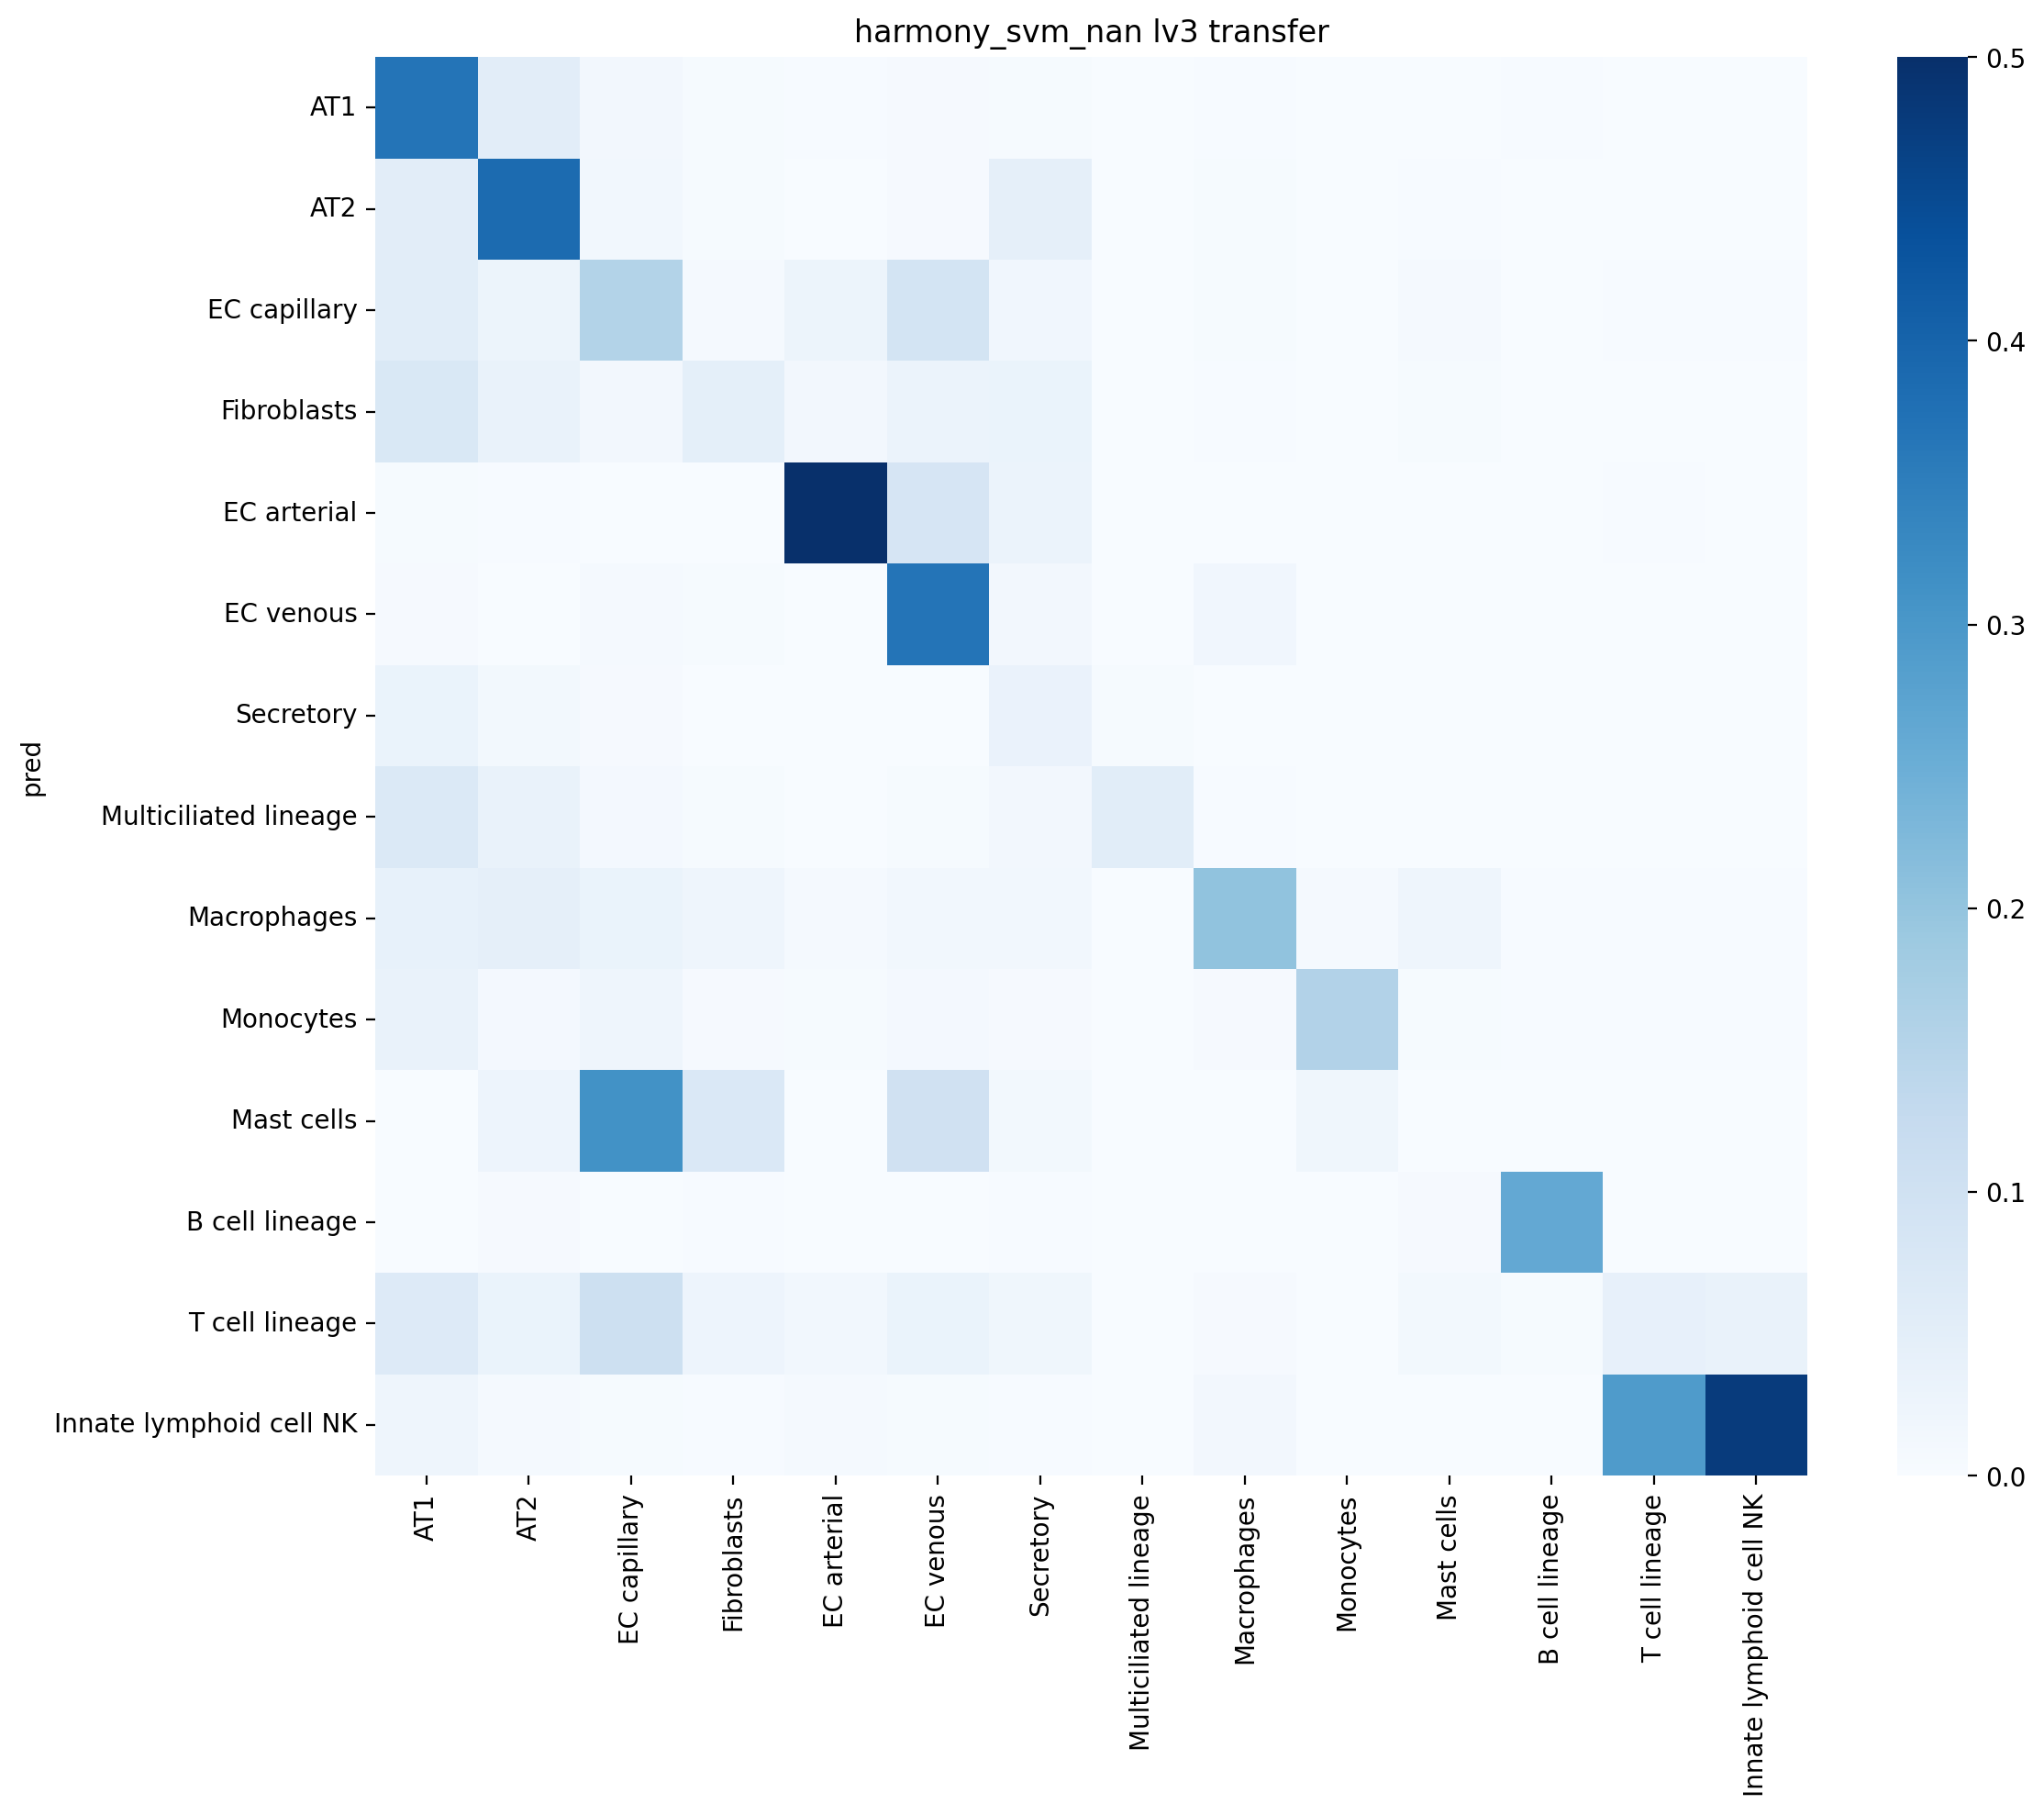

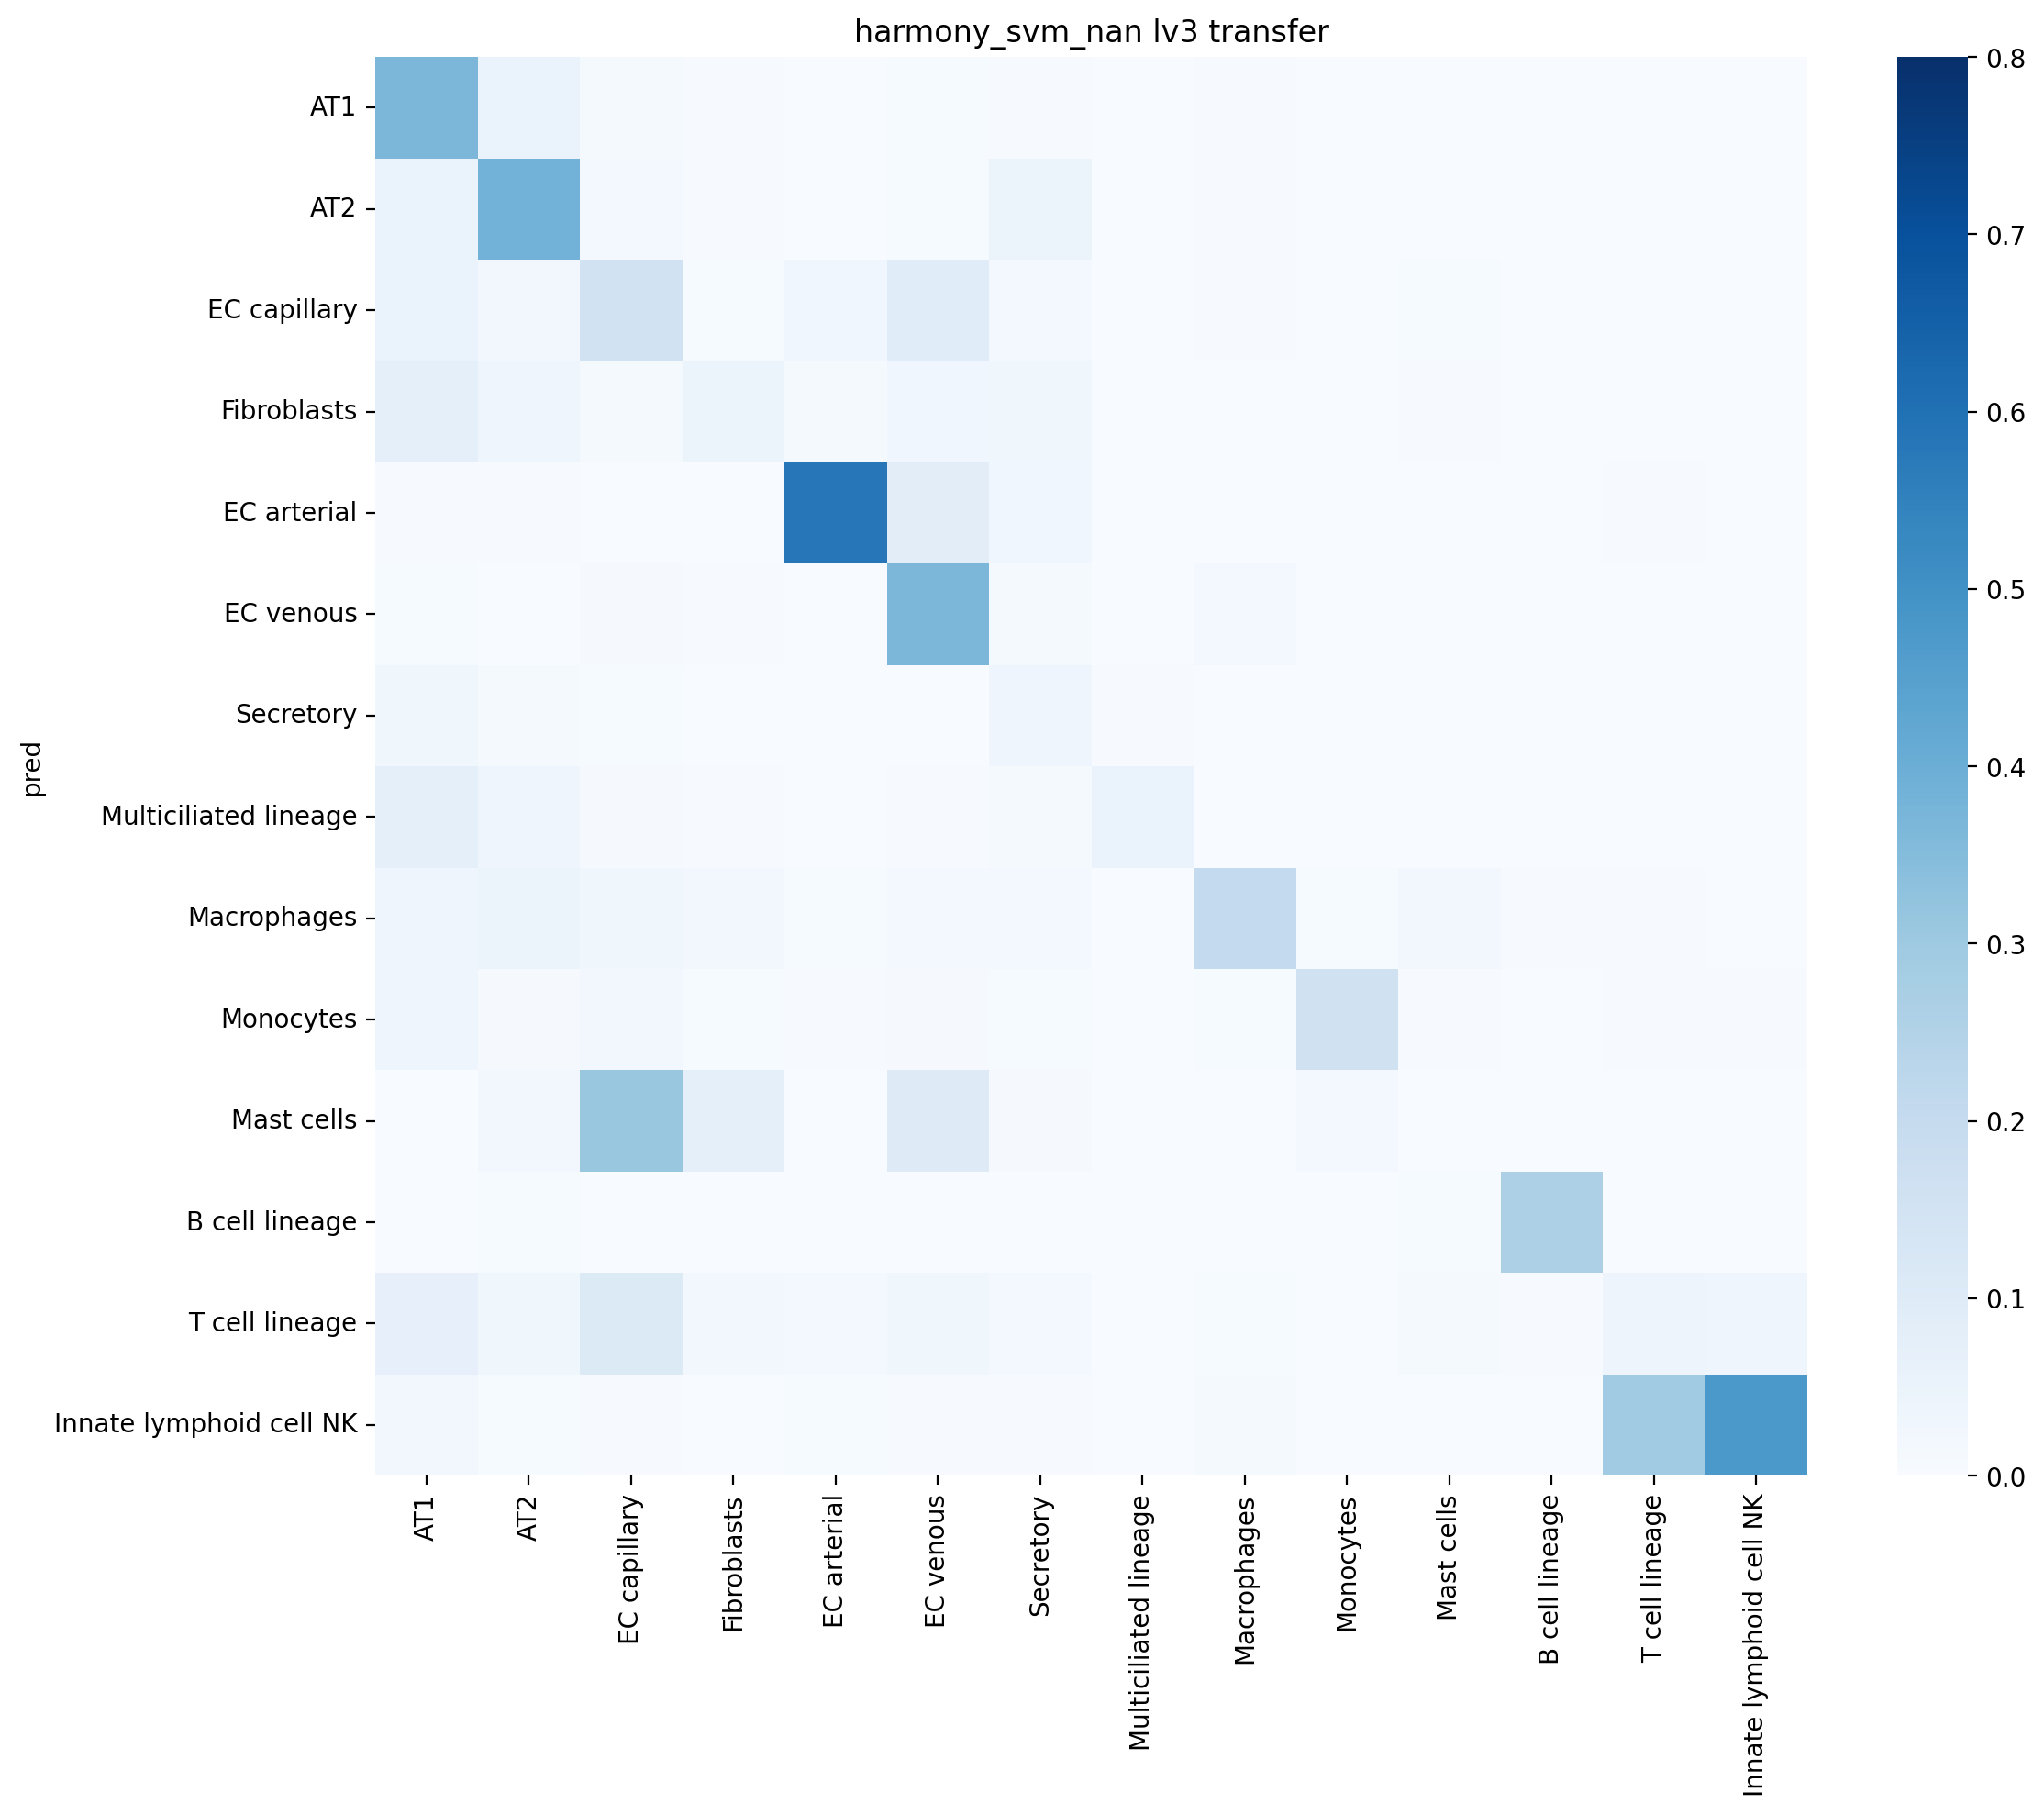

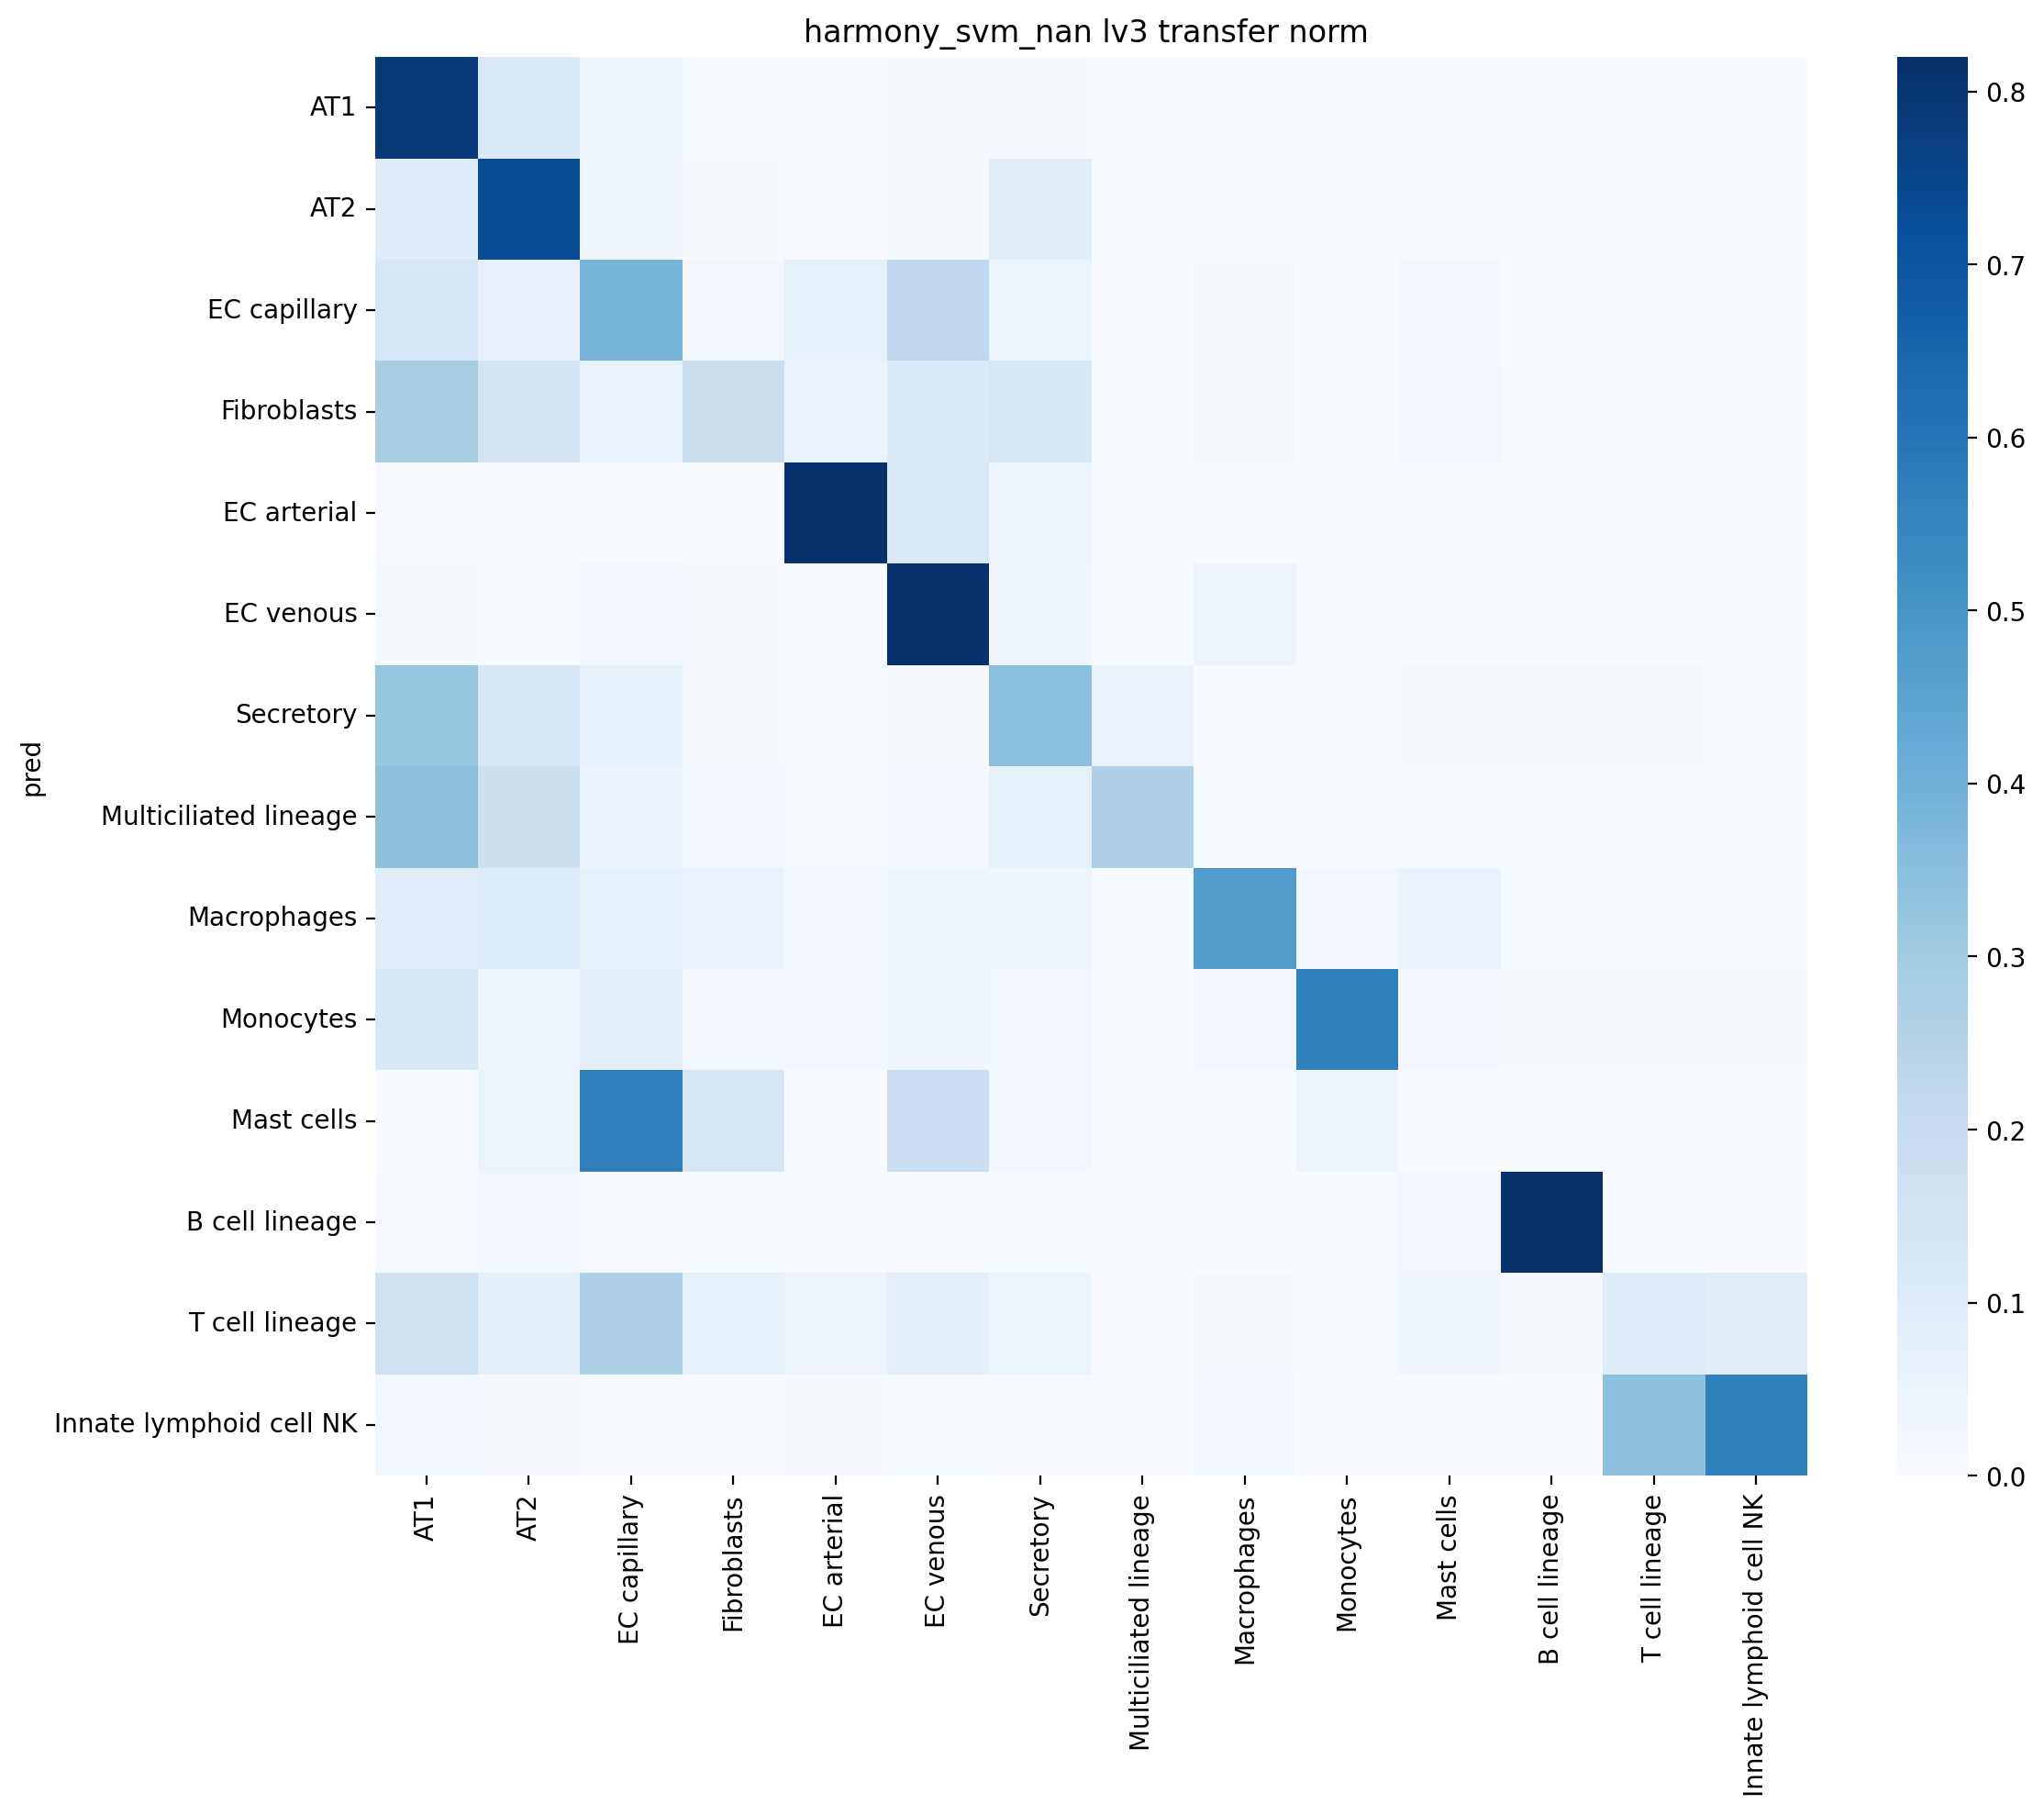

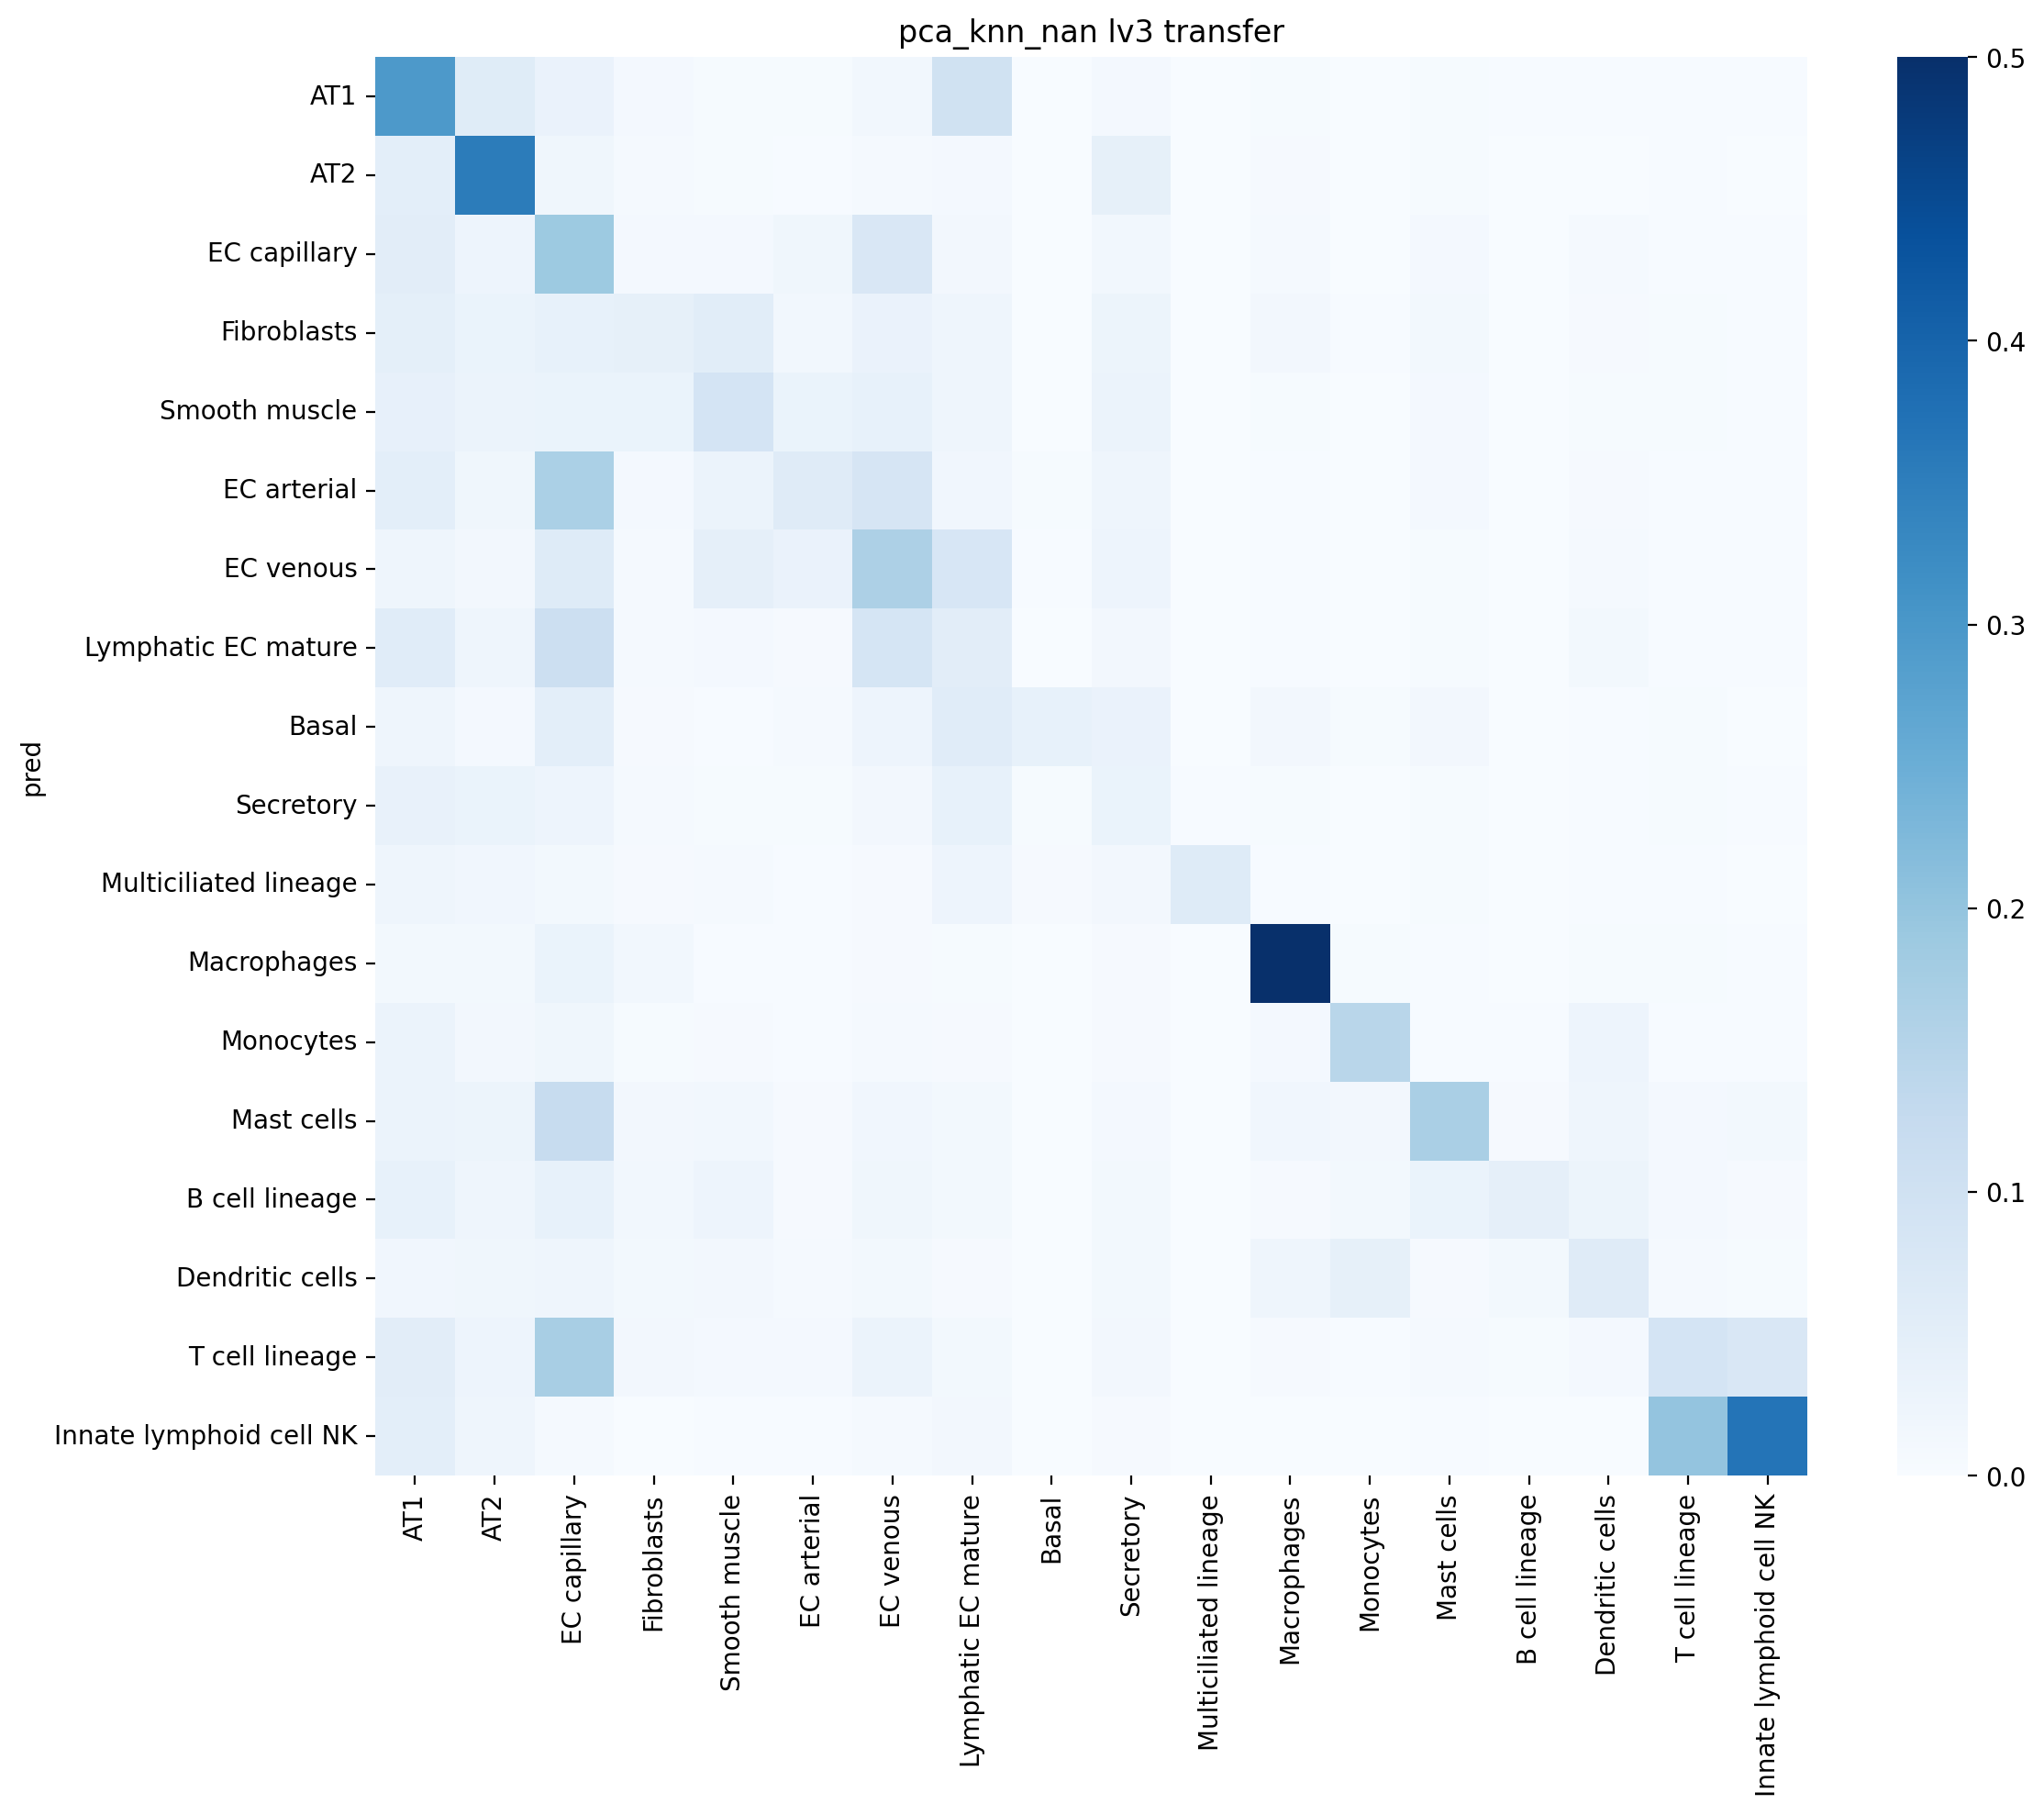

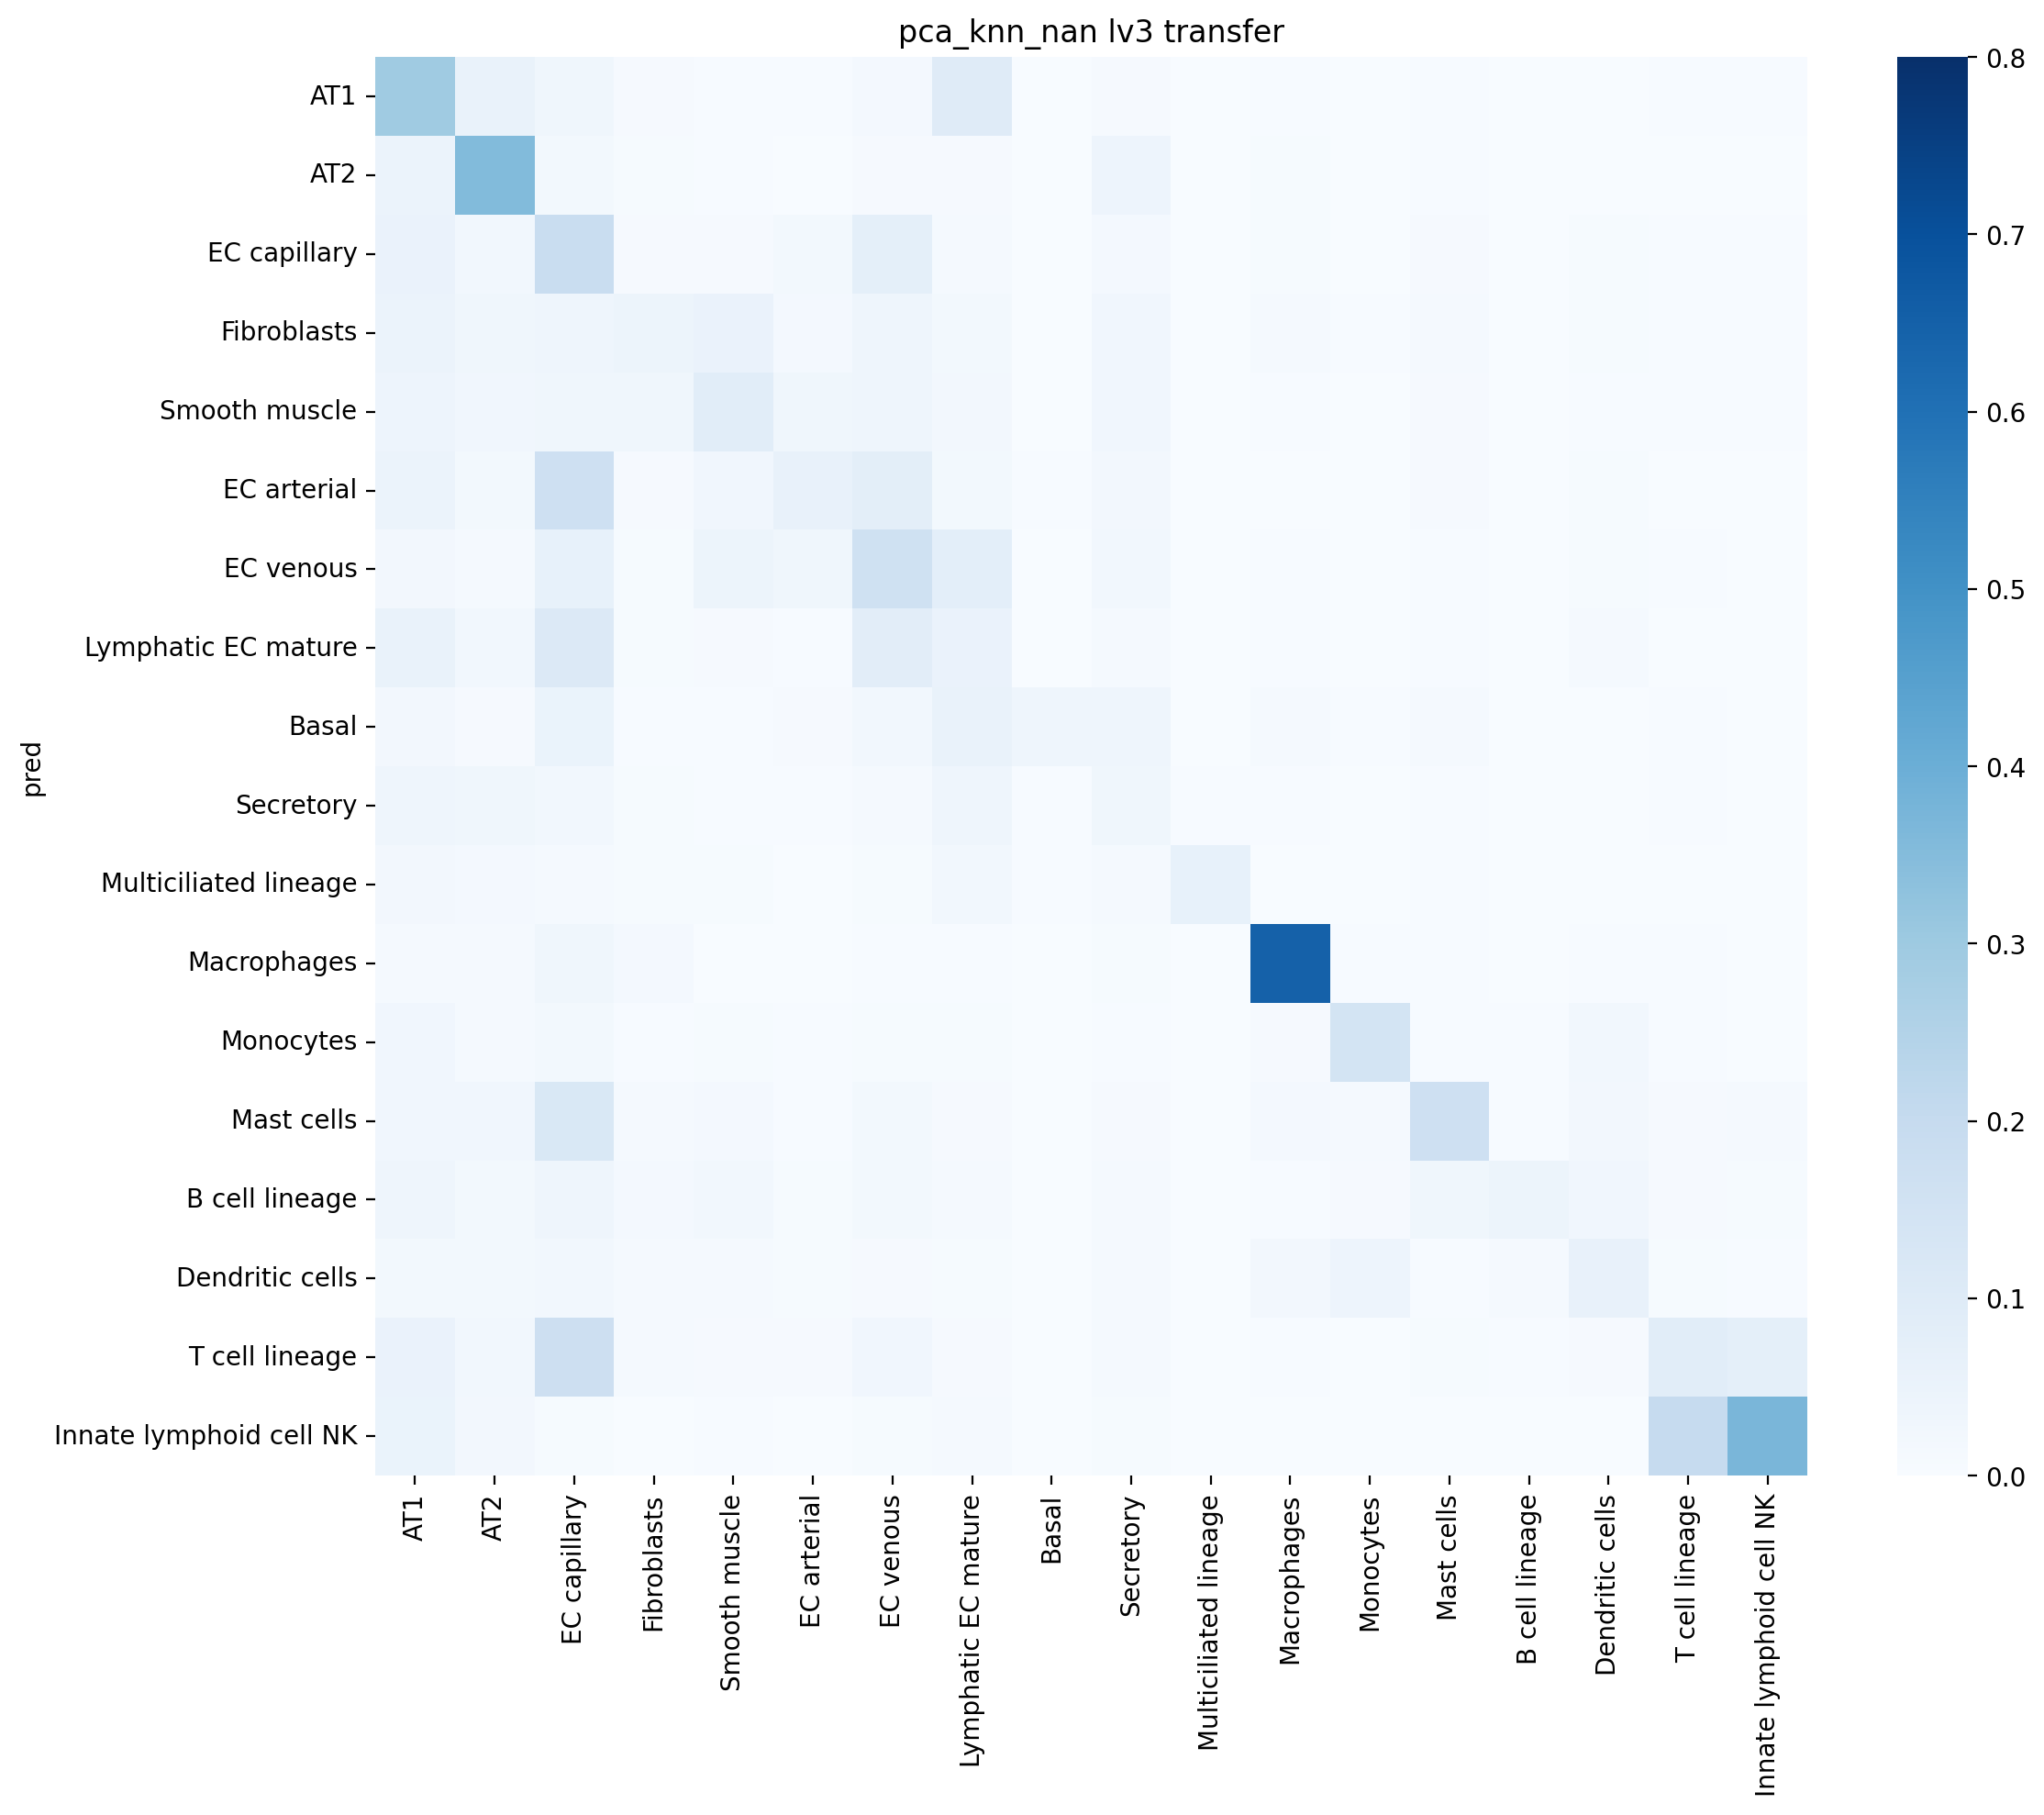

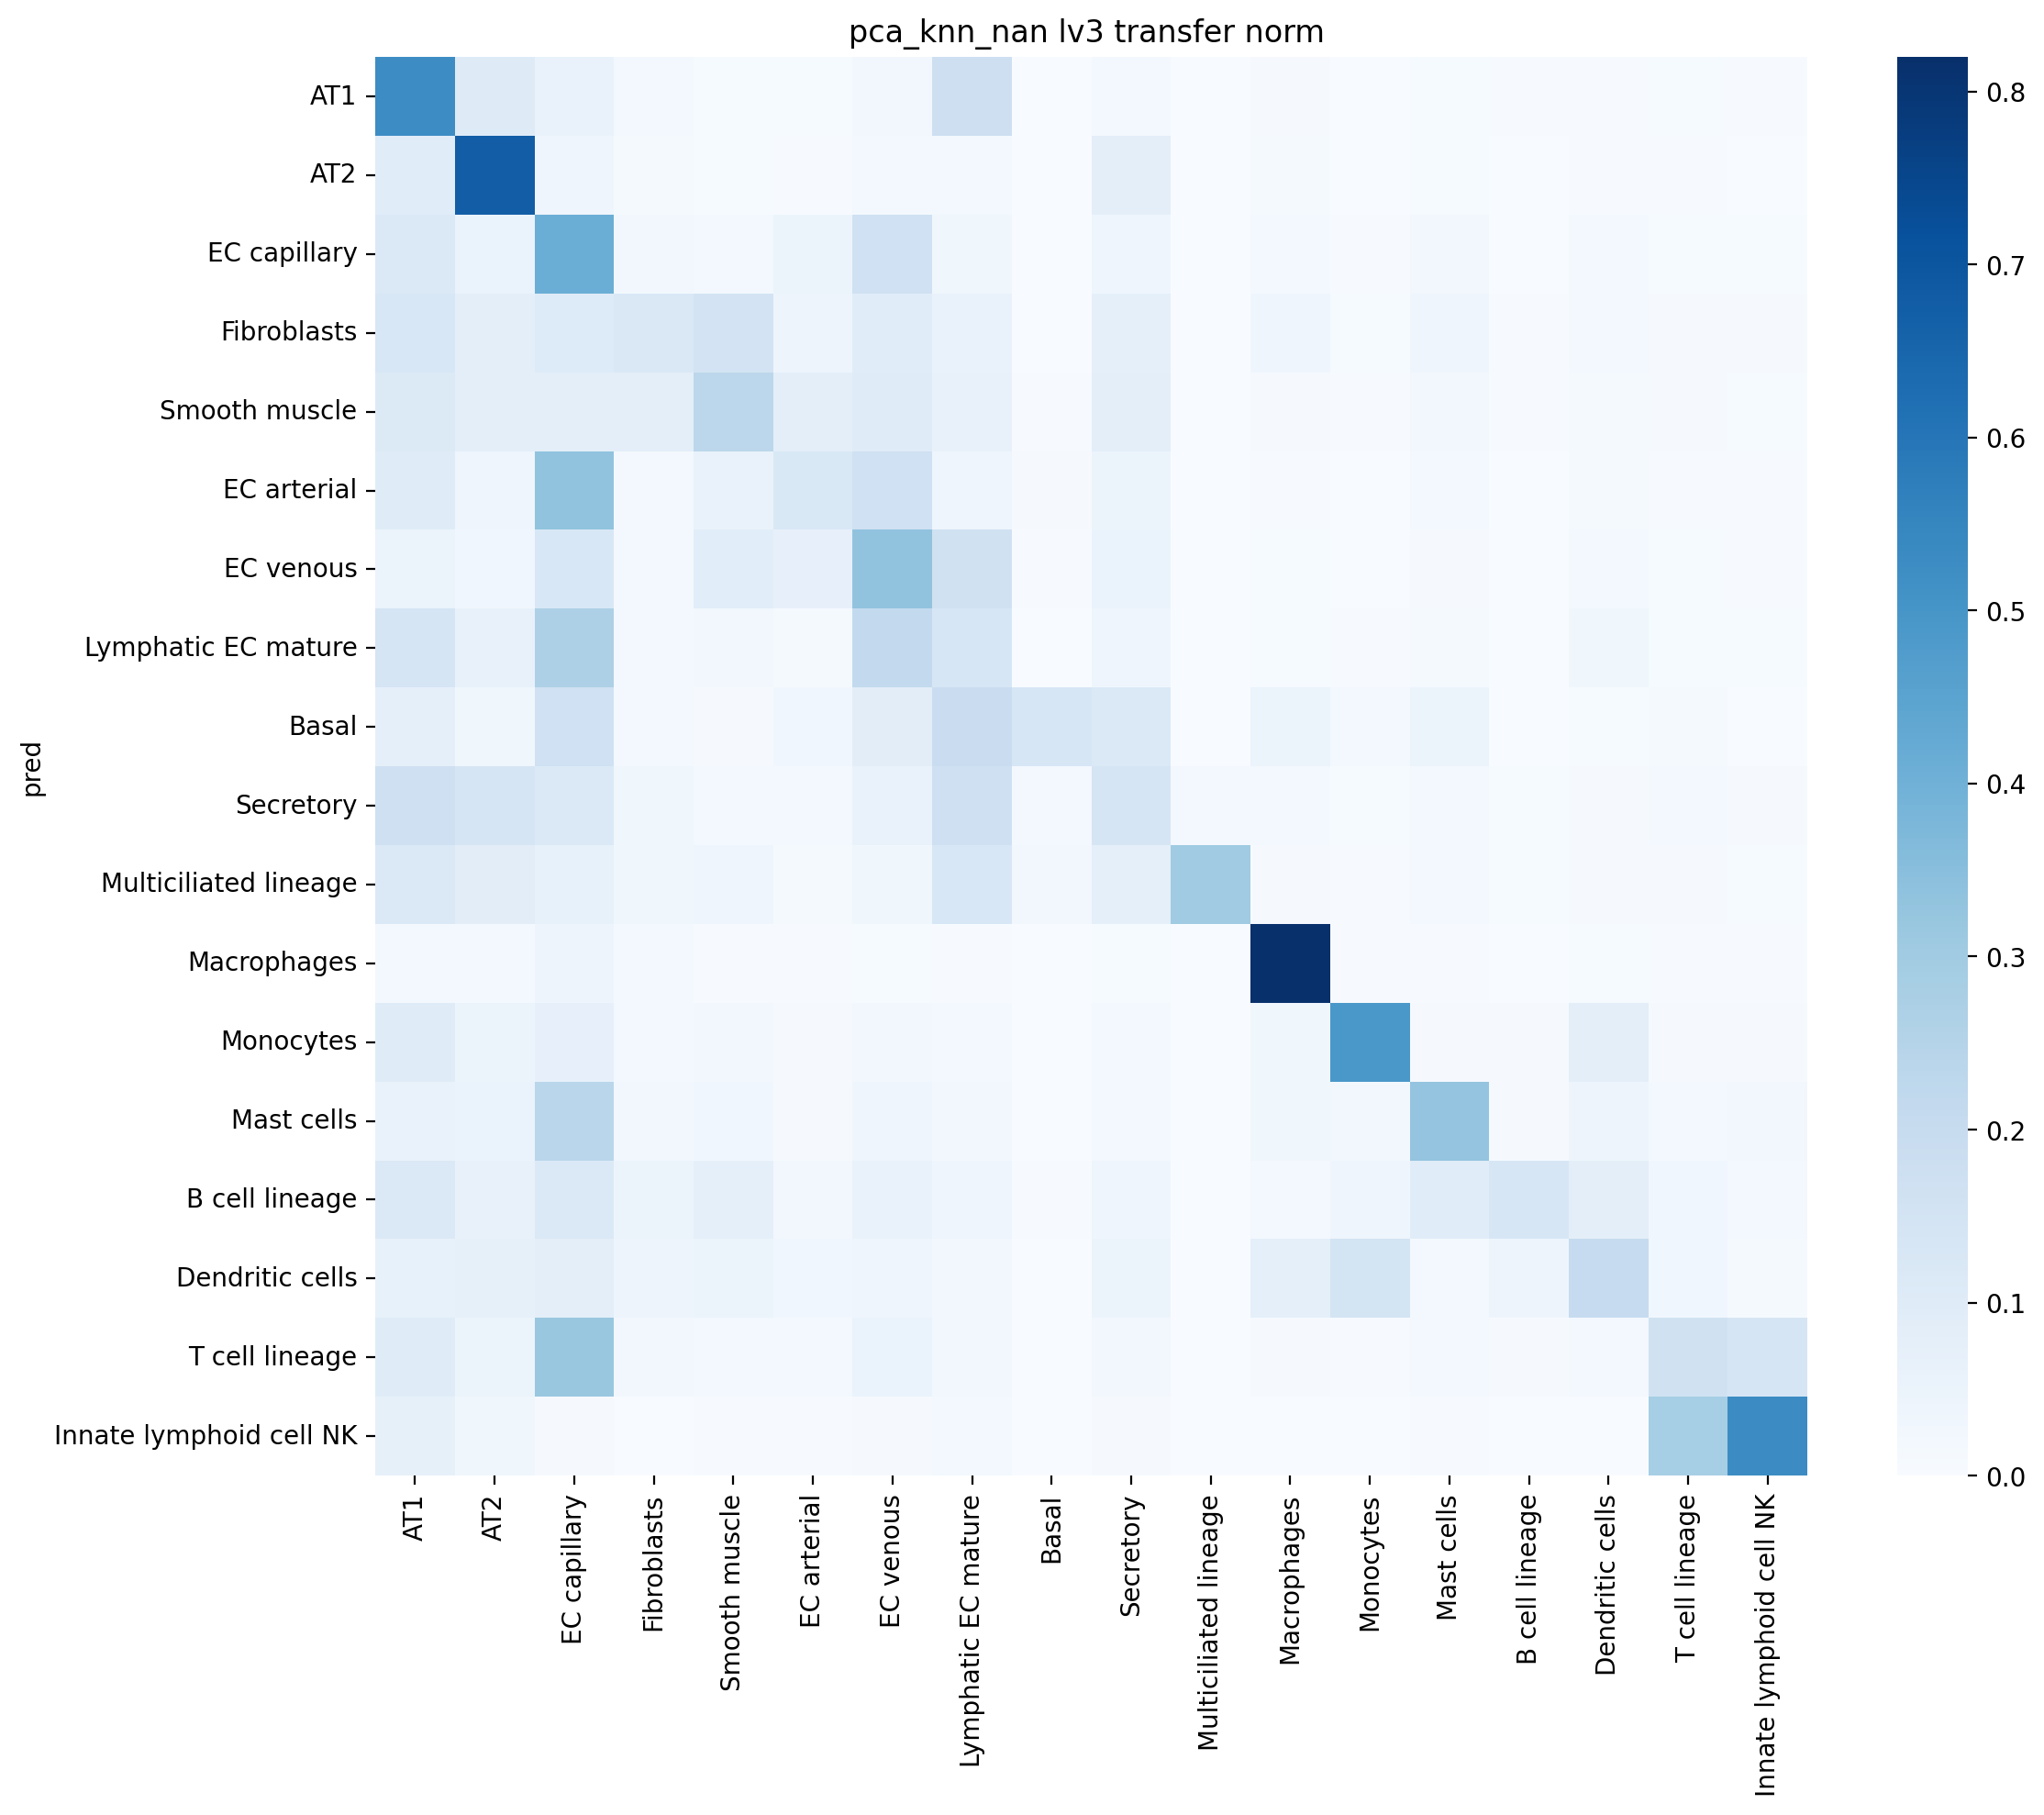

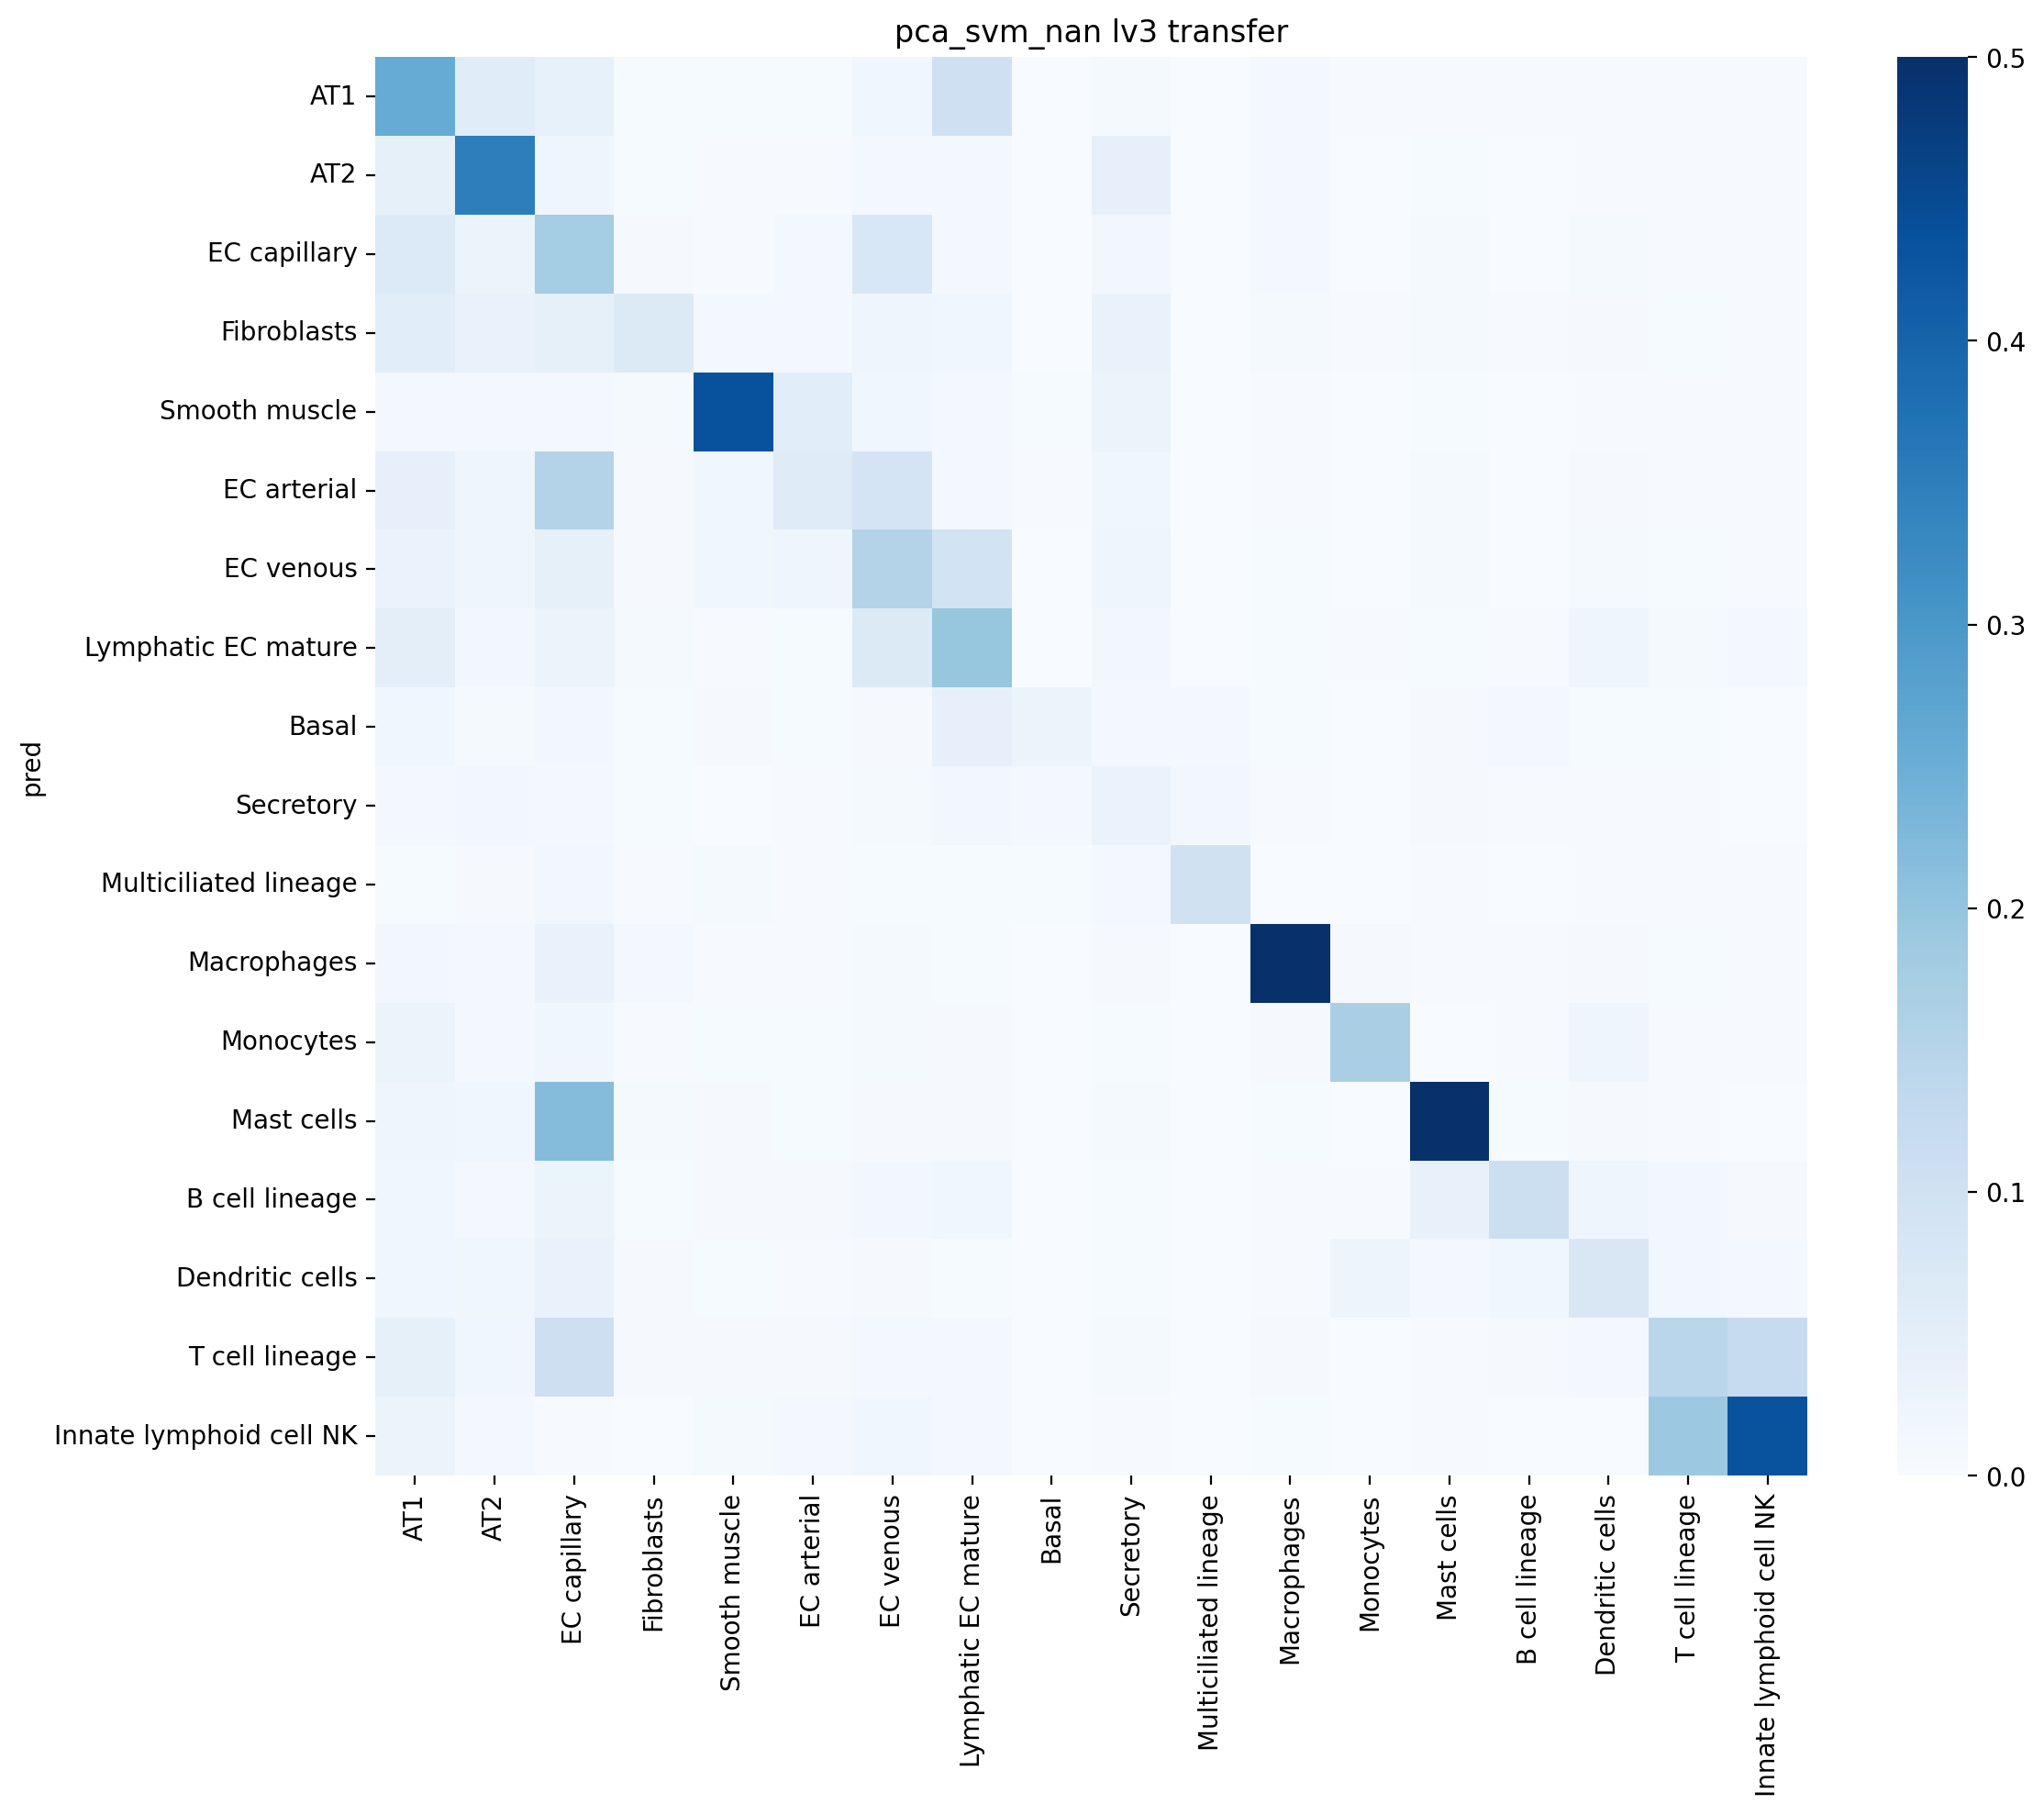

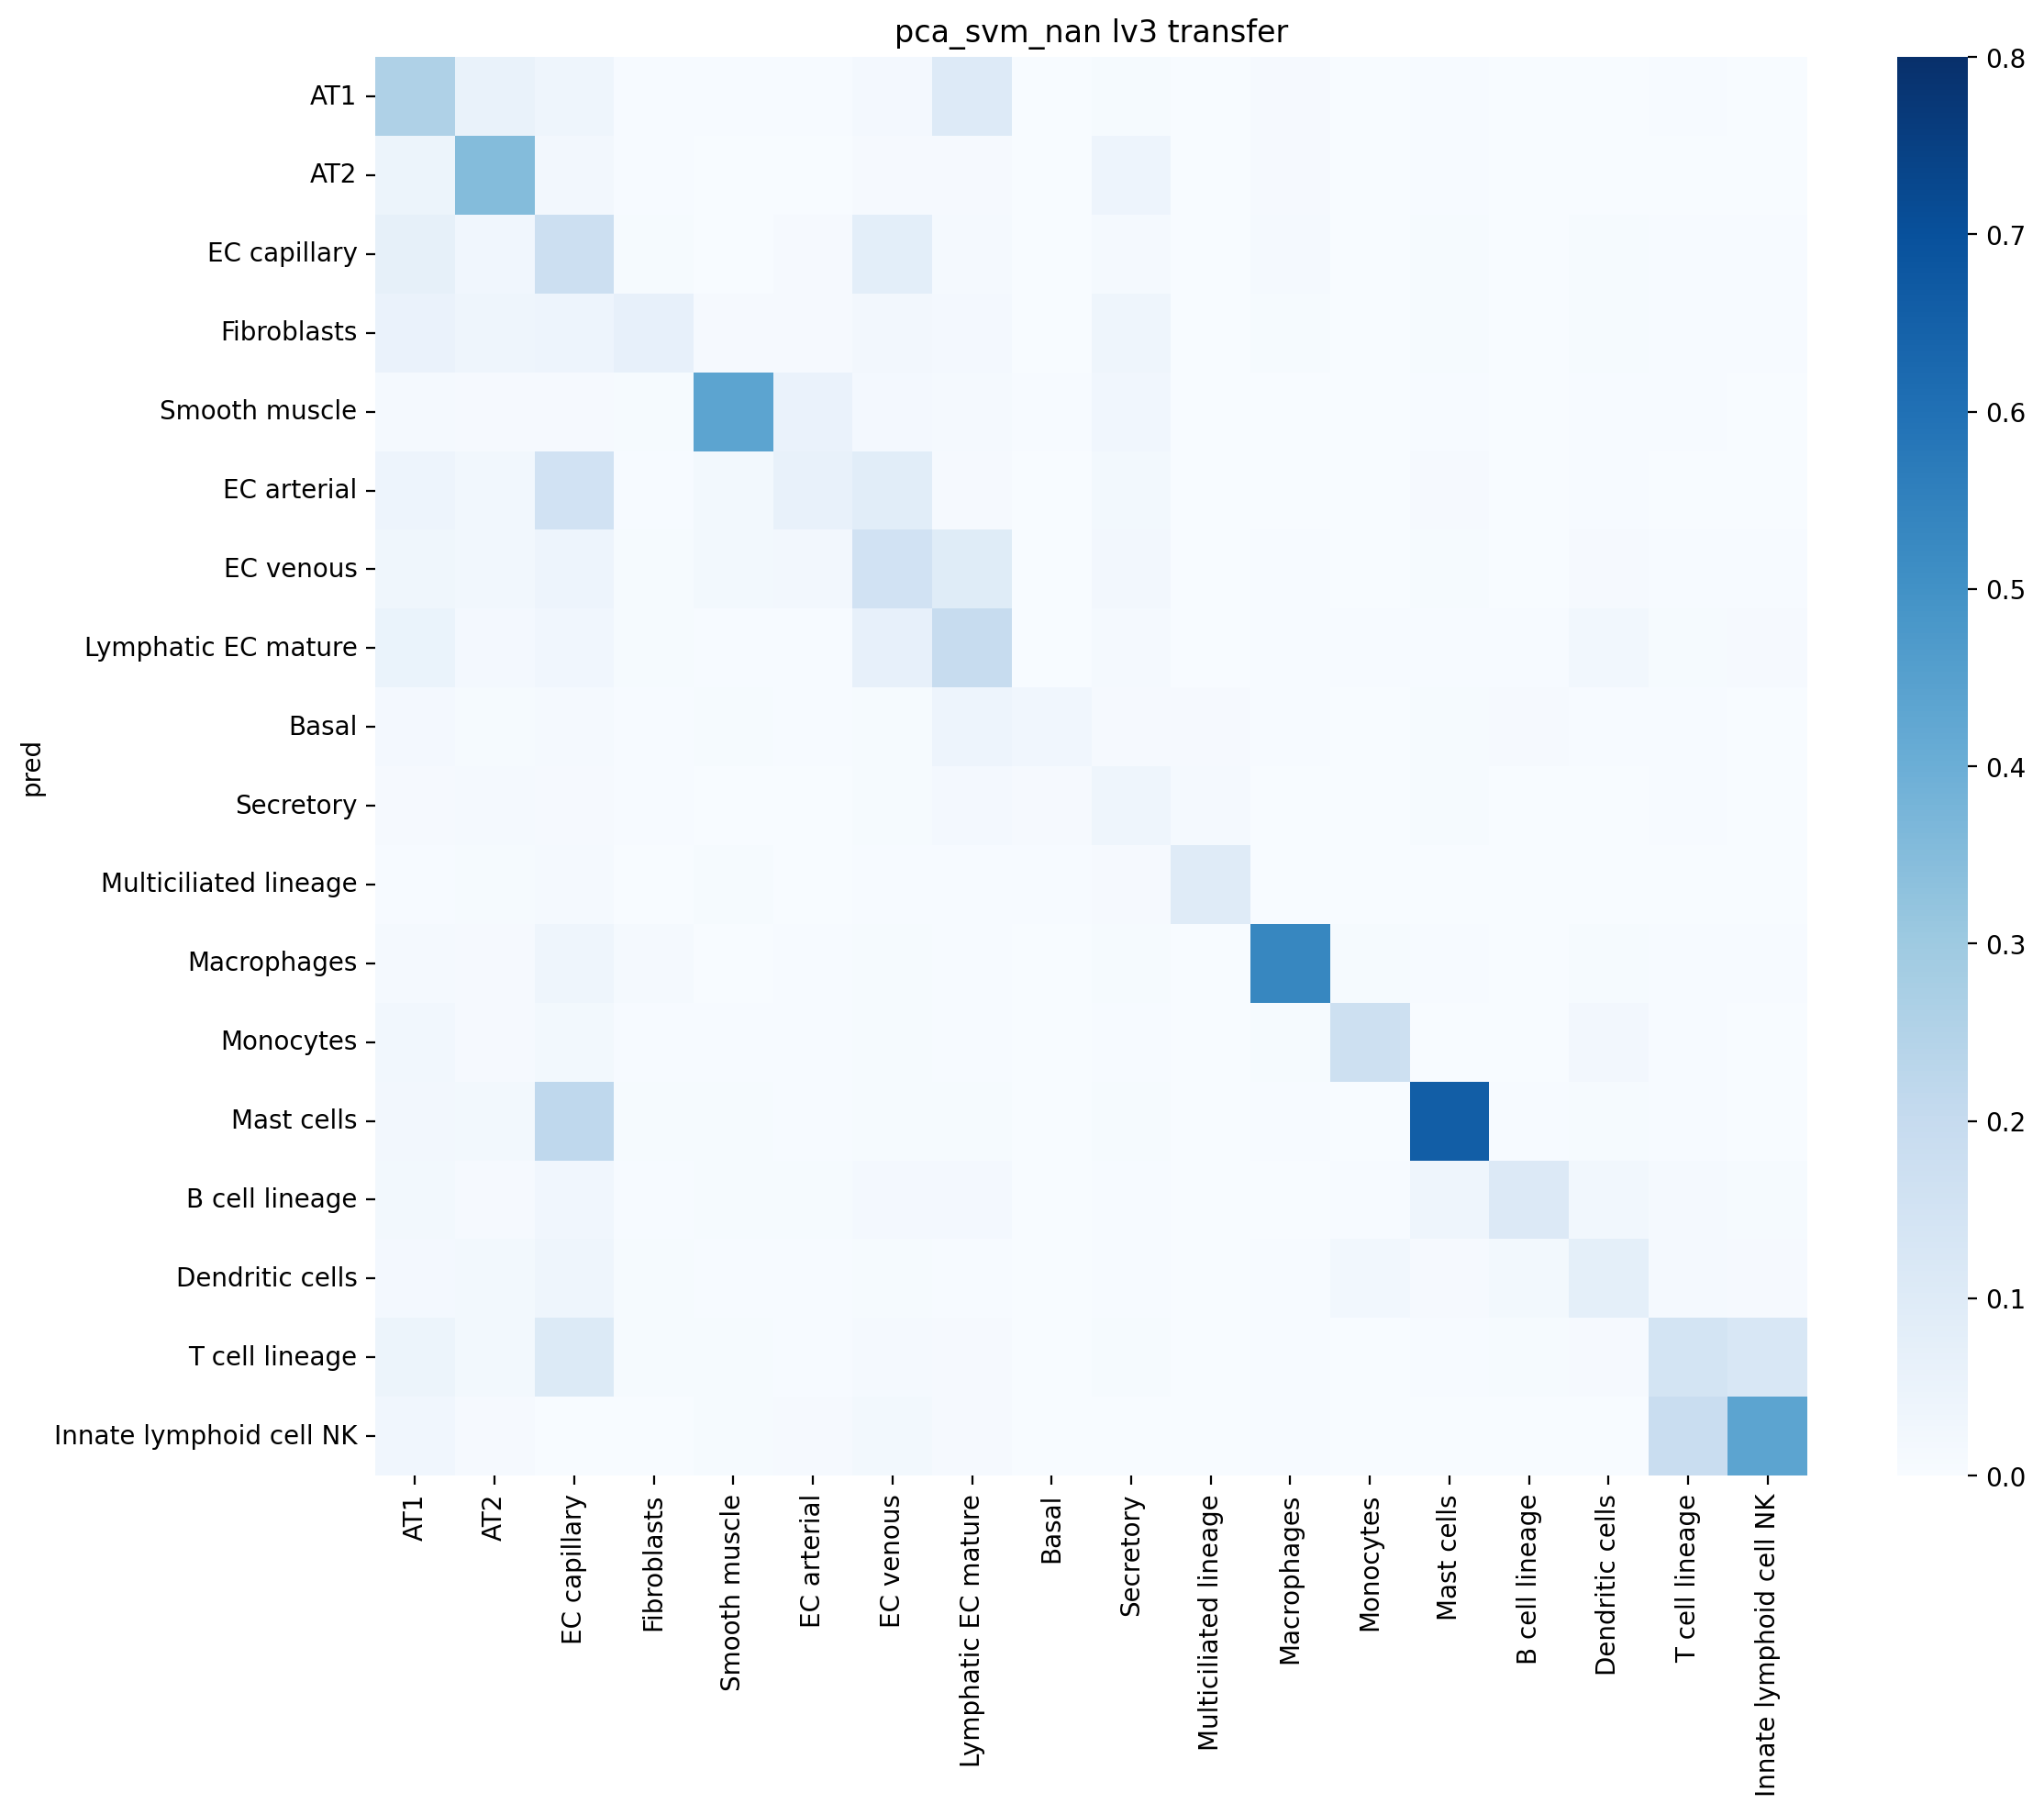

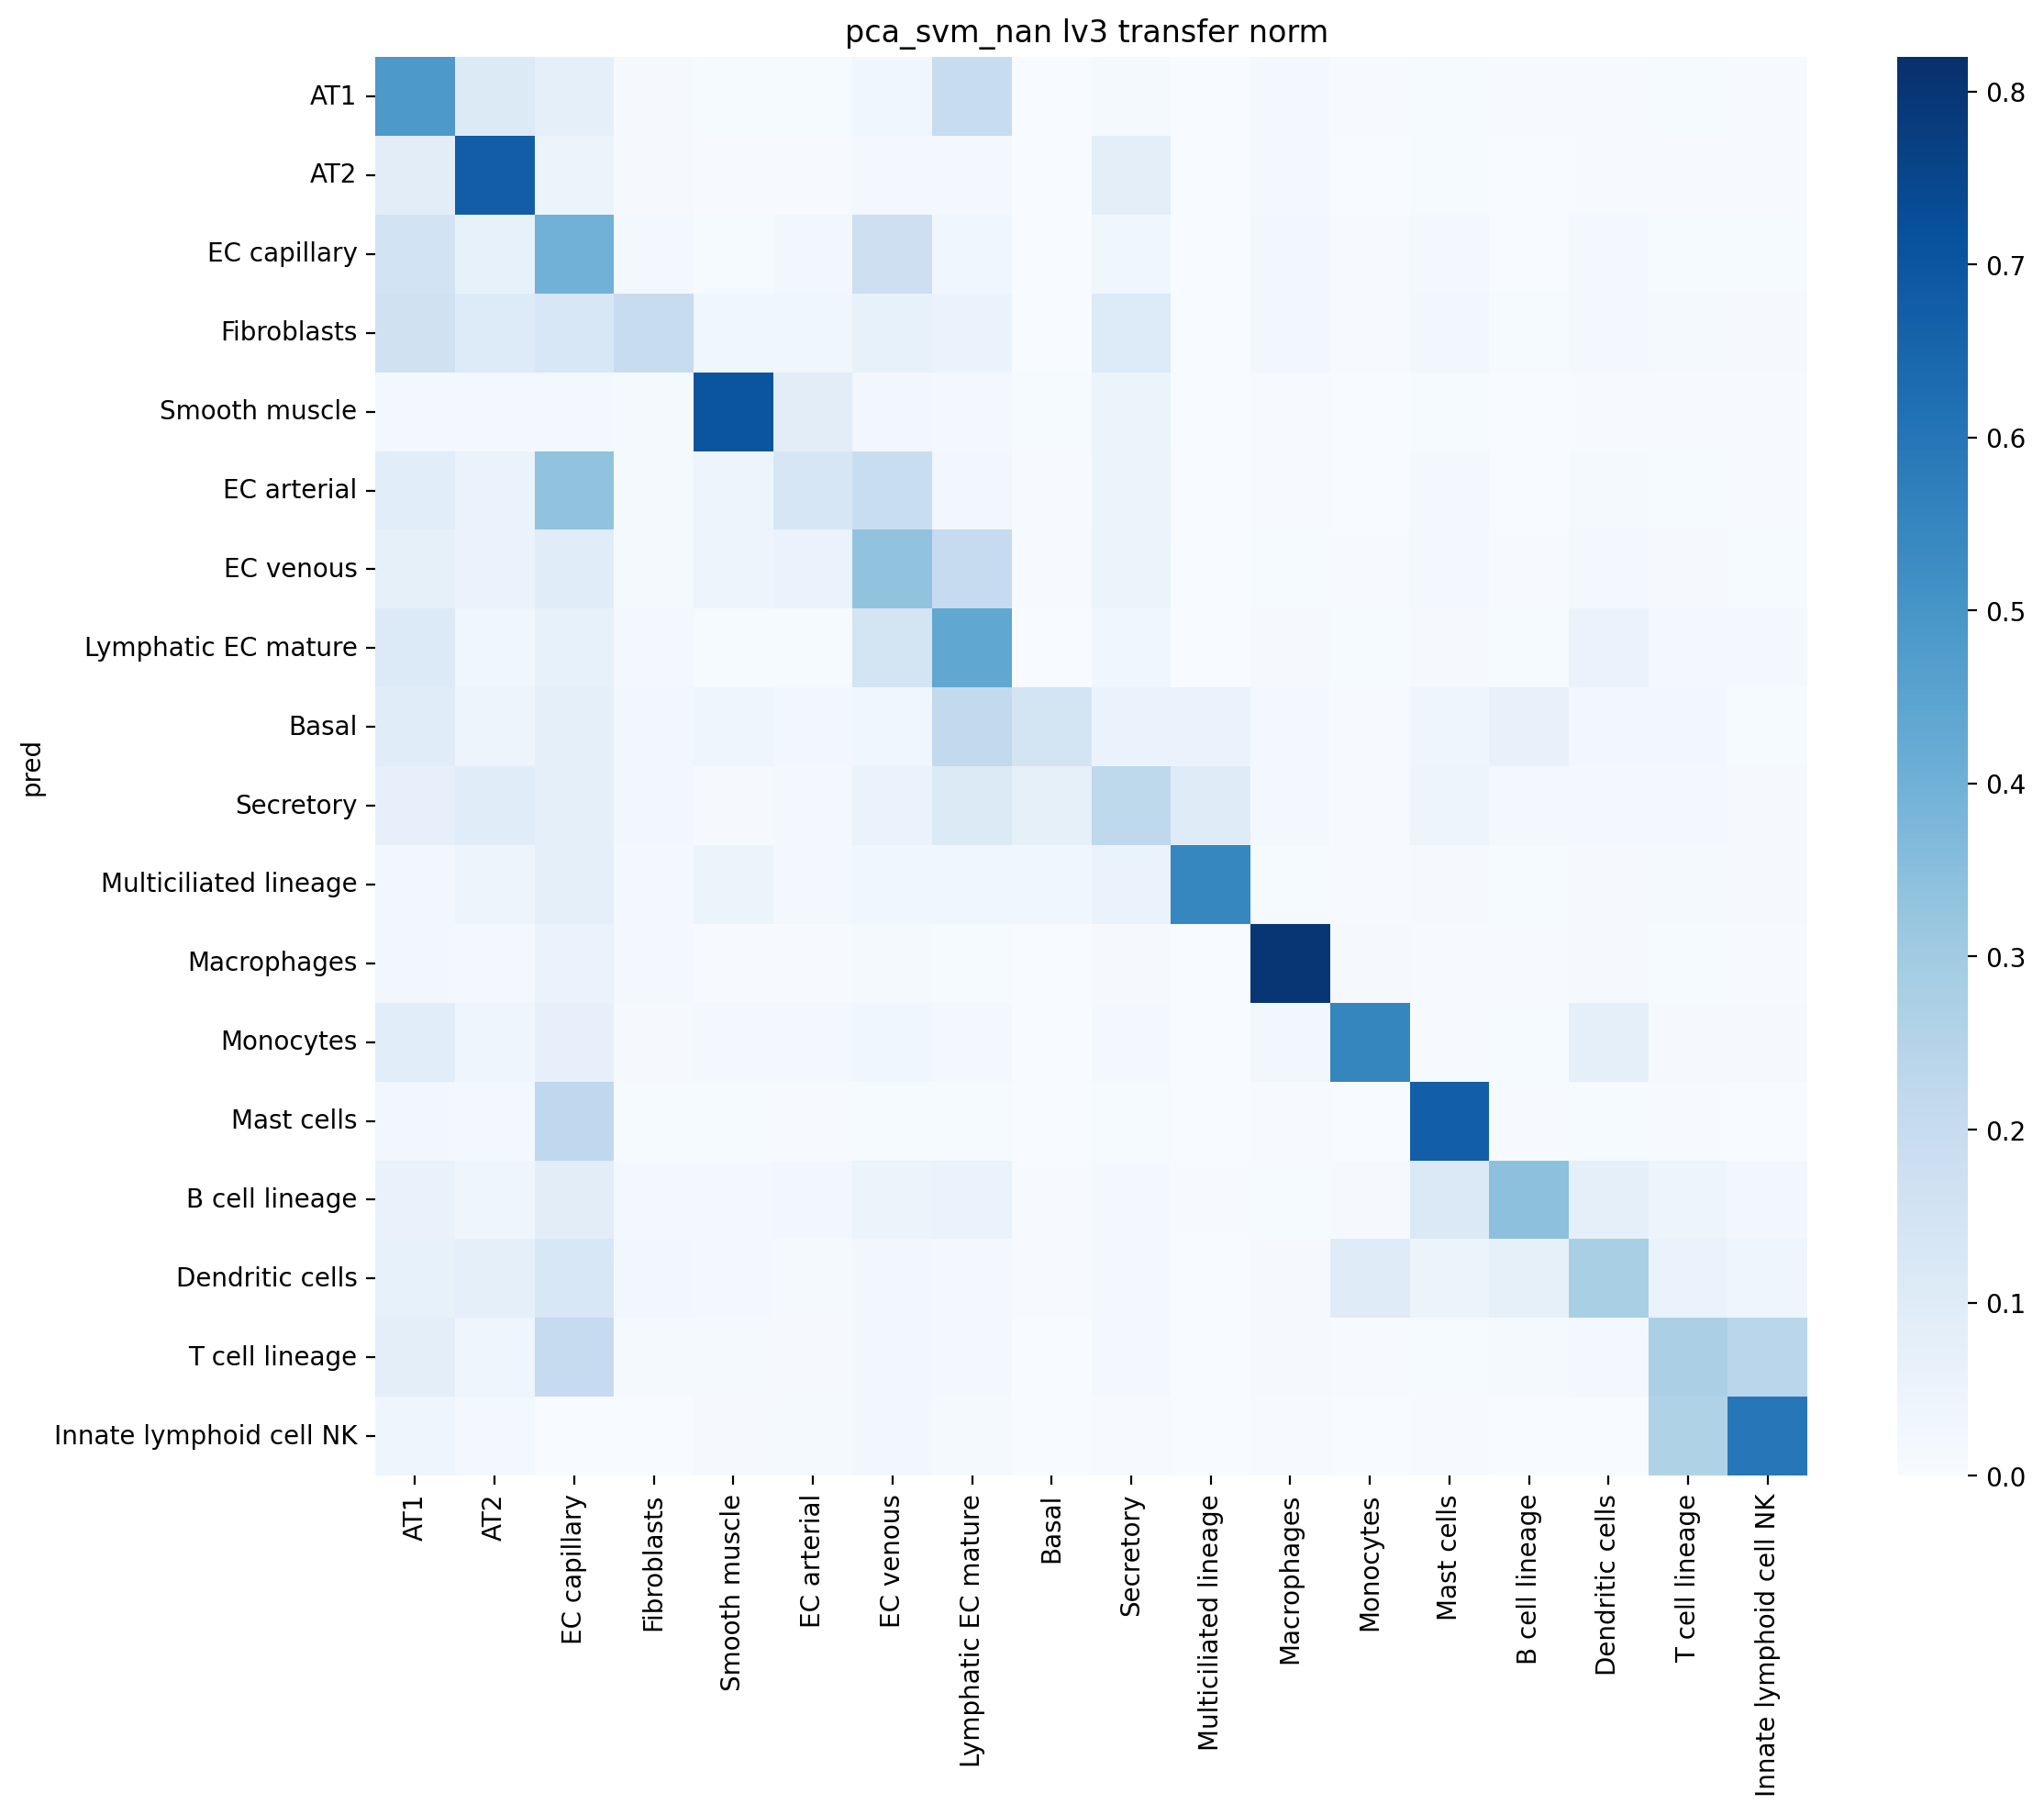

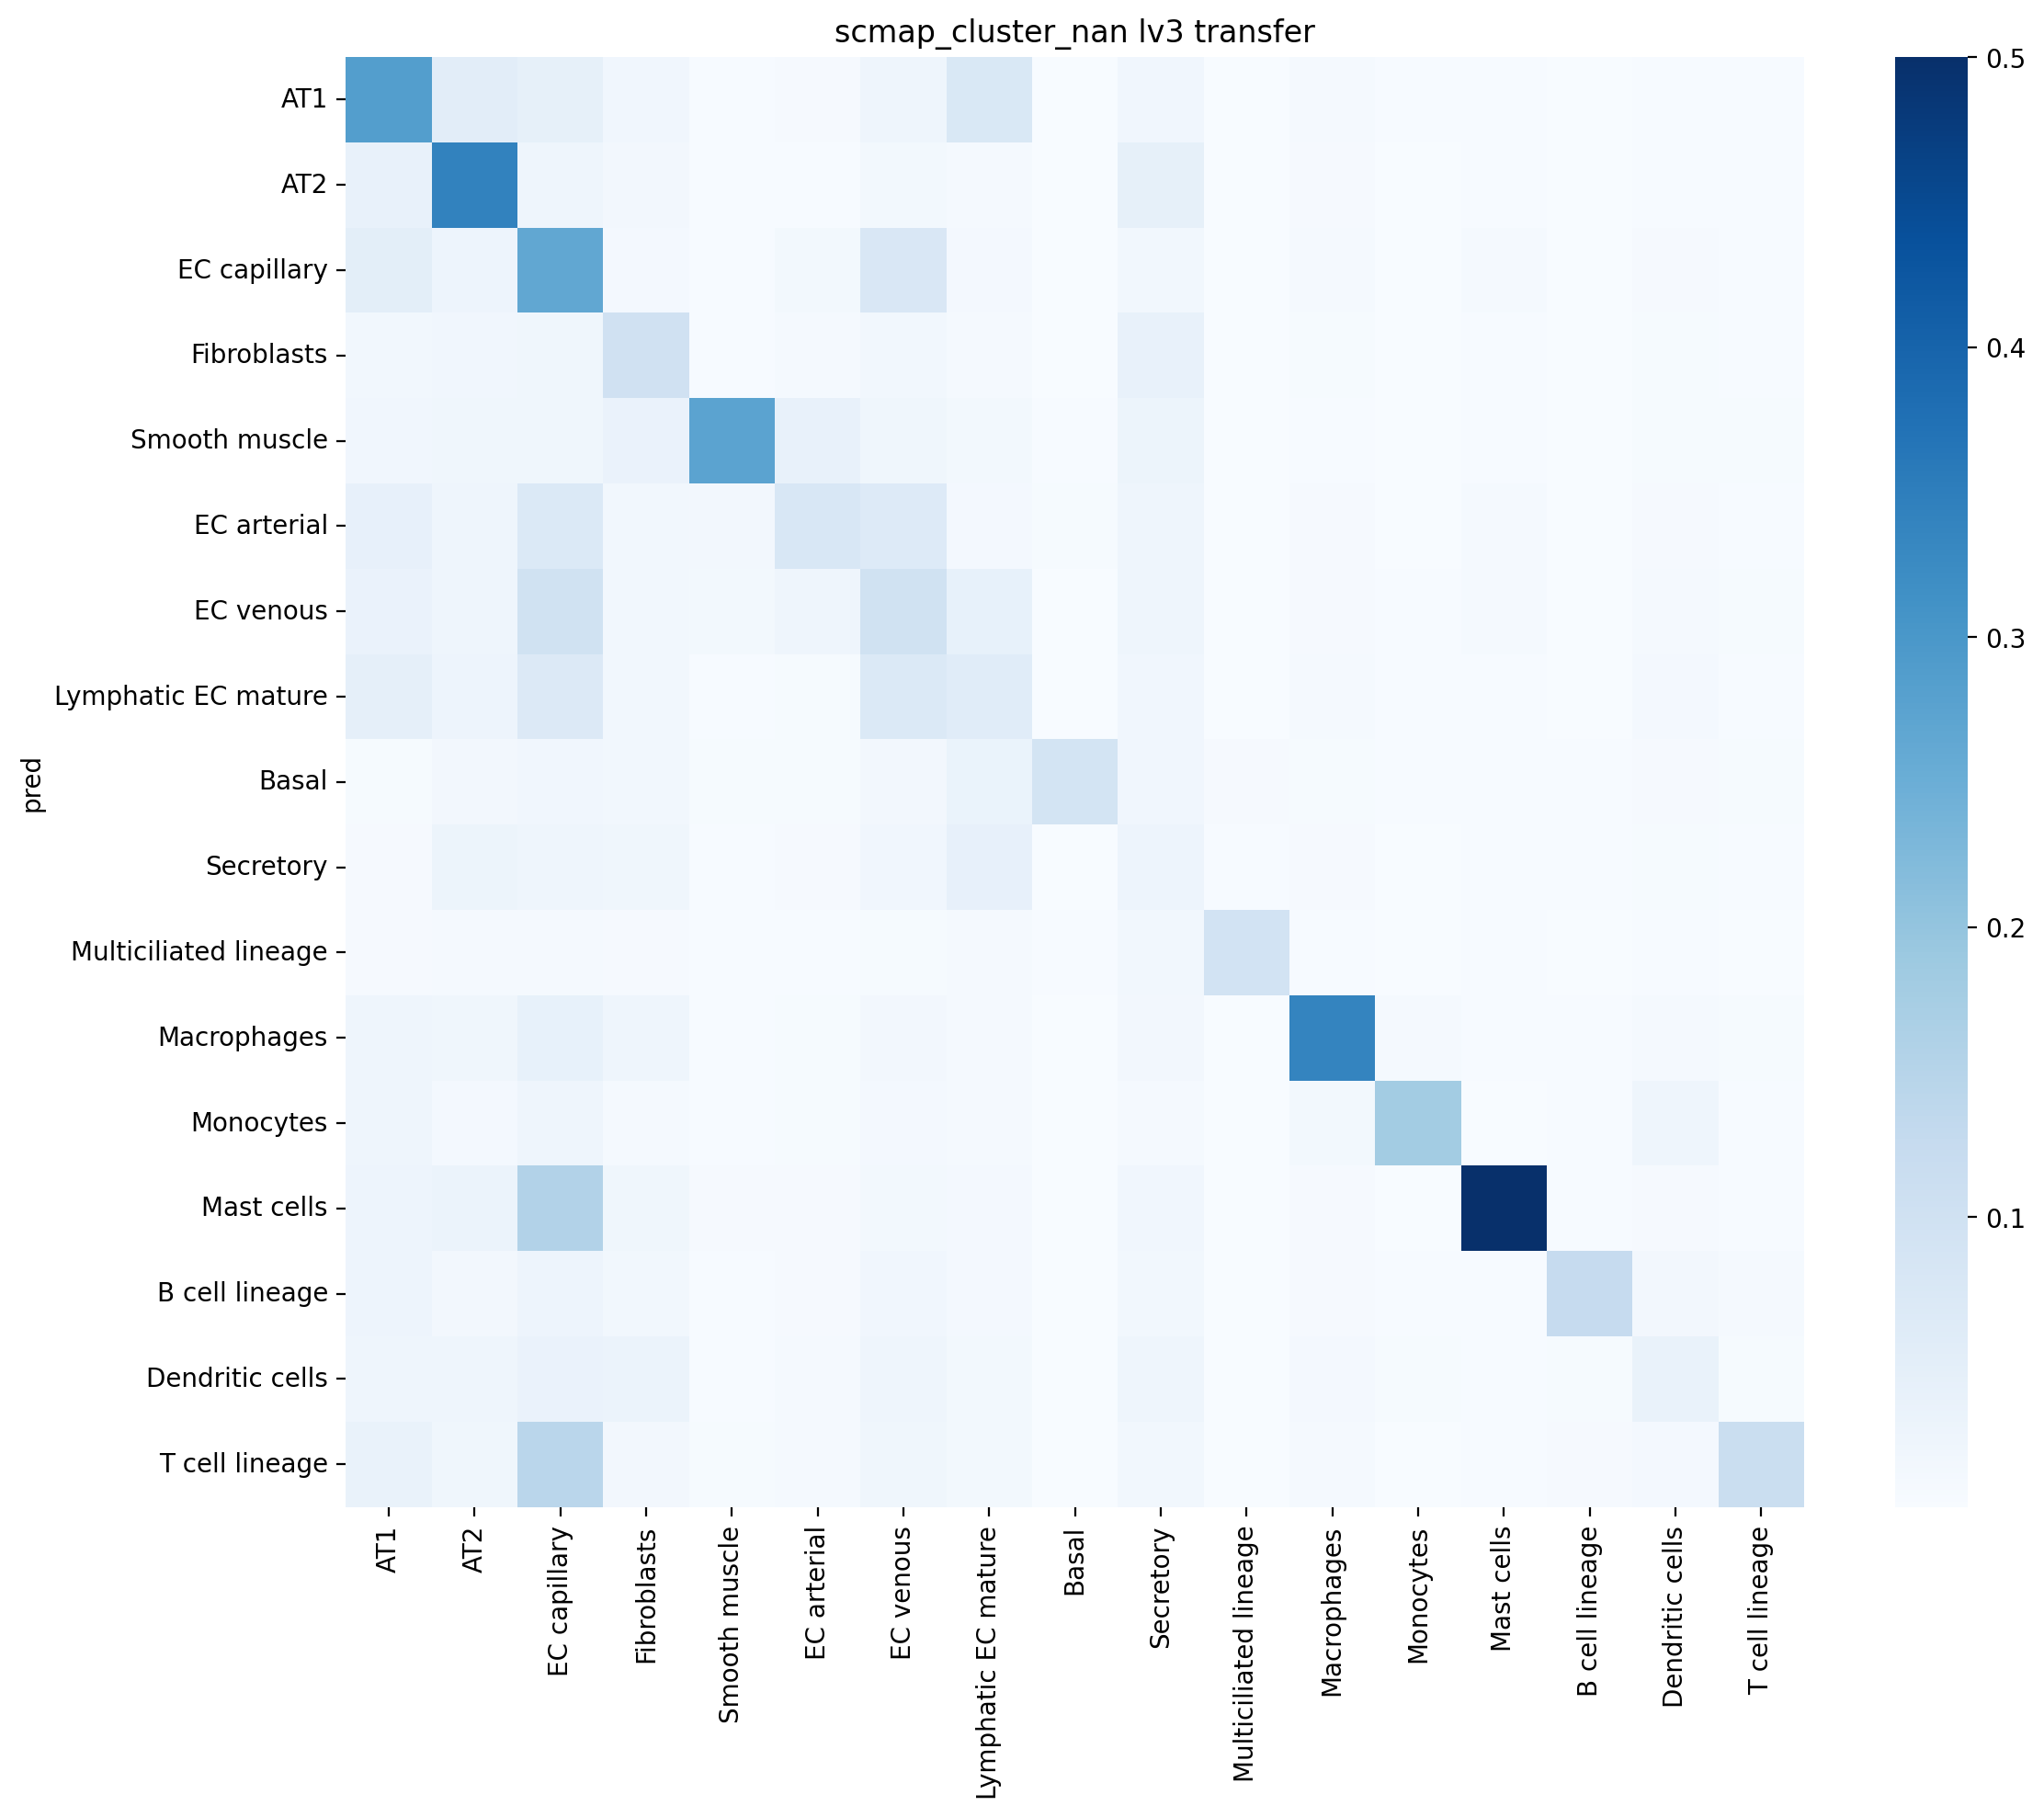

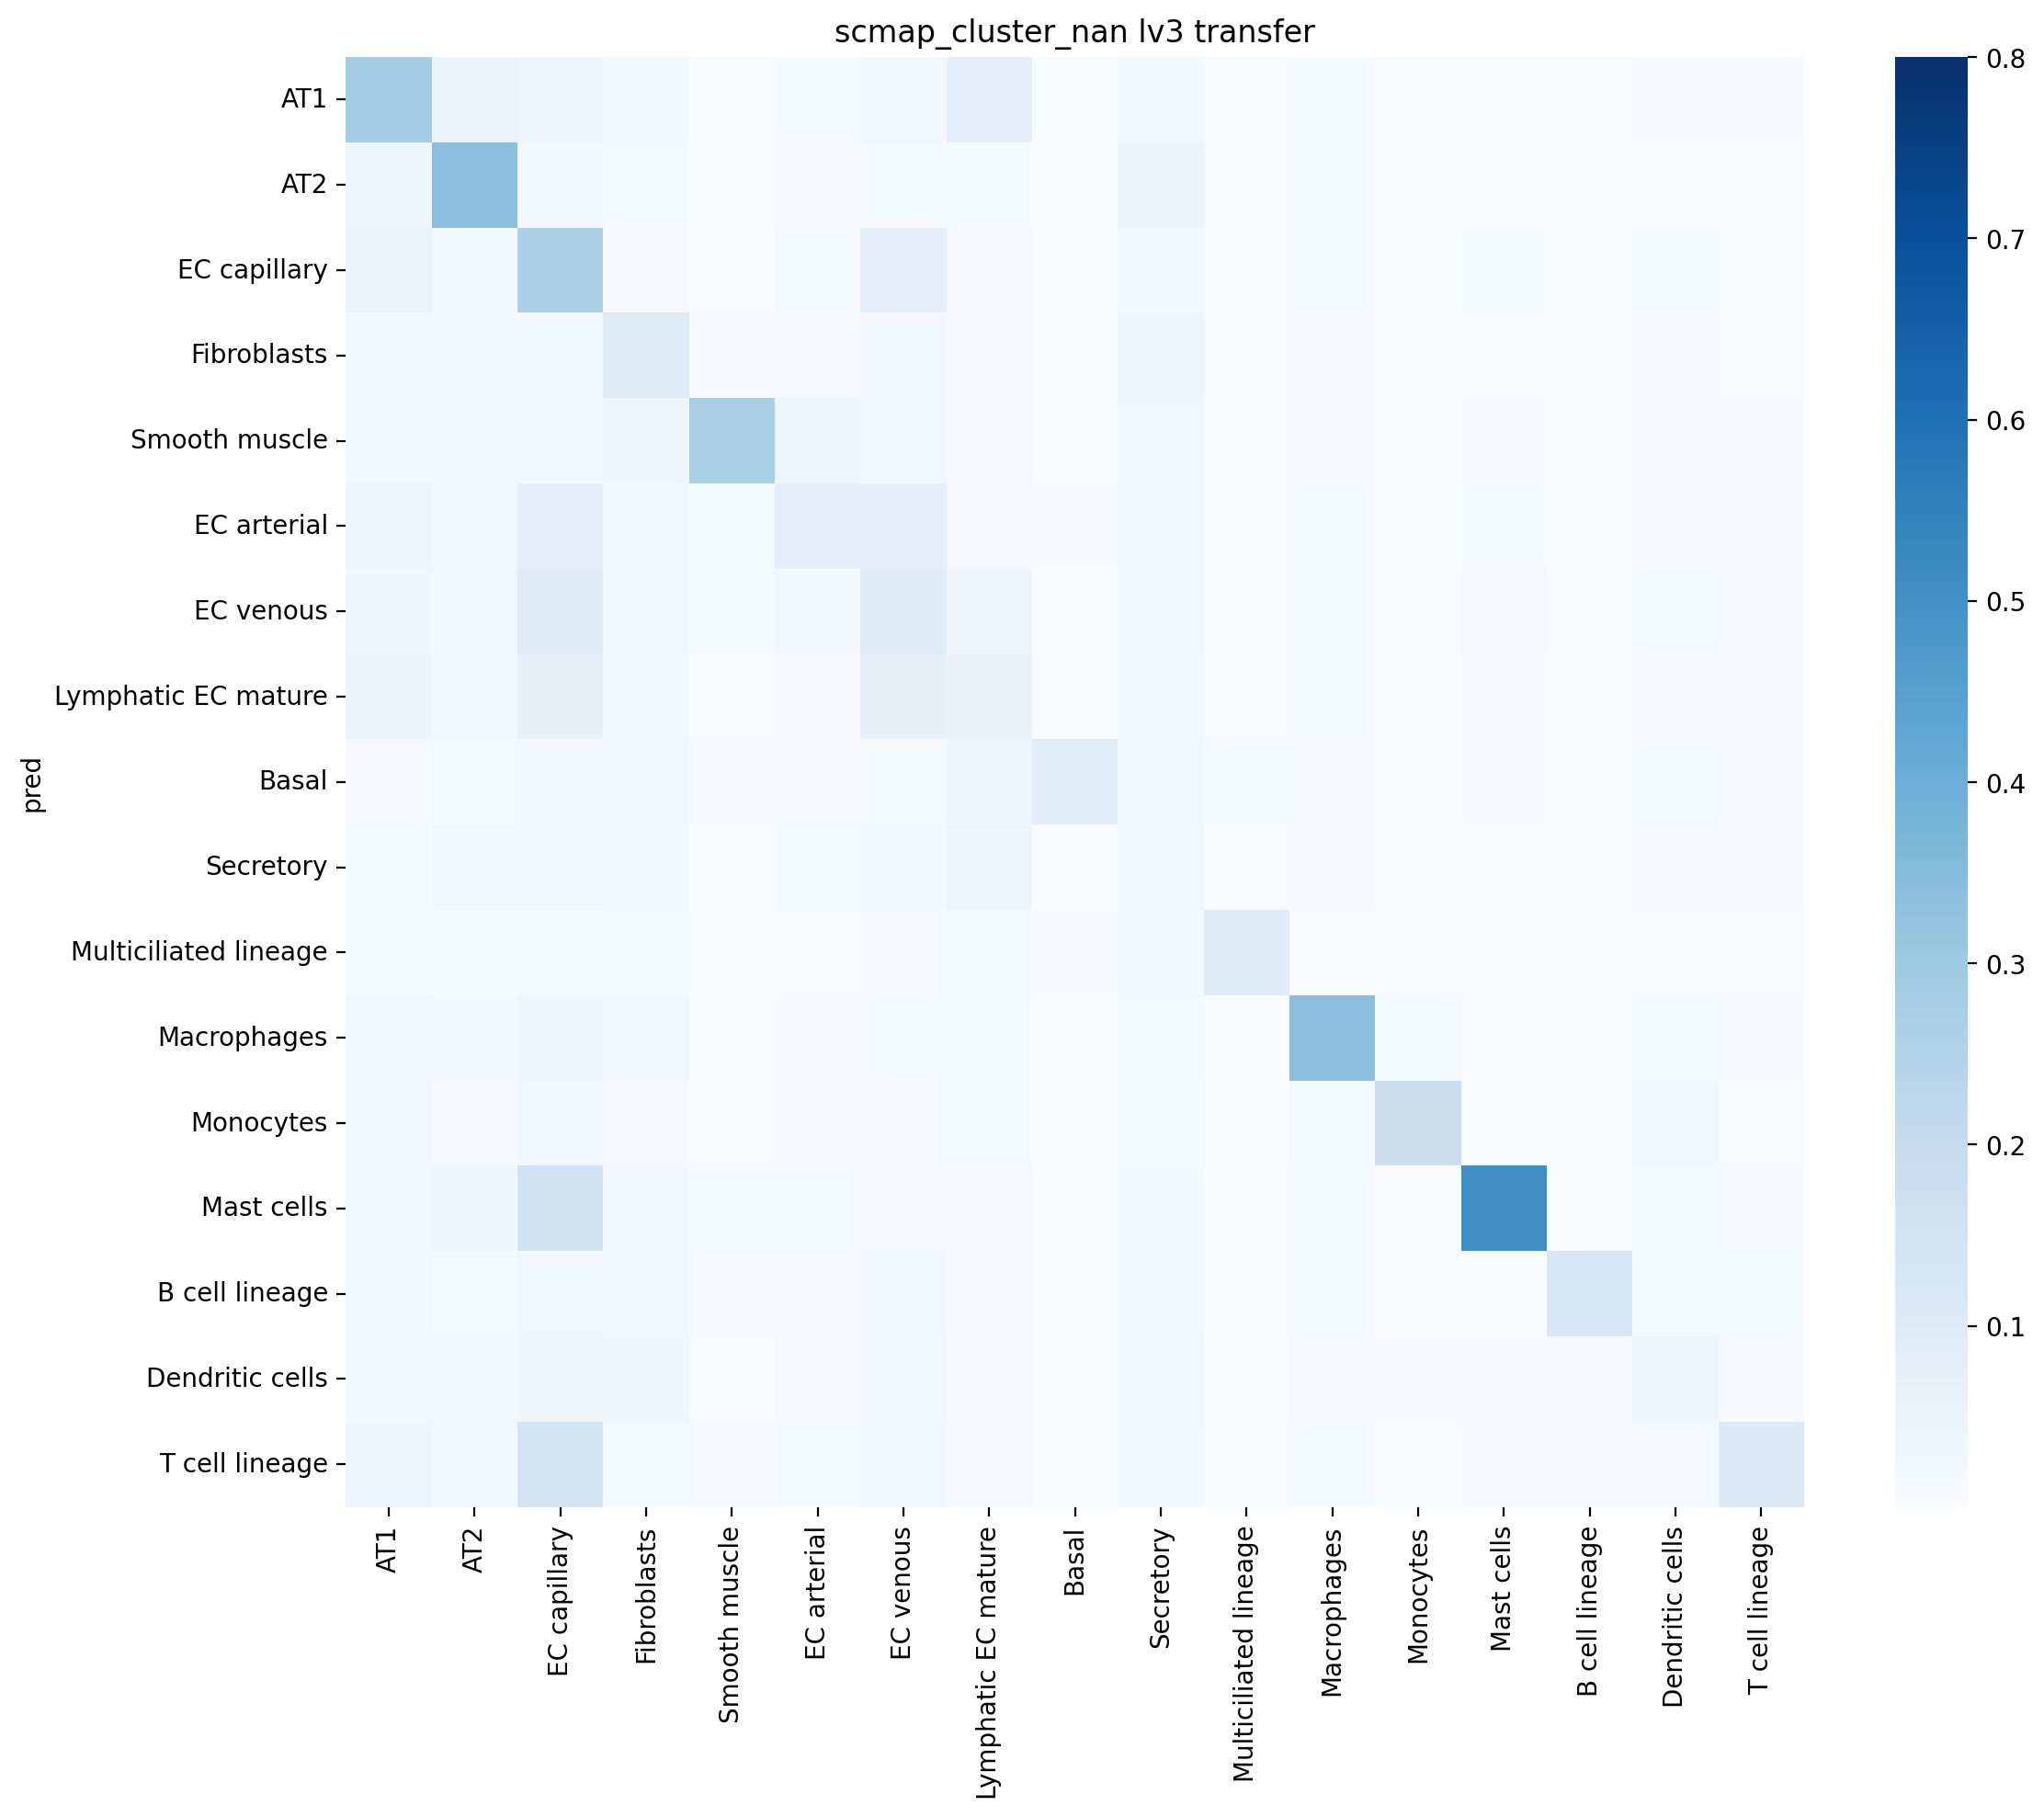

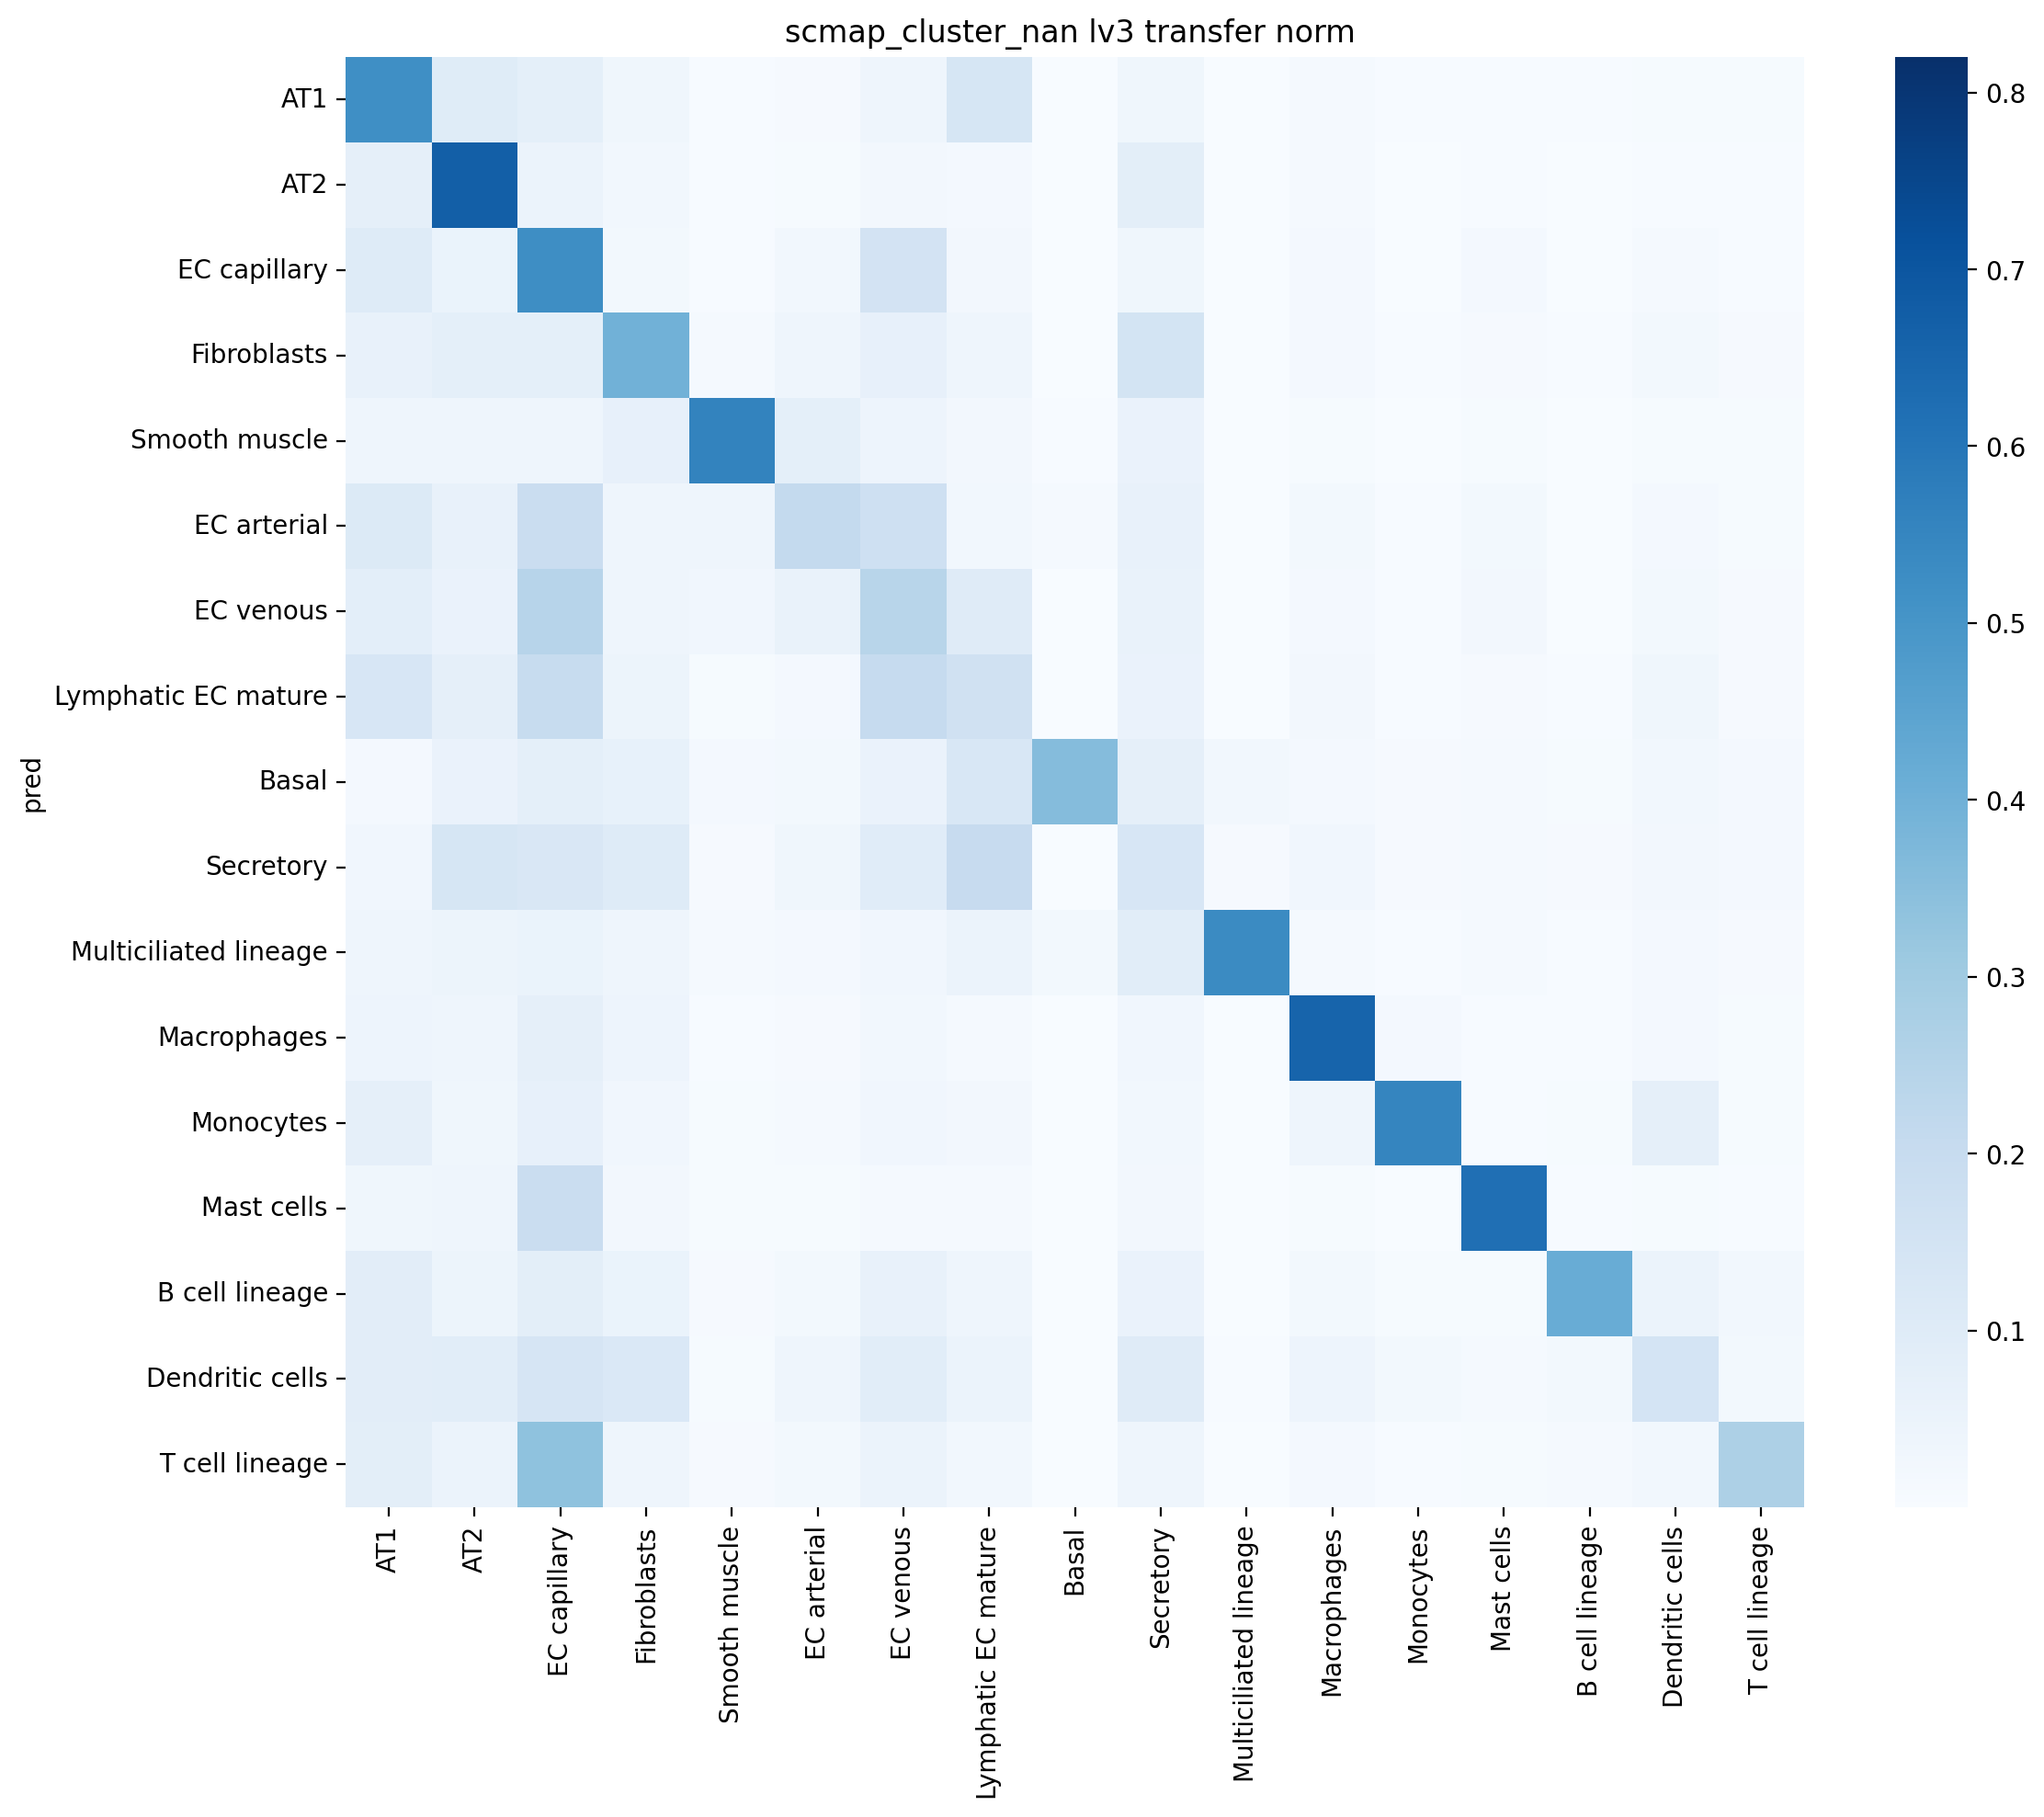

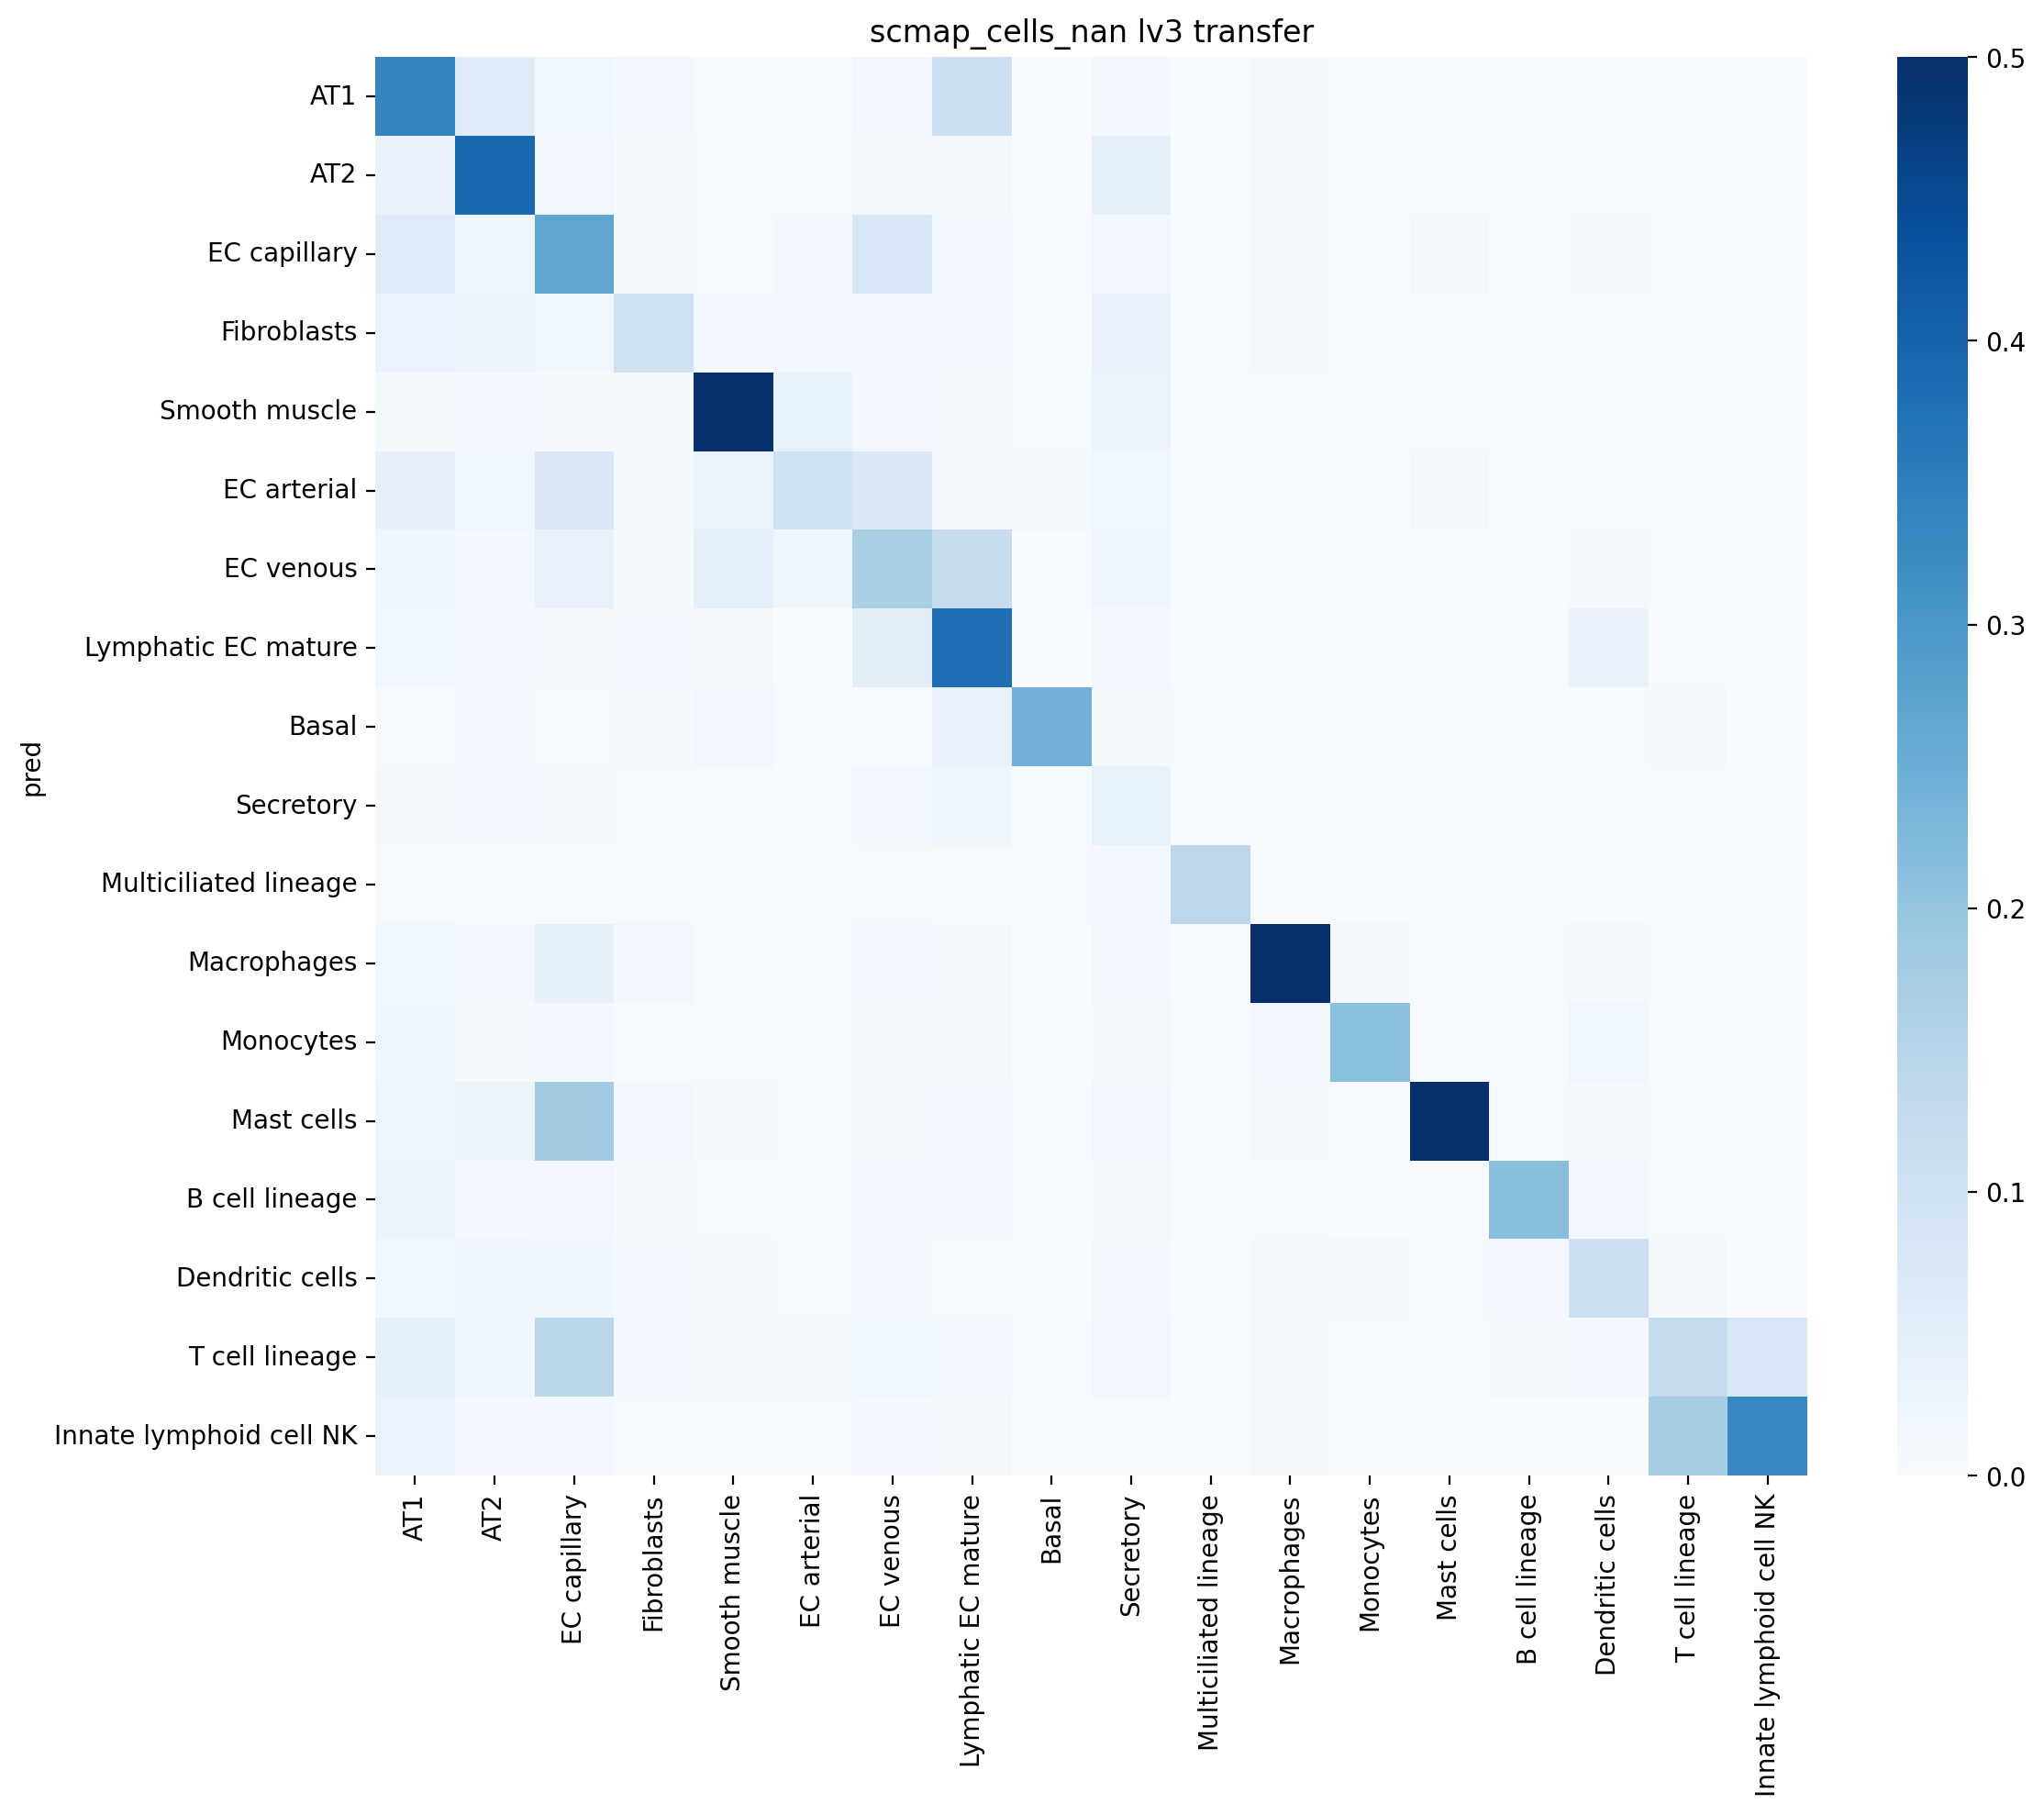

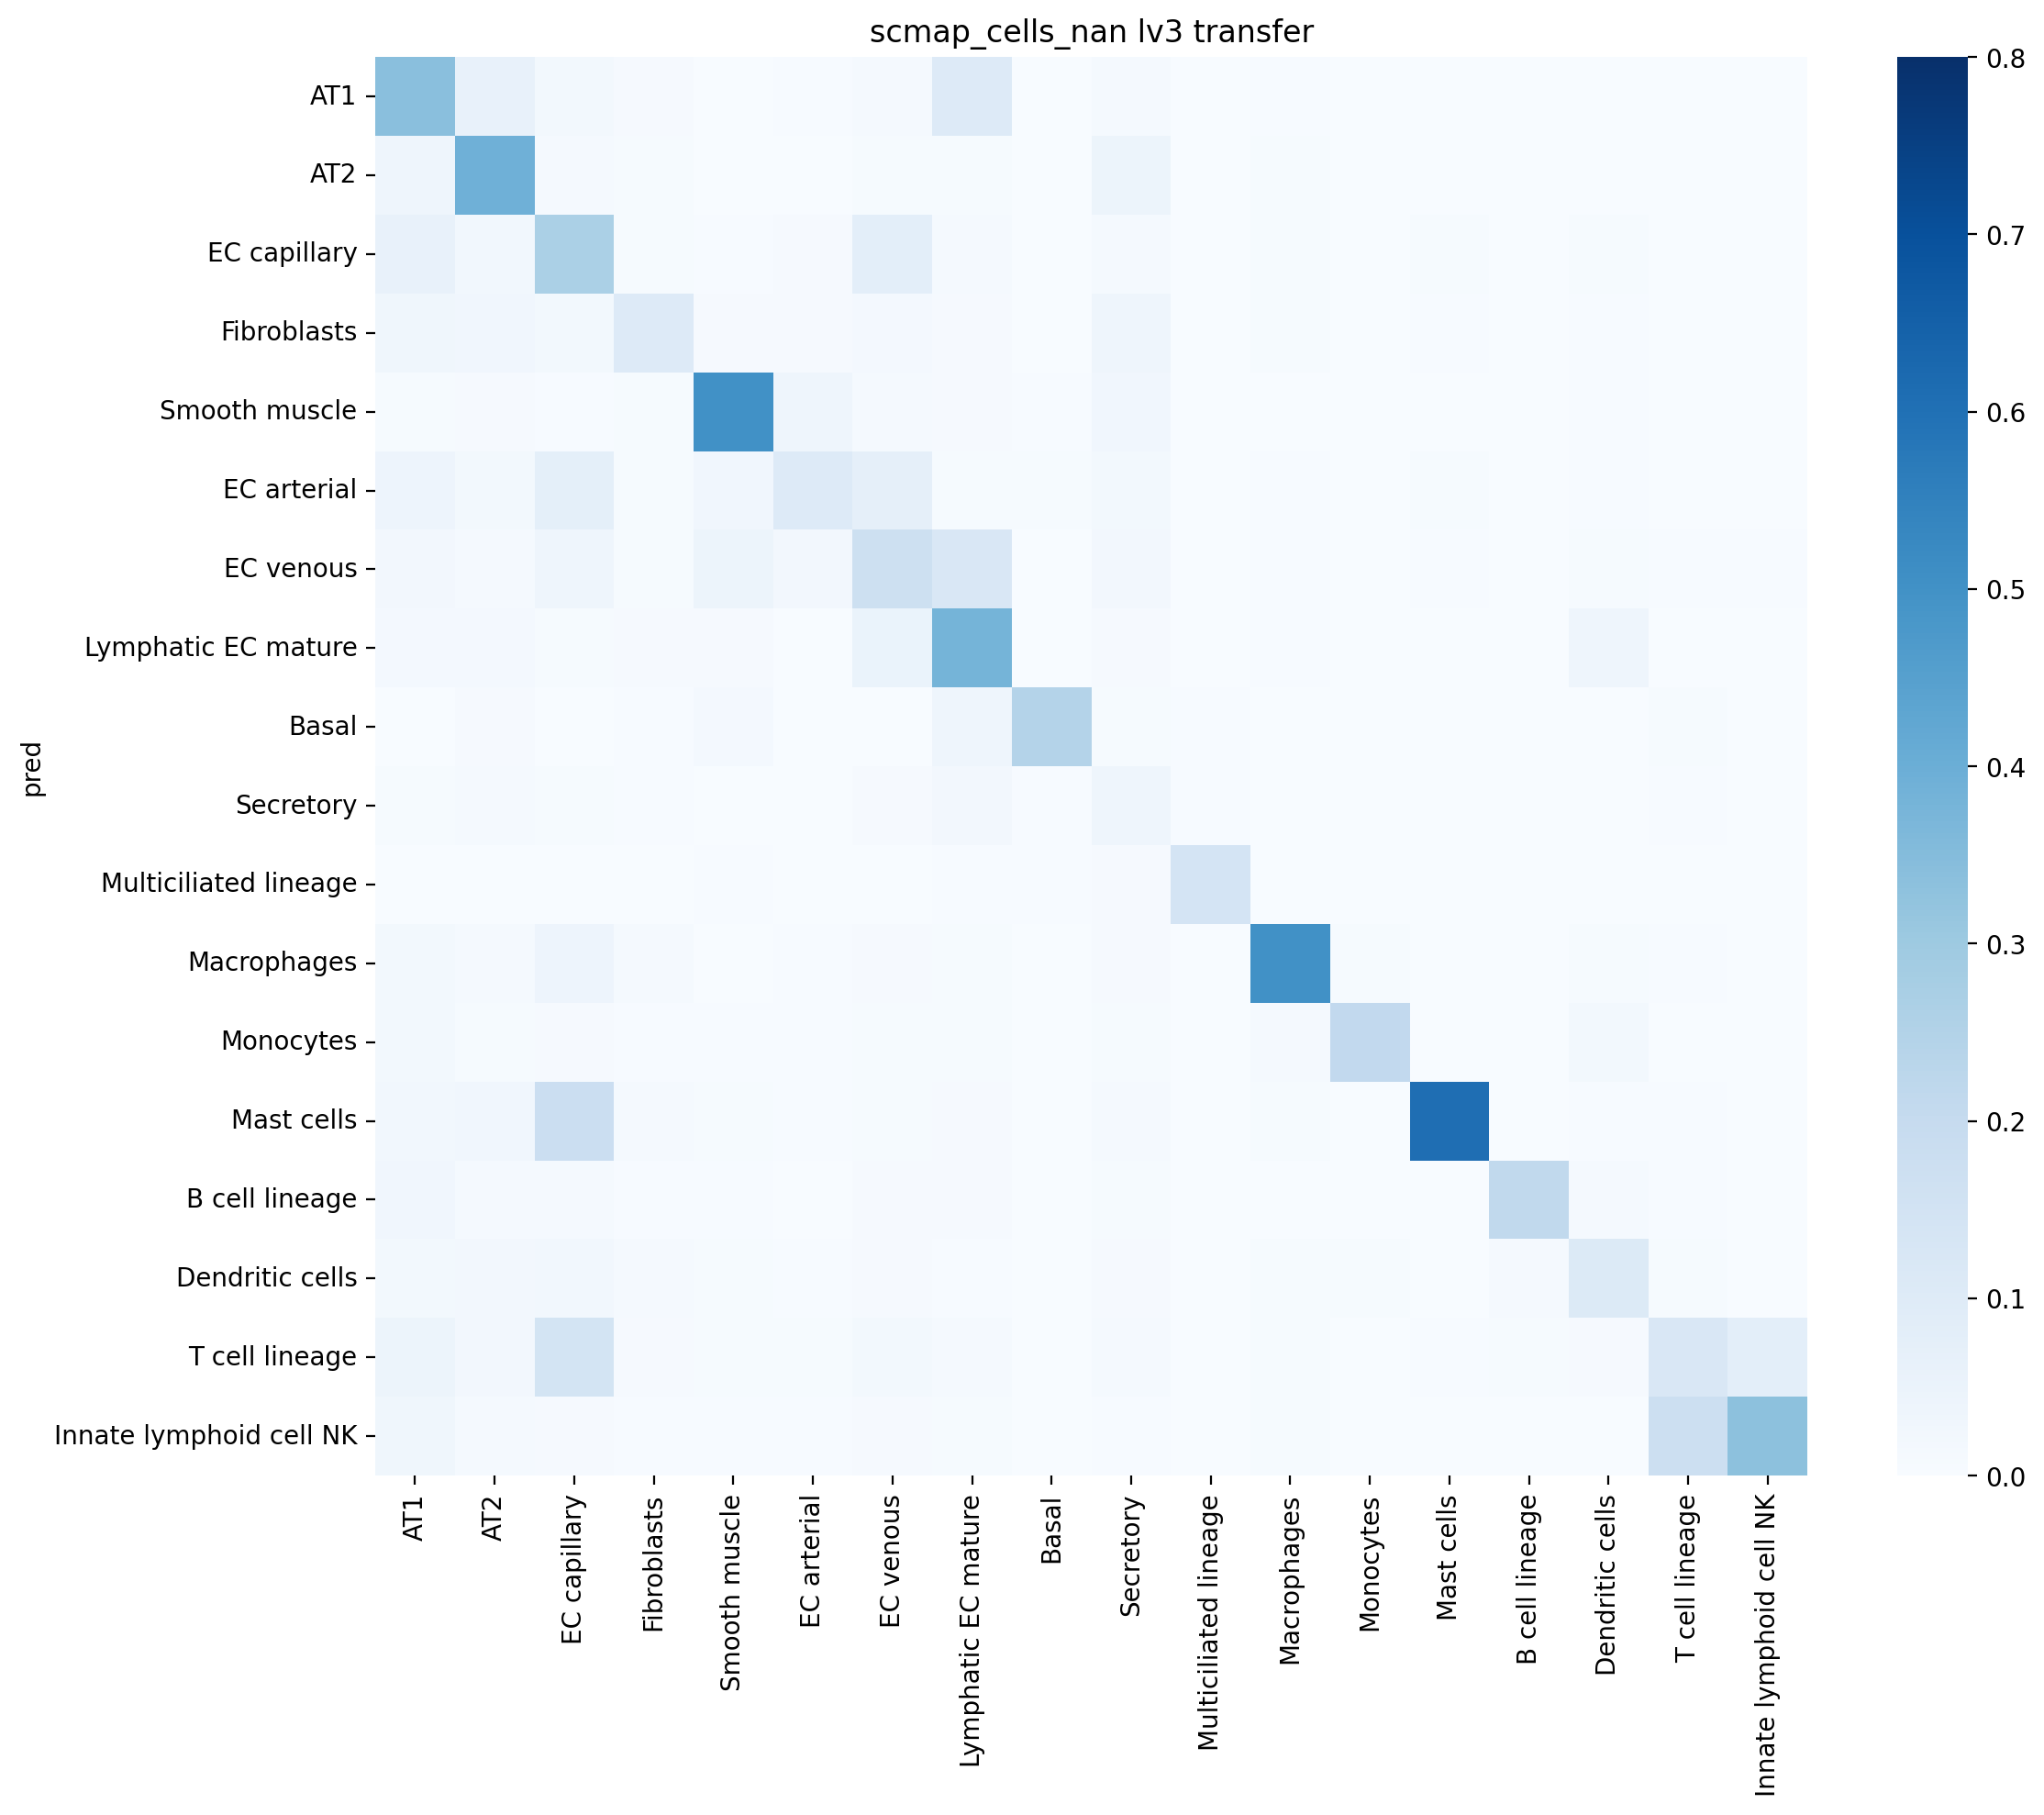

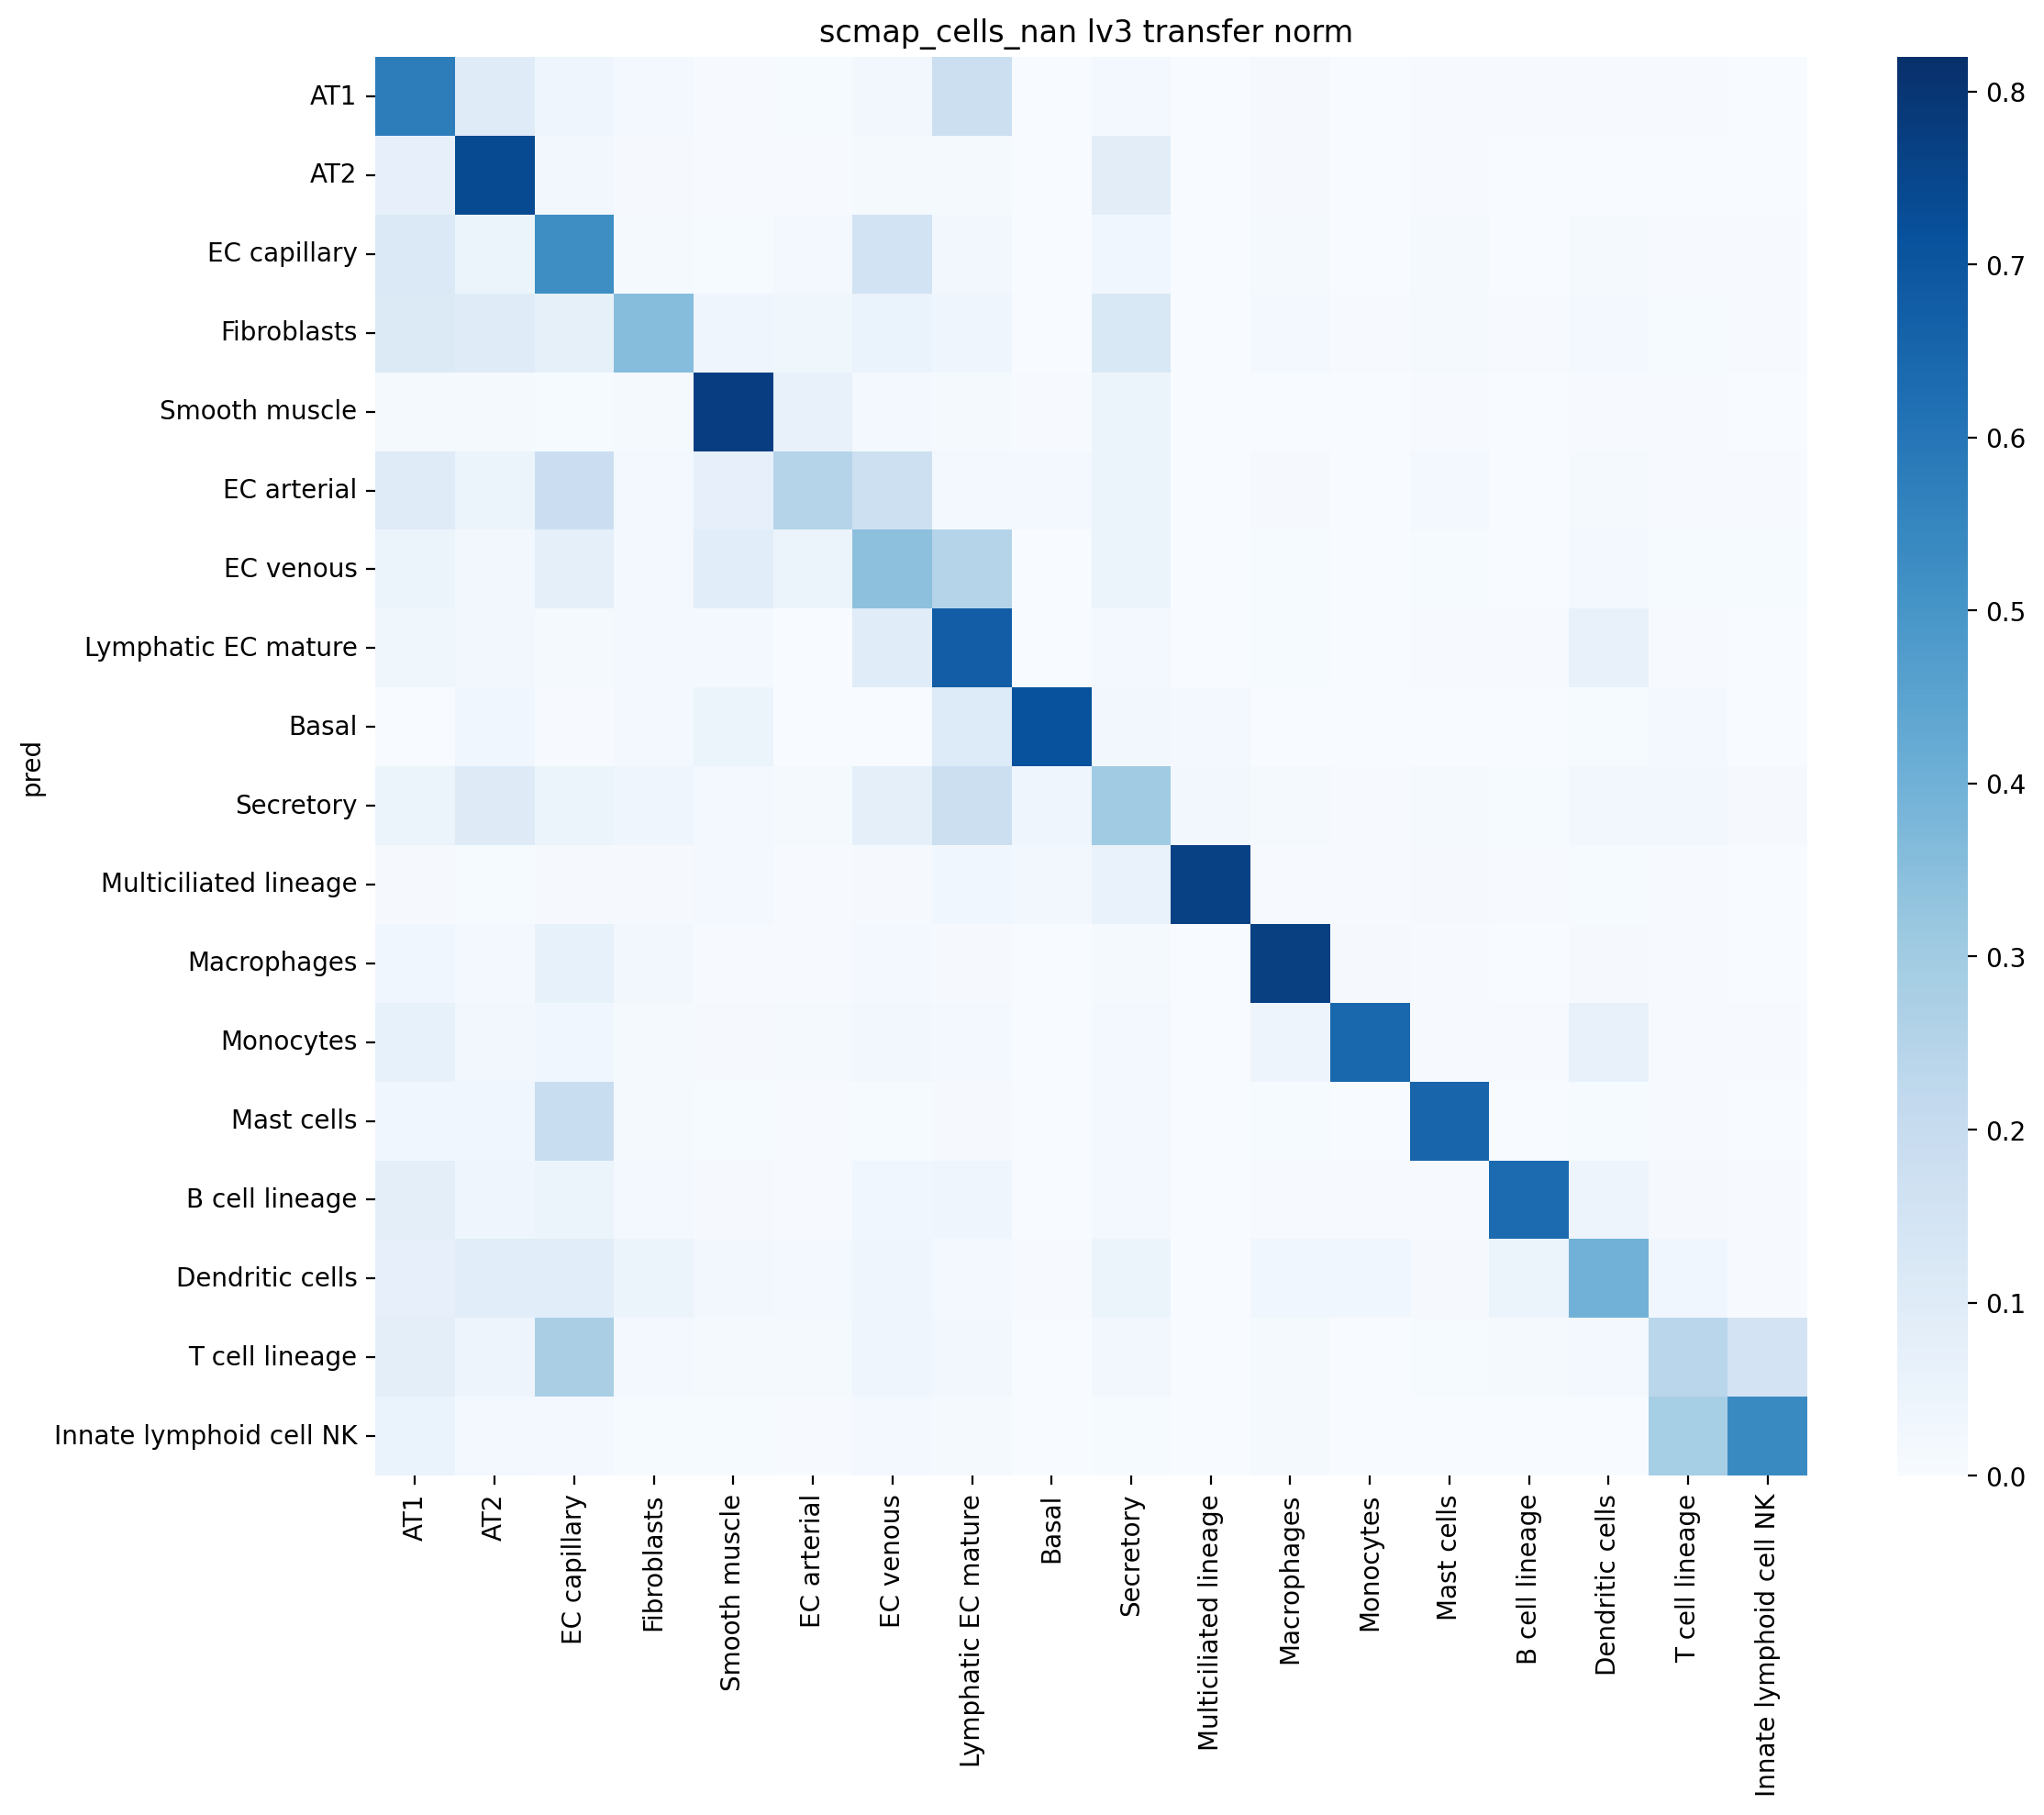

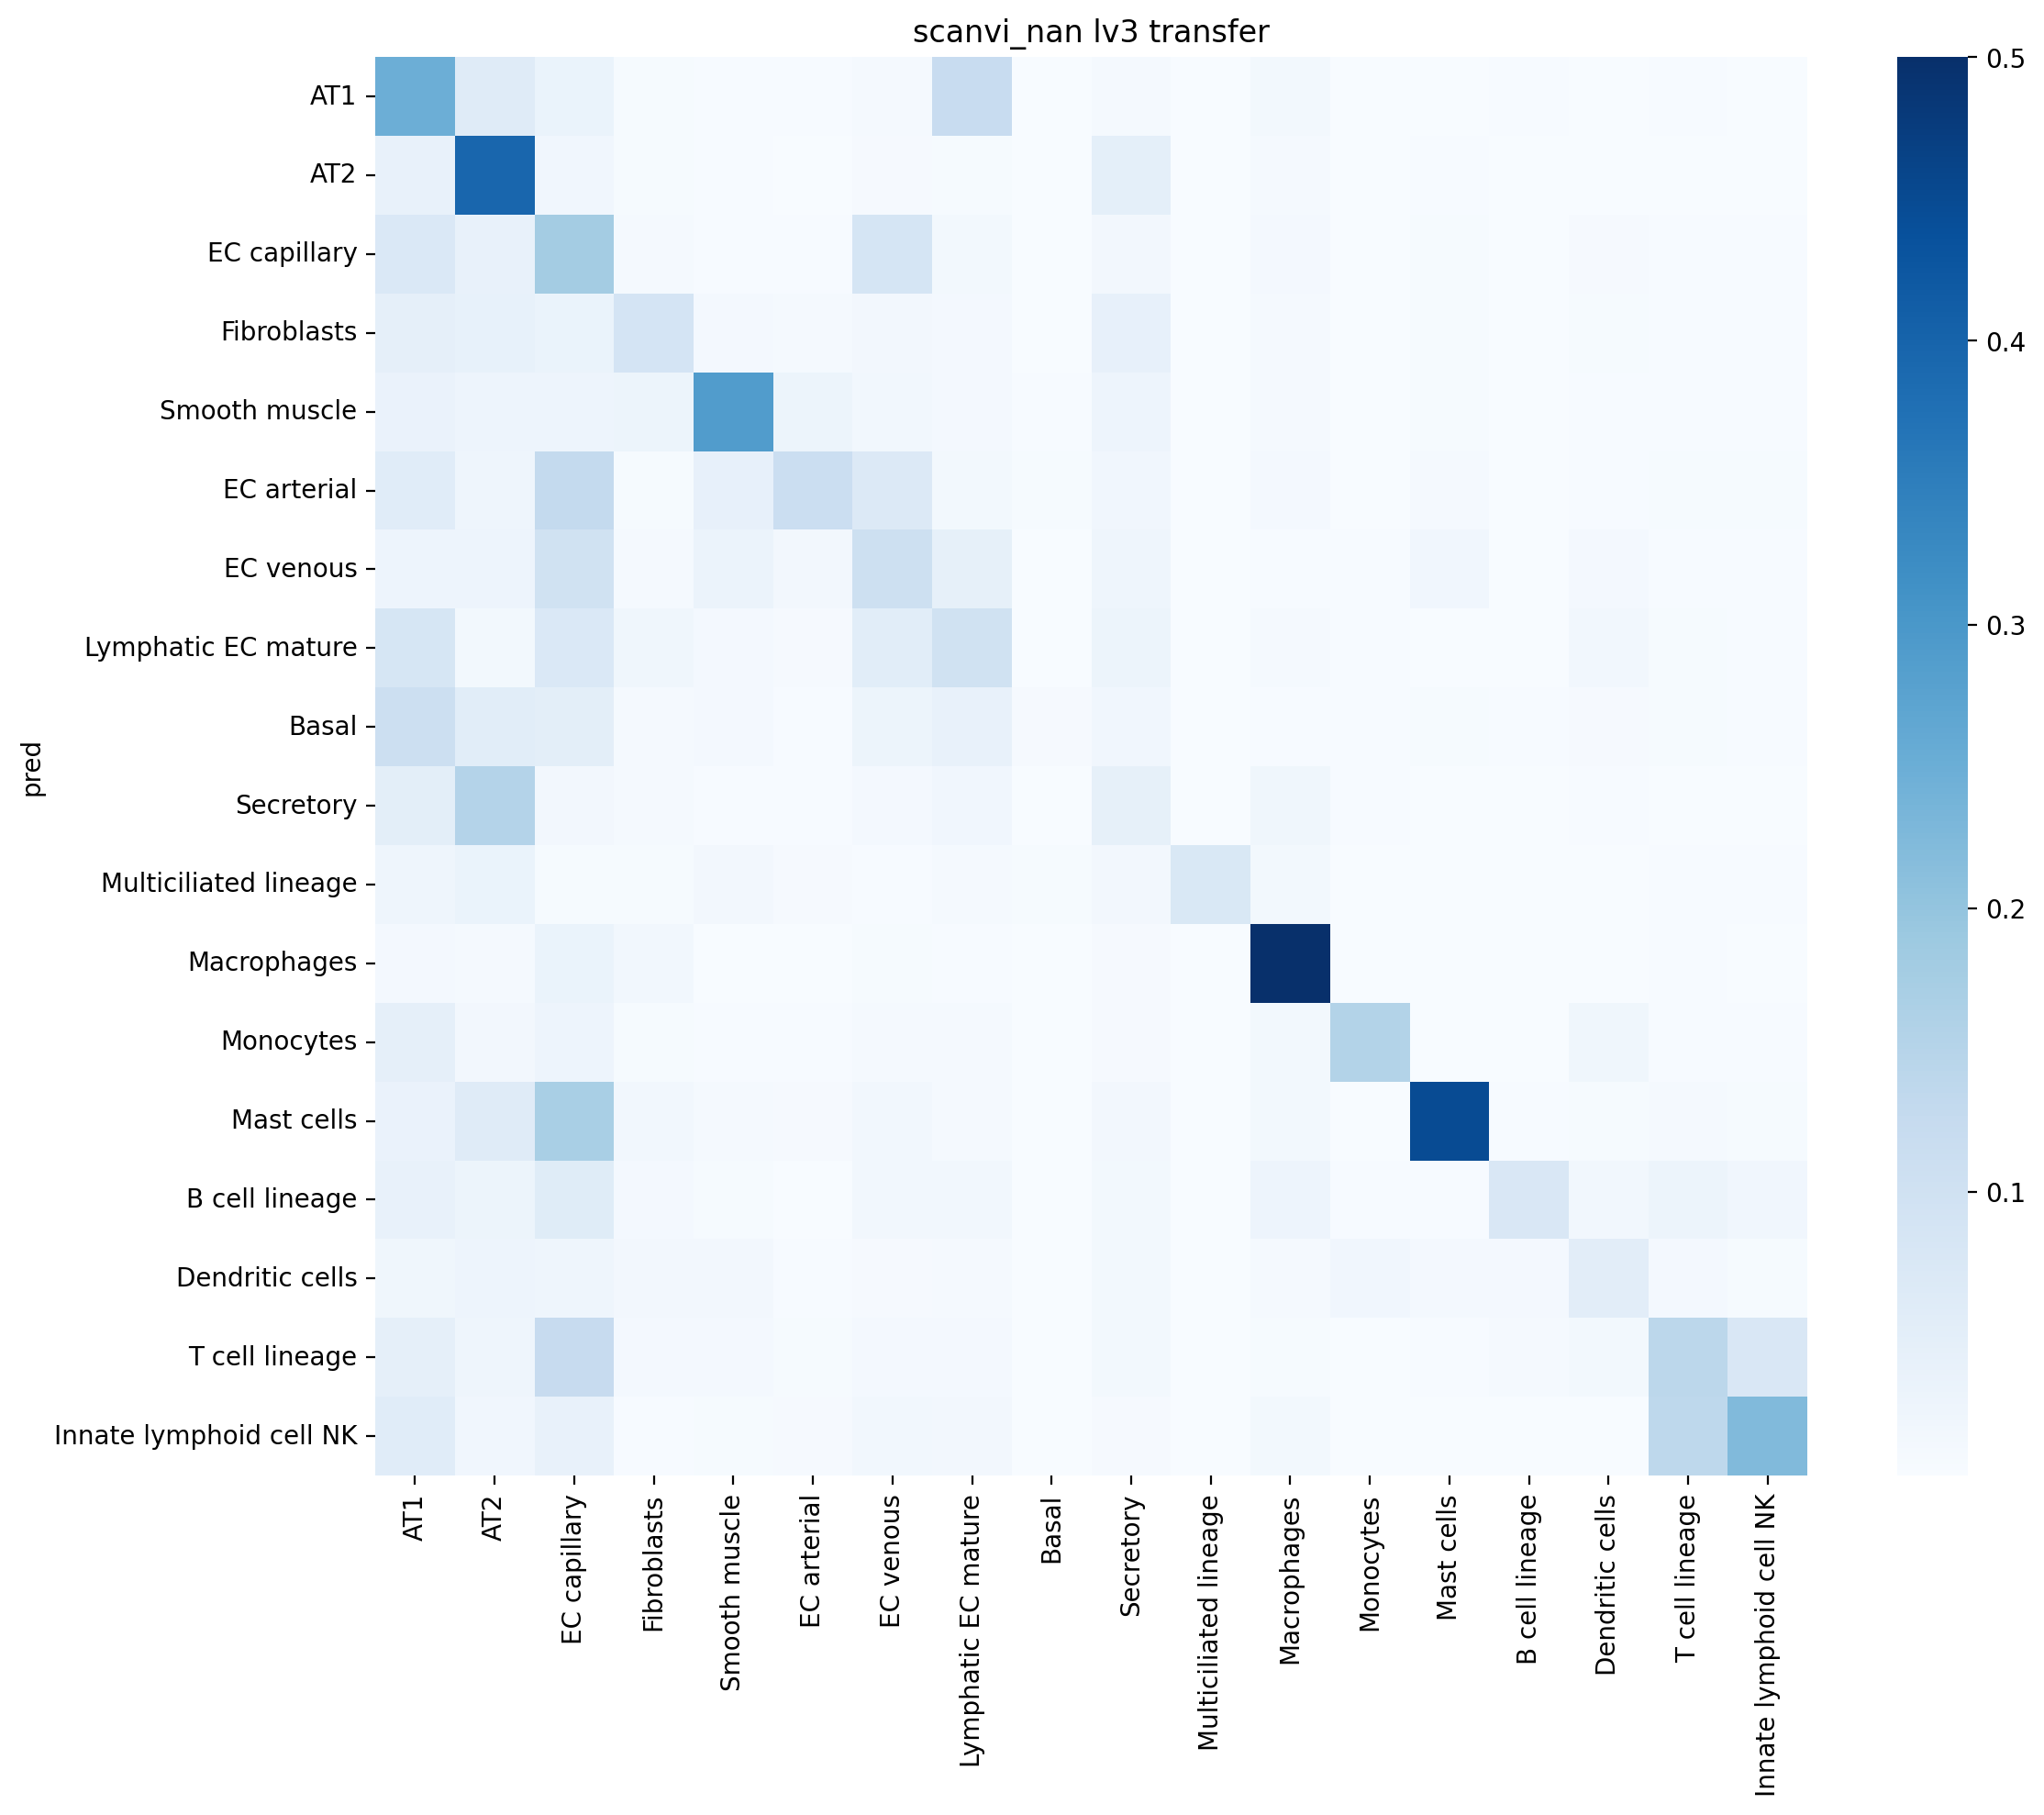

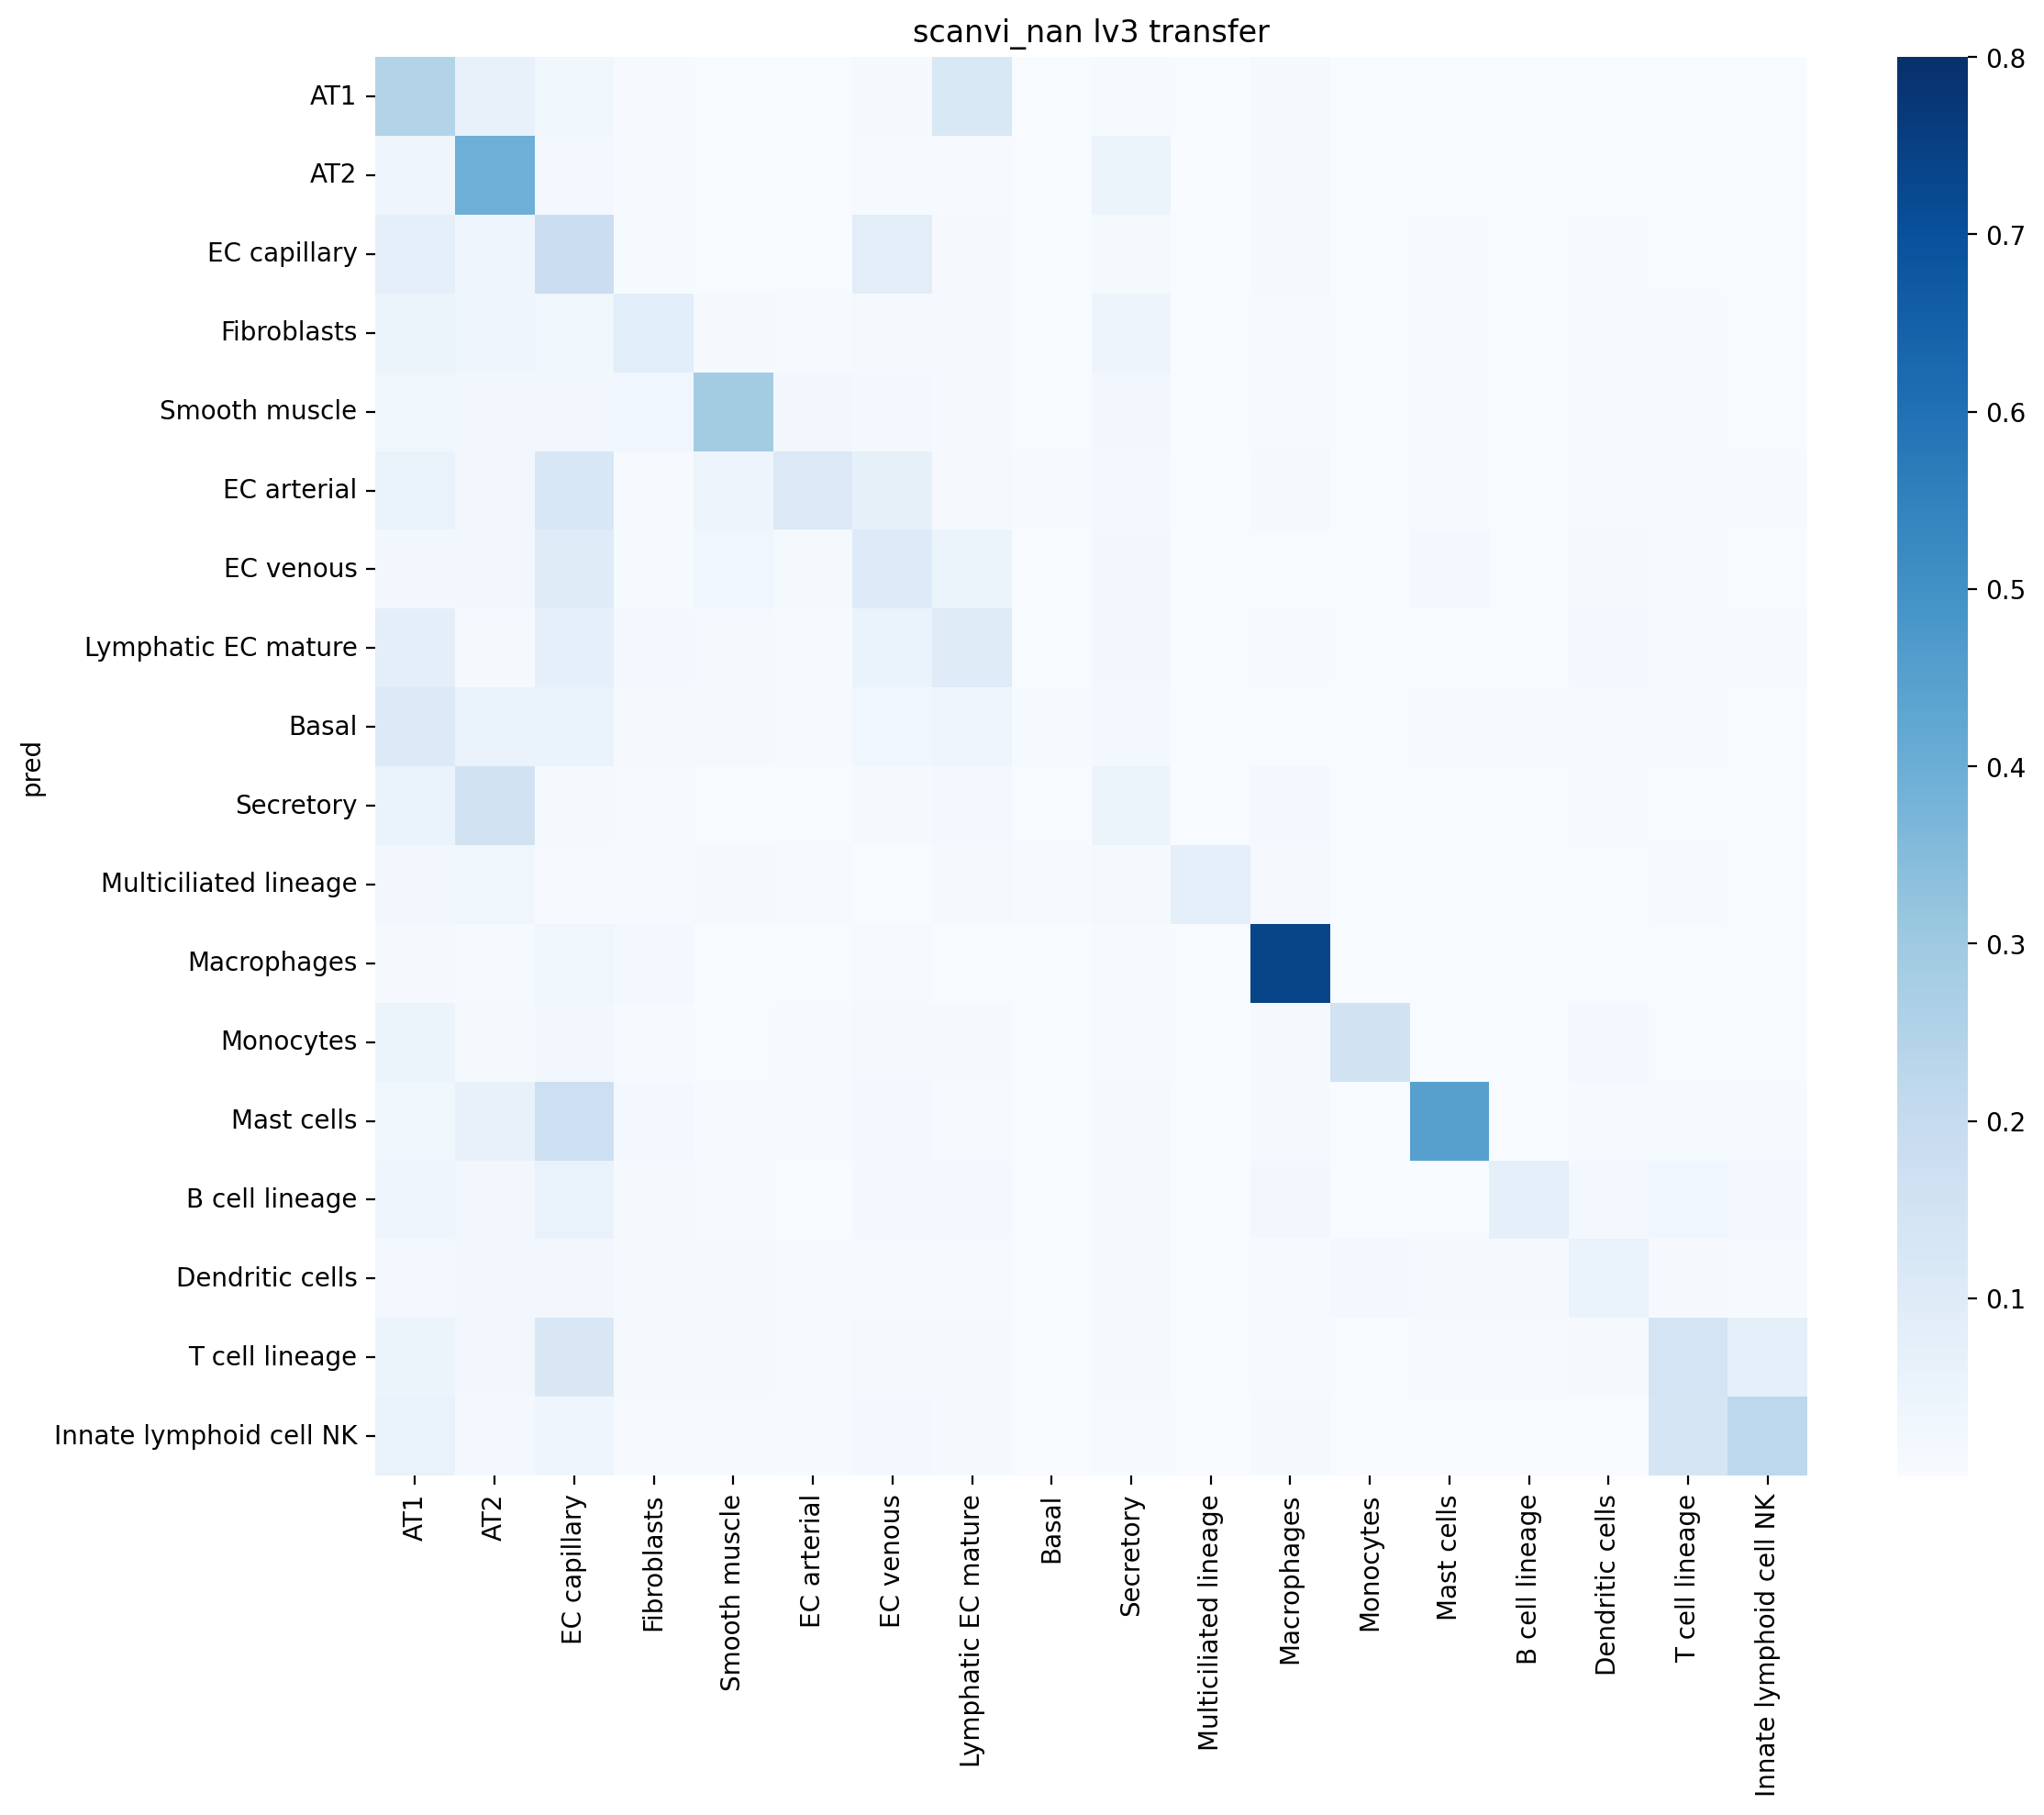

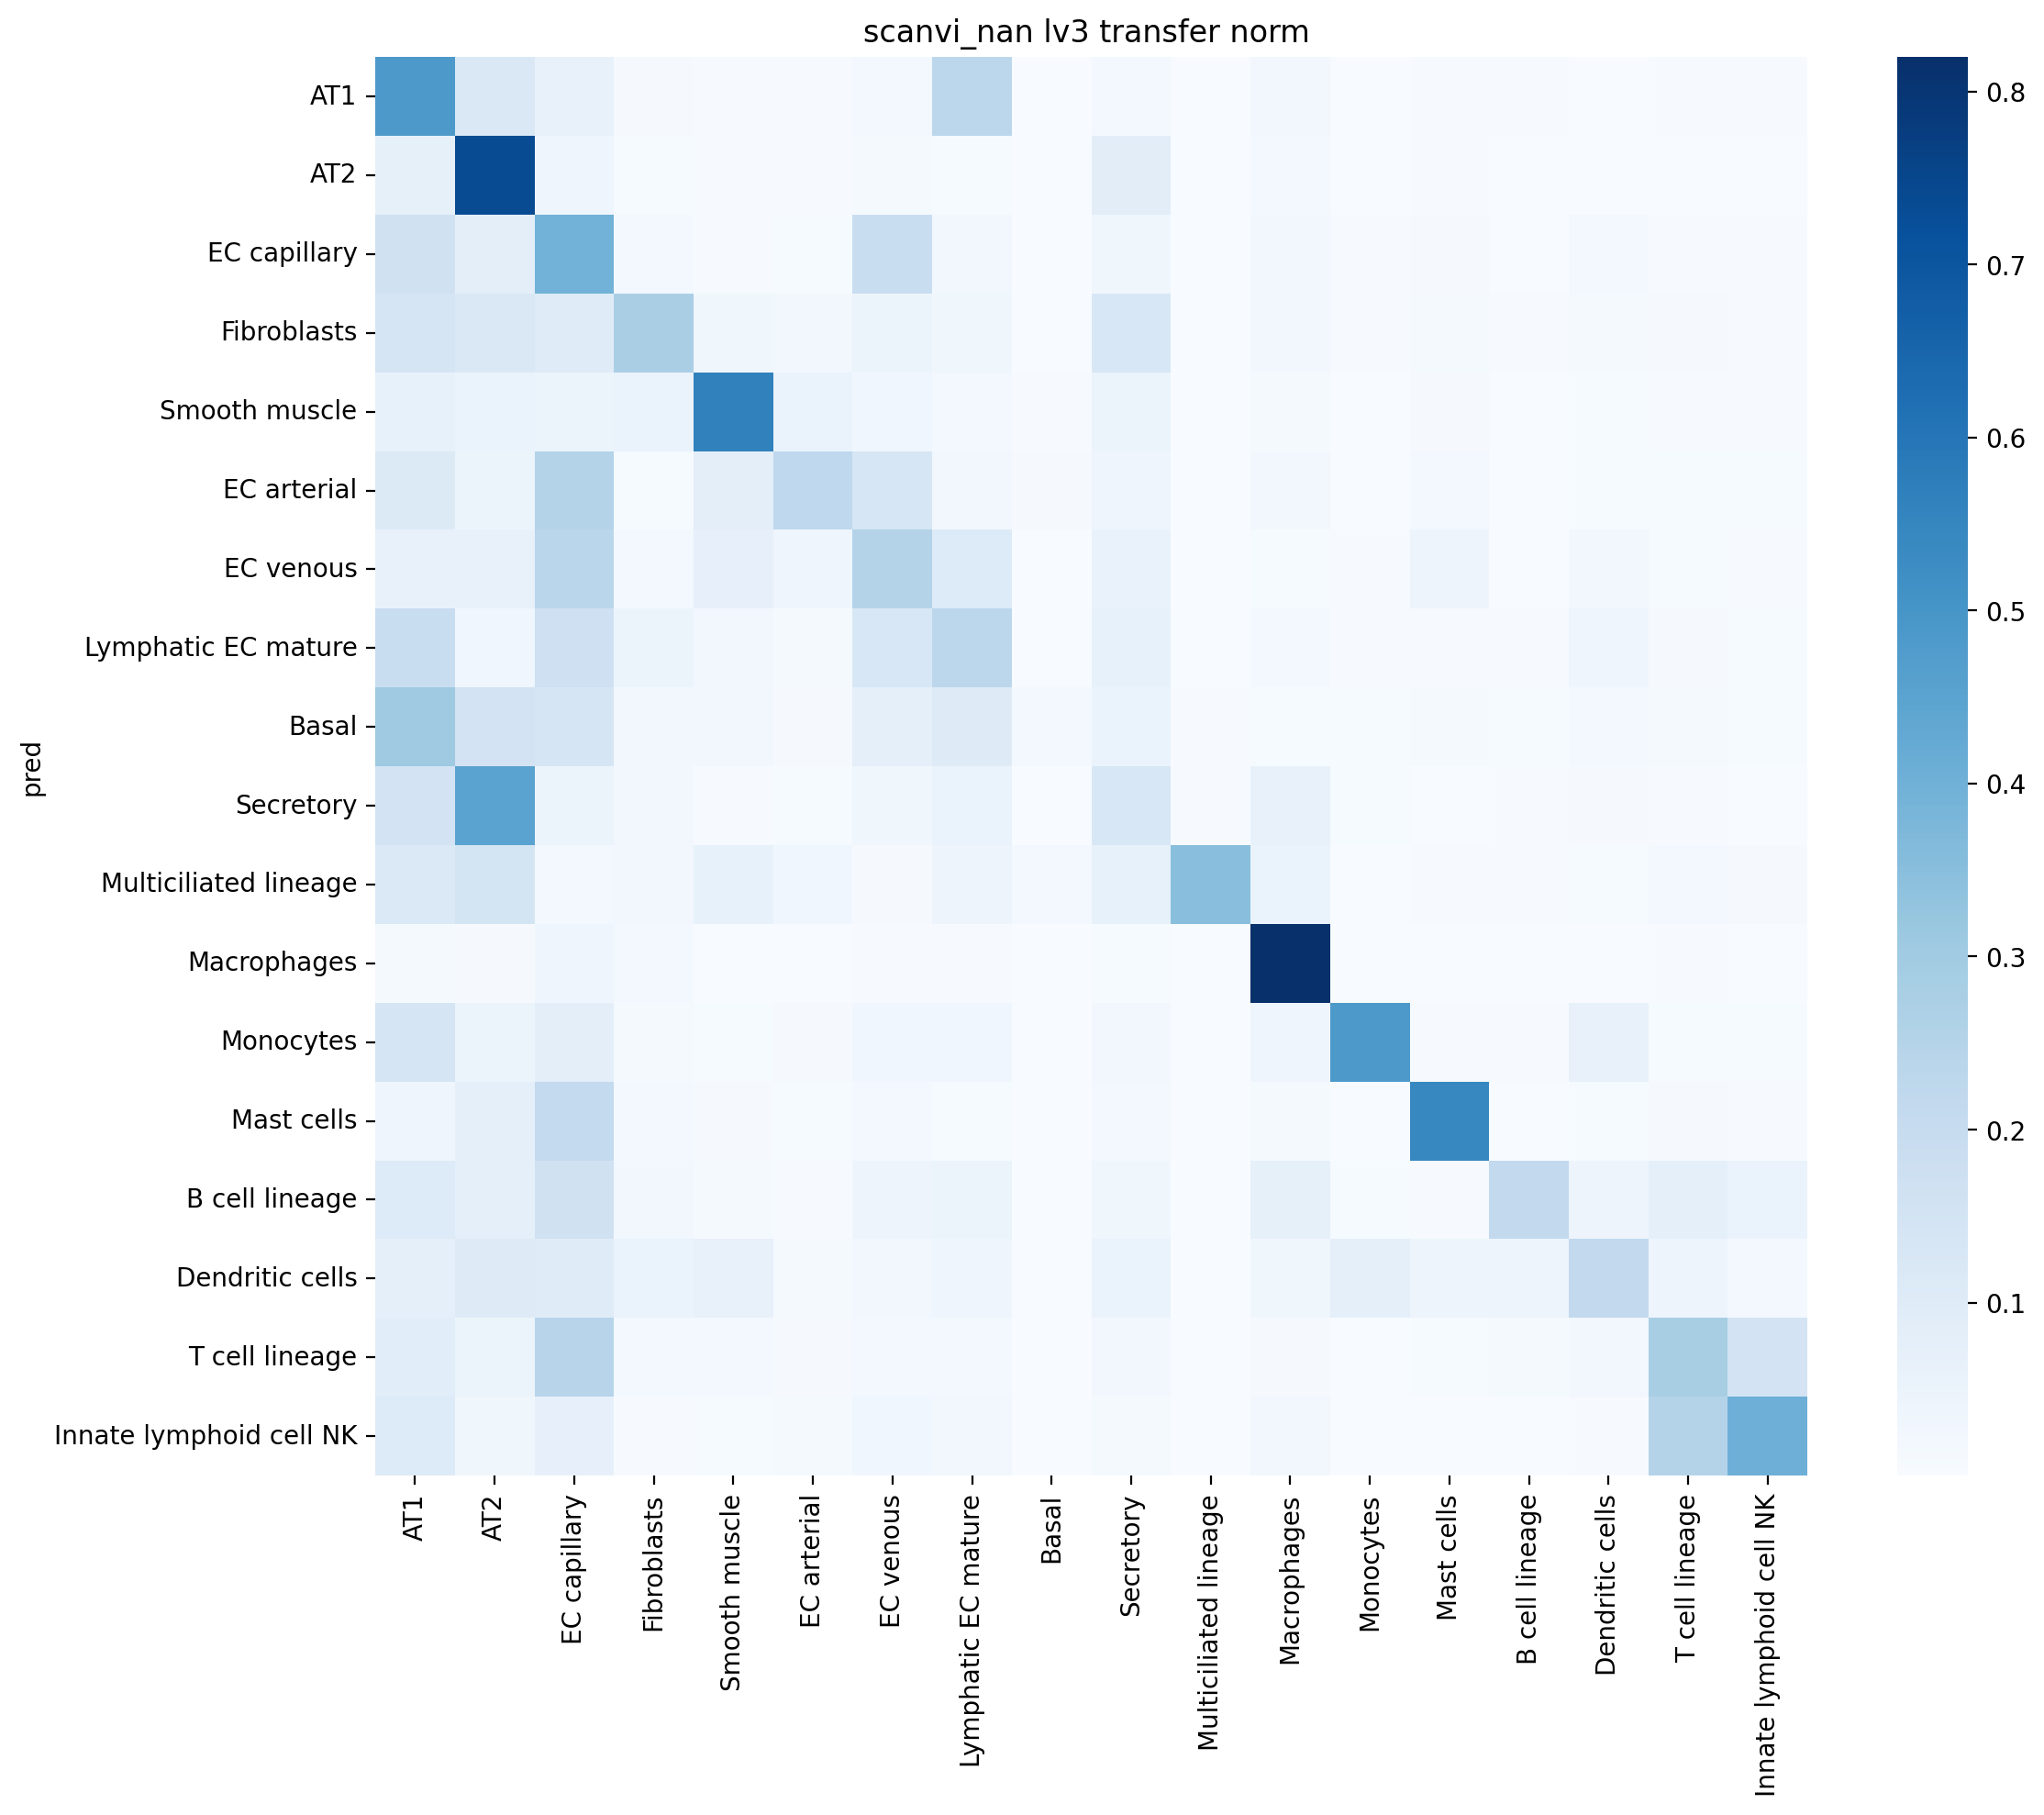

In [94]:
# Loading computed aucell

sc.set_figure_params(dpi=100, figsize=(12,10), scanpy=False, 
                     frameon=False, vector_friendly=False, color_map=None, facecolor=None, transparent=True, ipython_format='png2x')

save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/aucell_heatmap/lv3_transfer/'
p_list = {i : save_path + i for i in os.listdir(save_path) if i.endswith('.csv')}

aucell_dict = {mod.rstrip('.csv') : pd.read_csv(path, index_col = 0) for mod, path in p_list.items()}

for model, aucell in aucell_dict.items():
    ct_order = [i for i in celltype_order if i in aucell.index]
    aucell = aucell.loc[ct_order, ct_order]
    for vm in [0.5,0.8]:
        plt.figure()
        sns.heatmap(aucell, cmap = 'Blues',vmax = vm)
        plt.title(model + ' lv3 transfer')
        plt.tight_layout()
        # training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
        plt.savefig(save_path + model + 'vmax_' + str(vm) + '.png', transparent=False)
    plt.figure()
    agg_aucell_norm = pd.DataFrame(np.array(aucell) / np.array(aucell).sum(axis = 1, keepdims=True), index = aucell.index, columns = aucell.columns)
    sns.heatmap(agg_aucell_norm, cmap = 'Blues', vmax = 0.82)
    plt.title(model + ' lv3 transfer norm ')
    plt.tight_layout()
    plt.savefig(save_path + model + '_' + 'norm' + '.png', transparent=False)

In [ ]:
# Saving aucell 

save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/aucell_heatmap/lv3_transfer/'
check_dir(save_path)
model = 'scanvi'
spa = adata[adata.obs['dataset'] == 'spatial']
dc.run_aucell(spa, marker_net, min_n = 0)

aucell = spa.obsm['aucell_estimate']
aucell['pred'] = spa.obs['scanvi_pred']
agg_aucell = aucell.groupby('pred').agg('mean')

ct_order = [i for i in celltype_order if i in agg_aucell.index]
agg_aucell = agg_aucell.loc[ct_order, ct_order]
for vm in [0.5,0.8]:
    plt.figure()
    sns.heatmap(agg_aucell, cmap = 'Blues',vmax = vm)
    plt.title(model + ' lv3 transfer')
    plt.tight_layout()
    # training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
    plt.savefig(save_path + model + '_' + 
                str(training_scheme) + 'vmax_' + str(vm) + '.png', transparent=False)
plt.figure()
agg_aucell_norm = pd.DataFrame(np.array(agg_aucell) / np.array(agg_aucell).sum(axis = 1, keepdims=True), index = agg_aucell.index, columns = agg_aucell.columns)
sns.heatmap(agg_aucell_norm, cmap = 'Blues')
plt.title(model + ' lv3 transfer norm ')
plt.tight_layout()
plt.savefig(save_path + model + '_' + 
                str(training_scheme) + 'norm' + '.png', transparent=False)
aucell_dict[model + '_' + str(training_scheme)] = agg_aucell
agg_aucell.to_csv(save_path + model + '_' + 
            str(training_scheme) + '.csv')

In [ ]:
sns.heatmap(pd.DataFrame(np.array(agg_aucell) / np.array(agg_aucell).sum(axis = 1, keepdims=True), index = agg_aucell.index, columns = agg_aucell.columns),cmap = 'Blues')

In [ ]:
aucell = spa.obsm['aucell_estimate']
aucell['pred'] = spa.obs['pred']
agg_aucell = aucell.groupby('pred').agg('mean')

In [ ]:
sc.set_figure_params(dpi=100, figsize=(12,6), scanpy=False, 
                     frameon=False, vector_friendly=False, color_map=None, facecolor=None, transparent=True, ipython_format='png2x')

sns.heatmap(agg_aucell, cmap = 'Blues')
plt.title("SCANVI")

### lv 4

In [ ]:
lv4_id = runs_table_df.query(f"dataset_name == '{dataset_name}'").query('class_key == "ann_level_4"')[['sys_id', 'model', 'training_scheme']]

In [ ]:
marker_net = pd.read_csv('/home/acollin/scPermut/data/markers_lv4.csv')

In [ ]:
sc.set_figure_params(dpi=100, figsize=(12,8), scanpy=False, 
                     frameon=False, vector_friendly=False, color_map=None, facecolor=None, transparent=True, ipython_format='png2x')

for sysid, model, training_scheme in zip(lv4_id['sys_id'], lv4_id['model'],lv4_id['training_scheme']):
    if model != 'uce':
        if training_scheme != 'training_scheme_20':
            save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/aucell_heatmap/lv4_transfer/'
            check_dir(save_path)
            spa = load_spatial(sysid, adata)
            dc.run_aucell(spa, marker_net, min_n = 0)
        
            aucell = spa.obsm['aucell_estimate']
            aucell['pred'] = spa.obs['pred']
            agg_aucell = aucell.groupby('pred').agg('mean')
            for vm in [0.5,0.8]:
                plt.figure()
                sns.heatmap(agg_aucell, cmap = 'Blues',vmax = vm)
                plt.title(model + ' lv4 transfer')
                plt.tight_layout()
                # training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
                plt.savefig(save_path + model + '_' + str(training_scheme) + 'vmax_' + str(vm) +  '.png', transparent=False)

## Proportion of cells in train vs pred (NOT IN PAPER)

In [ ]:
train = adata[adata.obs['split'] == 'train',:]
test = adata[adata.obs['split'] == 'test',:]
val = adata[adata.obs['split'] == 'val',:]

In [ ]:
train_prop_lv3 = train.obs['ann_level_3'].value_counts()/train.n_obs
val_prop_lv3 = val.obs['ann_level_3'].value_counts()/val.n_obs

train_prop_lv4 = train.obs['ann_level_4'].value_counts()/train.n_obs
val_prop_lv4 = val.obs['ann_level_4'].value_counts()/val.n_obs


In [ ]:
def proportion_strip(toplot, save_path = None, title = None, show_val = False):

    ordered_df = toplot.sort_values(by='pred')
    my_range = range(1, len(toplot.index) + 1)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=ordered_df['pred'], y=my_range, color='skyblue', label='pred', zorder=2)
    sns.scatterplot(x=ordered_df['train'], y=my_range, color='lightgreen', label='train', zorder=2)
    if show_val : 
        sns.scatterplot(x=ordered_df['val'], y=my_range, color='lightpink', label='val', zorder=2)
    
    for i in my_range:
        plt.plot([ordered_df['pred'].iloc[i-1], ordered_df['train'].iloc[i-1]], [i, i], color='grey', alpha=0.4, zorder=1)
    
    plt.legend()
    plt.yticks(my_range, ordered_df['pred'].index)
    plt.title(title)
    plt.xlabel('Proportion of the dataset')
    plt.ylabel('Celltypes')

    if save_path : 
        plt.savefig(save_path)
    plt.show()
    

In [ ]:
runs_table_df.query(f"dataset_name == '{dataset_name}'").query(f'class_key == "{ann_key}"')[['sys_id', 'model', 'training_scheme']]

In [ ]:
mp = sc.pl.matrixplot(adata, markers, 'bulk_labels', return_fig=True)
mp.add_totals().style(edge_color='black').show()

In [ ]:
runs_table_df.query(f"dataset_name == '{dataset_name}'").query(f'class_key == "{ann_key}"')[['sys_id', 'model']]

In [ ]:
for lv in ['3', '4']:
    ann_key = "ann_level_" + lv
    train_prop = train.obs[ann_key].value_counts()/train.n_obs
    val_prop = val.obs[ann_key].value_counts()/val.n_obs
    lv_id = runs_table_df.query(f"dataset_name == '{dataset_name}'").query(f'class_key == "{ann_key}"')[['sys_id', 'model']]
    for sysid, model in zip(lv_id['sys_id'], lv_id['model']):
        if model != 'uce':
            save_dir = f'/home/acollin/scPermut/analysis_notebooks/figures/task_4/proportion_striplot/lv{lv}_transfer/'
            check_dir(save_dir)
            spa = load_spatial(sysid, adata)
            pred_prop = spa[spa.obs['split'] == 'test'].obs['pred'].value_counts()/(spa.obs['split'] == 'test').sum()
            toplot = pd.concat([pred_prop,train_prop, val_prop], axis = 1).fillna(0)
            toplot.columns = ['pred', 'train', 'val']
            title = model + " - Celltype proportions in hlca train vs spatial test"
            for show_val in [True, False]:
                save_path = save_dir + model +  '.png'
                proportion_strip(toplot, save_path = save_path, title = title, )

In [ ]:
sns.scatterplot(data=toplot, x="pred", y="ann_level_3")
maxval = toplot.max().max()
plt.plot([0, maxval], [0,maxval], linestyle='--', color='grey')

texts = []
for i in toplot.index:
    texts.append(plt.text(toplot['pred'][i], toplot['ann_level_3'][i], str(i), fontsize=9))

# Ajuster les labels pour qu'ils ne se superposent pas
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.show()

## Figure 6 - Proportion barplots

In [13]:
spa = adata[adata.obs['dataset'] == 'spatial']
scanv = spa.obs['scanvi_pred']

In [1]:
# Saving predictions
# scanv.index = [i[:-2] for i in scanv.index]
# scanv = pd.DataFrame(scanv)
# scanv = scanv.rename(columns= {'scanvi_pred' : 'group'})
# scanv.index.name = 'cell_id'
# scanv = scanv.reset_index()
# scanv.to_csv('/home/acollin/scPermut/analysis_notebooks/figures/task_4/prediction/scanvi.csv')

In [25]:
models = ['scPermut',
 'scanvi',
 'harmony_svm',
 'pca_svm',
 'celltypist',
 'scmap_cells',
 'scmap_cluster']

In [32]:
props = {model : pd.read_csv(f'/home/acollin/scPermut/analysis_notebooks/figures/task_4/prediction/{model}.csv') for model in models}

In [34]:
celltype_order = ['AT1','AT2', 'EC capillary' ,'Fibroblasts', 'Smooth muscle',
                   'EC arterial', 'EC venous', 'Lymphatic EC mature', 
                  'Basal', 'Secretory','Multiciliated lineage',
               'Macrophages','Monocytes', 'Mast cells', 'B cell lineage', 'Dendritic cells', 'T cell lineage',              
               'Innate lymphoid cell NK', 'Unassigned']

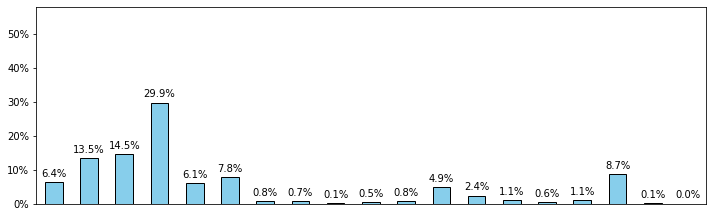

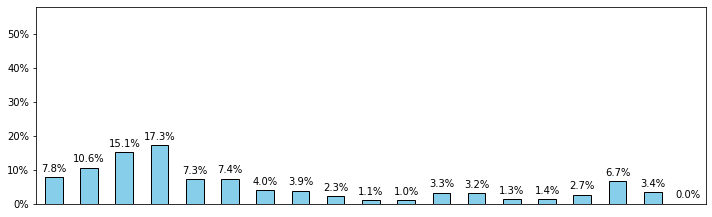

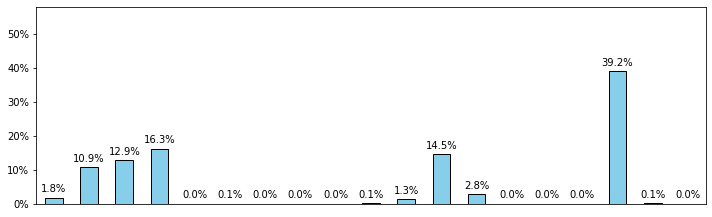

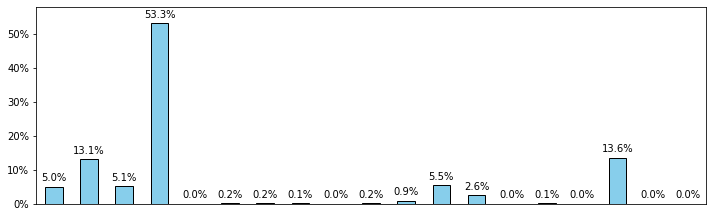

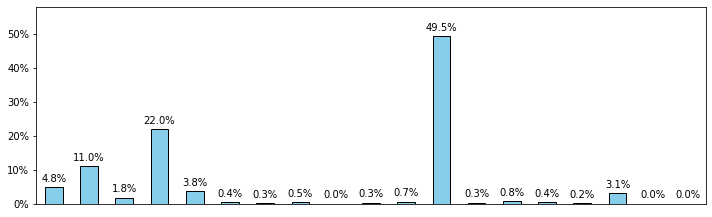

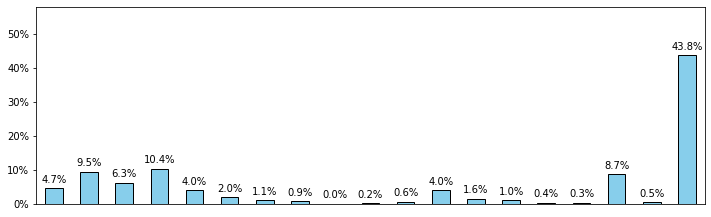

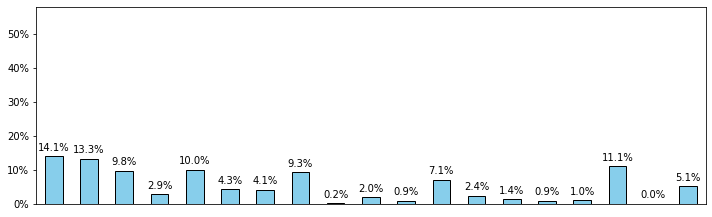

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

proportion_data = {}
for mod, prop in props.items():
    proportions = prop['group'].value_counts(normalize=True).reindex(celltype_order, fill_value=0)
    proportion_data[mod] = proportions

# fig, axes = plt.subplots(1, len(series_list), figsize=(15, 5), sharey=True)
for mod, prop in proportion_data.items():
    save_dir = f'/home/acollin/scPermut/analysis_notebooks/figures/task_4/proportion_barplot/lv3_transfer/'
    check_dir(save_dir)
    plt.figure(figsize=(10, 5))
    bars = prop.plot(kind='bar', color='skyblue', edgecolor="black")
    plt.ylim(0,0.58)
    plt.title(aestetic_model_name[mod])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    for bar in bars.containers[0]:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f'{height:.1%}',  # Convertit en pourcentage
            ha='center',
            va='bottom'
        )
    plt.tight_layout()
    plt.savefig(save_dir + mod + '.png')
    # ax.set_title(f"Série {i+1}")
    # ax.set_xlabel("Catégories")
    # ax.set_ylabel("Proportion")

    plt.title('')
    # plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.savefig(save_dir + mod + '_pruned.png')
# plt.suptitle("Barplots des proportions par série avec toutes les catégories")
plt.show()


# Figure 7 - Composition of spatial locations

In [15]:
adata = load_dataset(dataset_name, working_dir + 'data/')

dataset loaded at /home/acollin/scPermut/data//tenx_hlca_par_cell.h5ad
AnnData object with n_obs × n_vars = 613127 × 390
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_g

In [16]:
lv3_id = runs_table_df.query(f"dataset_name == '{dataset_name}'").query('class_key == "ann_level_3"')[['sys_id', 'model', 'training_scheme']]

In [17]:
lv3_id = lv3_id[lv3_id.fillna(0)['training_scheme'].isin([0,'training_scheme_8'])]
lv3_id = lv3_id.loc[lv3_id['model'] != 'uce']

In [18]:
spas = {model : load_spatial(sysid, adata) for sysid, model in zip(lv3_id['sys_id'], lv3_id['model'])}

In [19]:
spatial_loc_dir = working_dir + '/analysis_notebooks/spatial_loc/'

In [20]:
spatial_loc = {p.rstrip('.csv') : pd.read_csv(spatial_loc_dir + p) for p in os.listdir(spatial_loc_dir) if p.endswith('.csv')}

In [21]:
celltype_order = ['AT1','AT2', 'EC capillary' ,'Fibroblasts', 'Smooth muscle',
                   'EC arterial', 'EC venous', 'Lymphatic EC mature', 
                  'Basal', 'Secretory','Multiciliated lineage',
               'Macrophages','Monocytes', 'Mast cells', 'B cell lineage', 'Dendritic cells', 'T cell lineage',              
               'Innate lymphoid cell NK', 'Unassigned']

## Plot comp per region 

In [ ]:
adata

In [ ]:
comp_mat ={}
for spa_loc,cell_id in spatial_loc.items():
    spa_id = cell_id['Cell ID']
    comp_mat[spa_loc] = pd.concat([pd.Series(ad.obs.loc[ad.obs['cell_id'].isin(spa_id),'pred'], name = model) for model, ad in spas.items()], axis =1)

In [ ]:
import pandas as pd

def plot_comp(df, ct_order, title= None, **kwargs):
    save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/spatial_composition/lv3_transfer_loc/'
    check_dir(save_path)
    plt.figure(figsize=(8, 6))
    df_long = pd.melt(df, var_name='model', value_name='celltype')
    
    summary_df = df_long.groupby(['model', 'celltype']).size().unstack(fill_value=0)
    ct_order = [i for i in ct_order if i in summary_df.columns]
    summary_df = summary_df.loc[:,ct_order]
    sns.heatmap(summary_df.transpose(),cmap = 'Blues',  **kwargs)
    plt.title(title)
    plt.tight_layout()
# training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
    plt.savefig(save_path + title + '.png', transparent=False)

In [ ]:
for loc in np.sort(list(comp_mat.keys())):
    mat = comp_mat[loc]
    mat = mat.loc[:, mat.columns !='pca_knn']
    mat = mat.rename(columns = aestetic_model_name).sort_index(axis = 1)
    plot_comp(mat, ct_order = celltype_order, title = loc)

## Plot comp per model across regions

### Figure 7 - With boxplot

In [33]:
celltype_order = ['AT1','AT2', 'EC capillary' ,'Fibroblasts', 'Smooth muscle',
                   'EC arterial', 'EC venous', 'Lymphatic EC mature', 
                  'Basal', 'Secretory','Multiciliated lineage',
               'Macrophages','Monocytes', 'Mast cells', 'B cell lineage', 'Dendritic cells', 'T cell lineage',              
               'Innate lymphoid cell NK']
region_order = ['alv_1', 'alv_2', 'alv_3', 'alv_4', 'art_1', 'art_2', 'art_3', 'bronc_1', 'bronc_2', 'bronc_3', 'bronc_4']

In [23]:
comp_mat ={}
for spa_loc,cell_id in spatial_loc.items():
    spa_id = cell_id['Cell ID']
    comp_mat[spa_loc] = pd.concat([pd.Series(ad.obs.loc[ad.obs['cell_id'].isin(spa_id),'pred'], name = model) for model, ad in spas.items()], axis =1)

In [25]:
from matplotlib.ticker import PercentFormatter

/tmp/ipykernel_130859/712719539.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


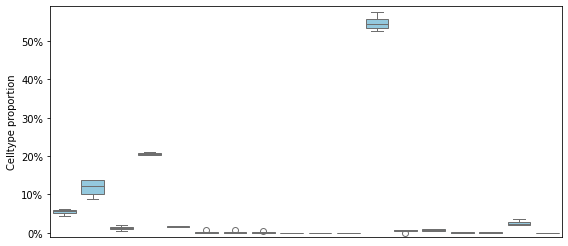

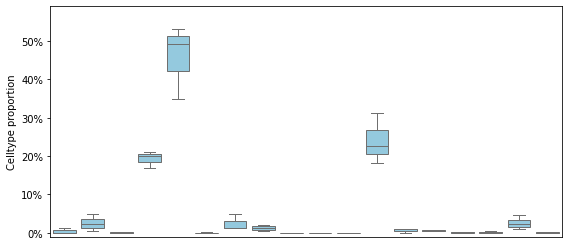

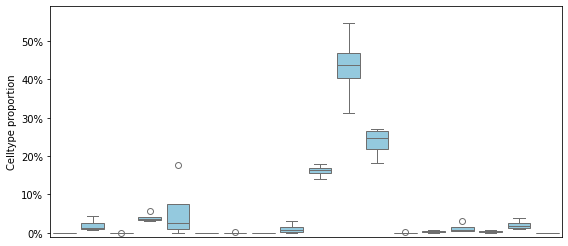

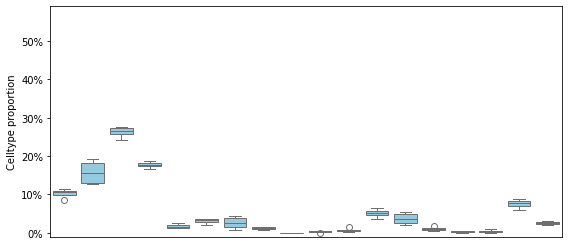

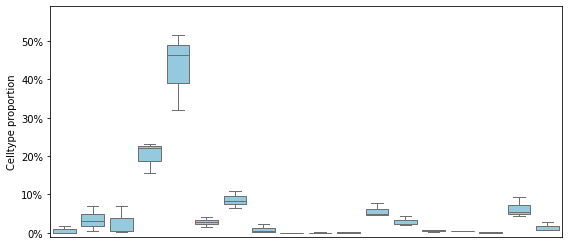

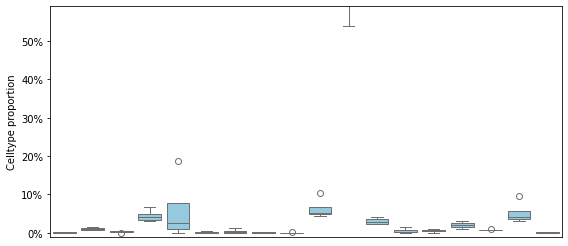

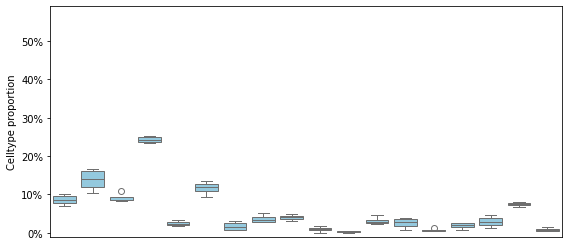

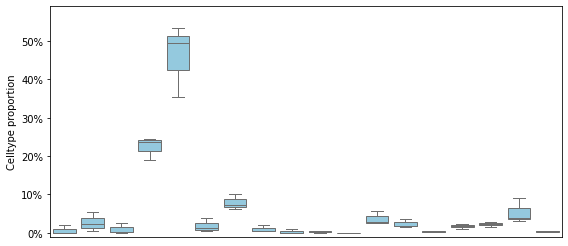

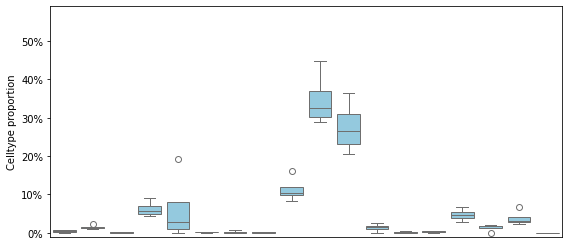

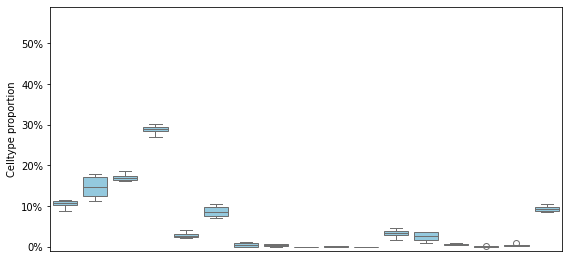

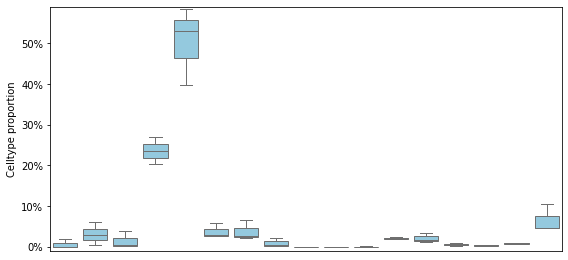

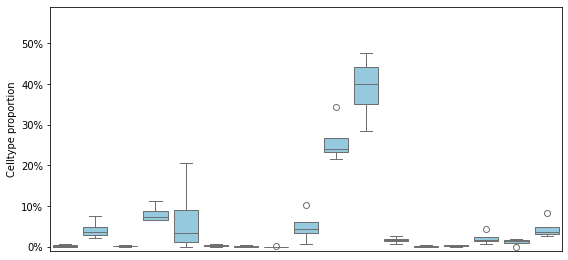

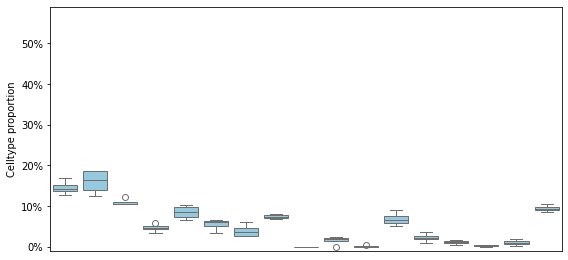

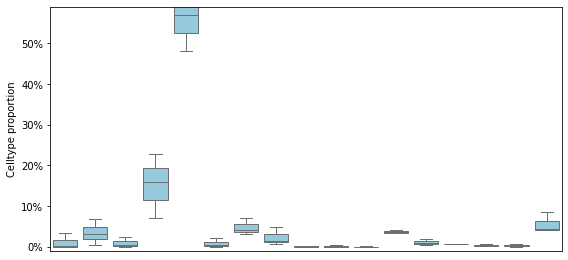

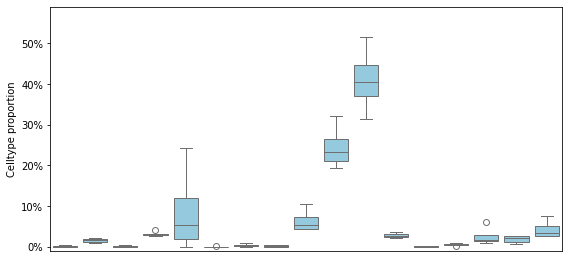

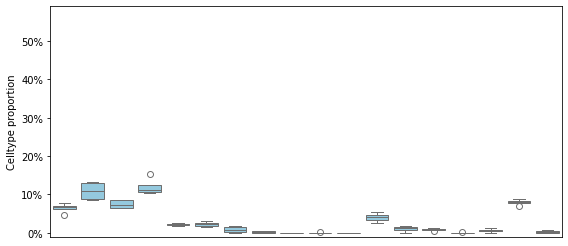

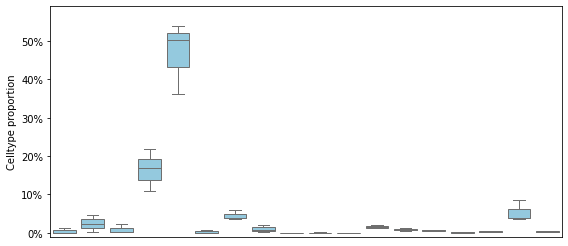

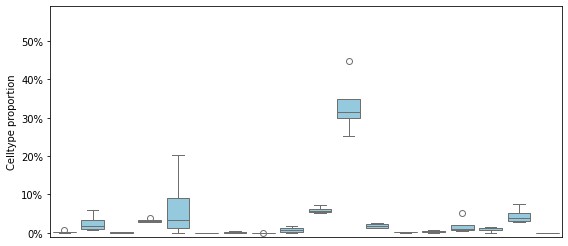

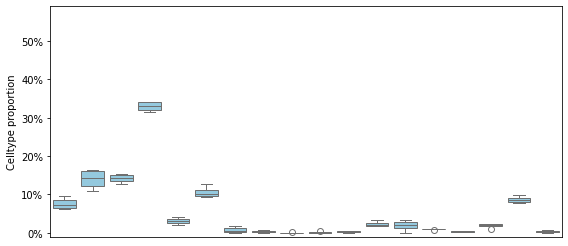

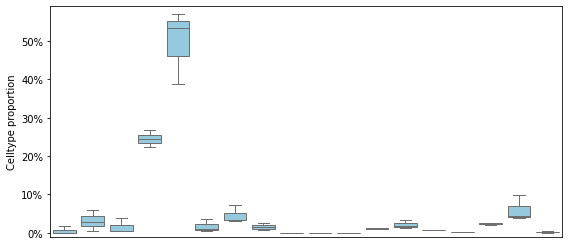

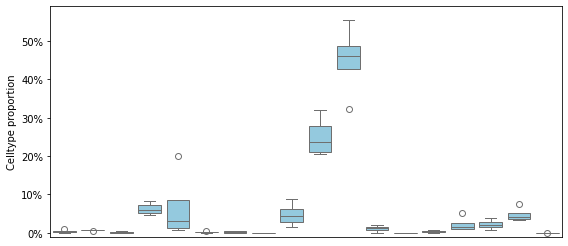

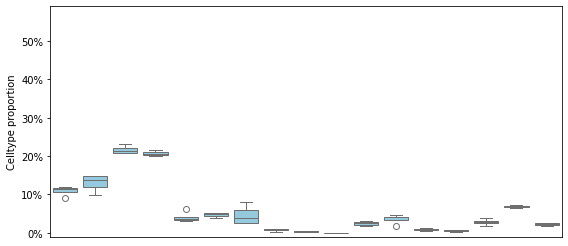

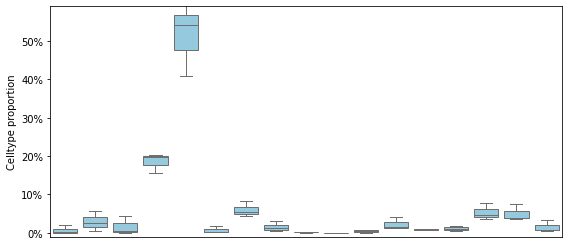

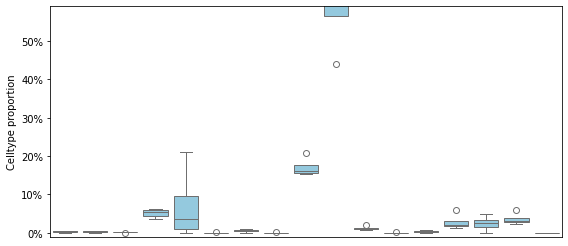

In [31]:

for mod, ad in spas.items():
    to_conc = []
    save_path = f'/home/acollin/scPermut/analysis_notebooks/figures/task_4/spatial_composition/lv3_transfer_model/{mod}/'
    check_dir(save_path)

    for spa_loc,cell_id in spatial_loc.items():
        spa_id = cell_id['Cell ID']
        to_conc.append(pd.Series(ad[ad.obs['cell_id'].isin(spa_id)].obs['pred']).value_counts().rename(spa_loc))
    comp_mat = pd.concat(to_conc, axis = 1).fillna(0)
    comp_mat_norm = pd.DataFrame(np.array(comp_mat) / np.array(comp_mat).sum(axis = 0, keepdims=True), 
                                   index = comp_mat.index, 
                                   columns = comp_mat.columns)
    ct_order = [i for i in celltype_order if i in comp_mat_norm.index]
    comp_mat_norm = comp_mat_norm.loc[ct_order,region_order]

    comp_mat_norm['celltype'] = comp_mat_norm.index

    melted = pd.melt(comp_mat_norm, id_vars = 'celltype')
    melted['niche'] = melted['variable'].replace({'alv_1' : 'Alveolar','alv_1' : 'Alveolar',
                                                  'alv_2' : 'Alveolar',
                                                 'alv_3' : 'Alveolar',
                                                 'alv_4' : 'Alveolar',
                                                 'art_1' : 'Vascular',
                                                 'art_2' : 'Vascular',
                                                 'art_3' : 'Vascular',
                                                 'bronc_1' : 'Bronchial',
                                                 'bronc_2' : 'Bronchial',
                                                 'bronc_3' : 'Bronchial',
                                                 'bronc_4' : 'Bronchial',})
    for reg in melted['niche'].unique():
        toplot = melted.loc[melted['niche'] == reg,:]
        plt.figure(figsize=(8, 6))
        ax = sns.boxplot(toplot, x = 'celltype', y = 'value', color = "skyblue")
        ax.set_ylim(-0.01,0.59)
        plt.xticks(rotation=90, fontsize = 12)
        ax.set_title(f'{mod} - {reg}')
        ax.set_ylabel('Celltype proportion')
        
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

        plt.tight_layout()
        plt.savefig(save_path + f'{mod} - {reg}' + '.png', transparent=False)
    # training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
        ax.set_title('')
    # plt.gca().axes.xaxis.set_ticklabels([])
        ax.axes.get_xaxis().set_visible(False)
        plt.savefig(save_path + f'{mod} - {reg}' + '_pruned.png')


### With heatmaps (NOT IN PAPER)

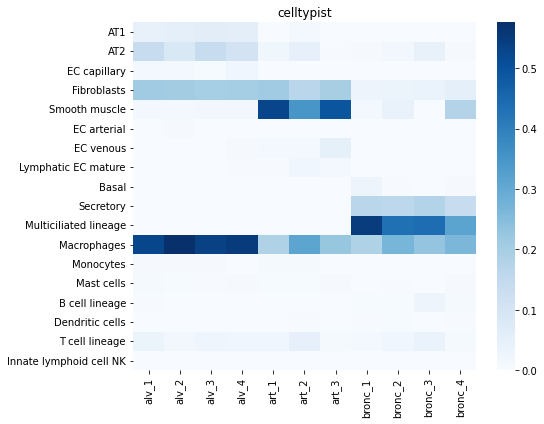

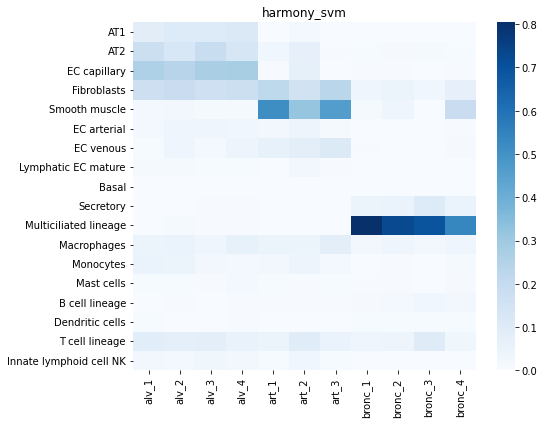

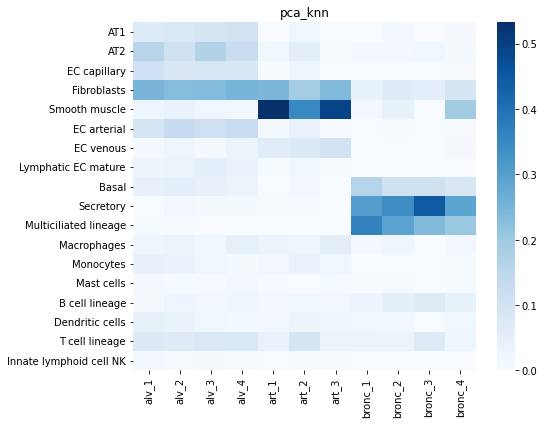

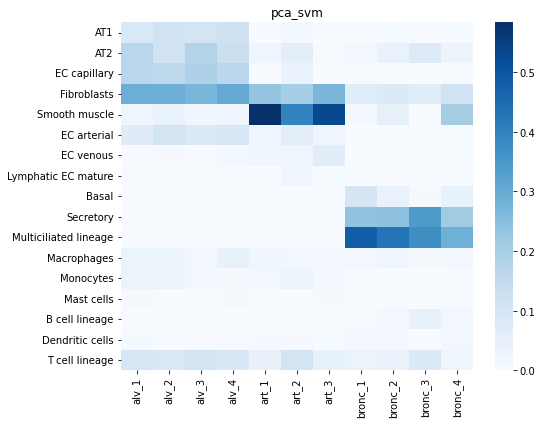

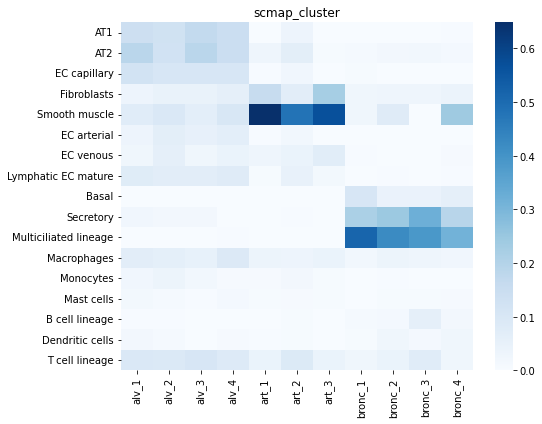

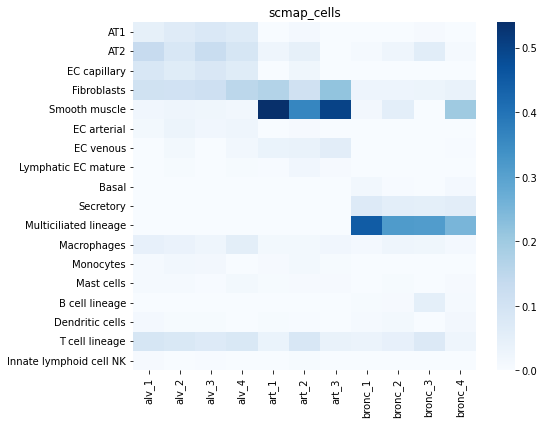

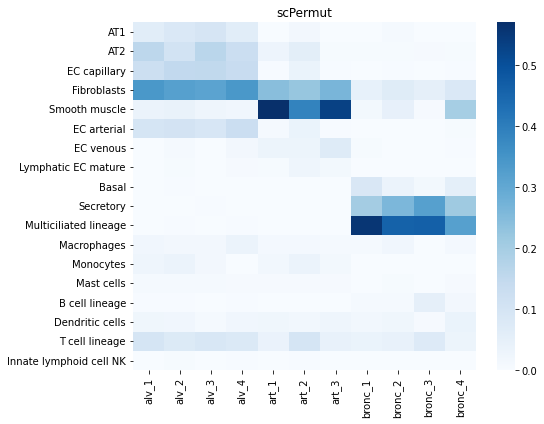

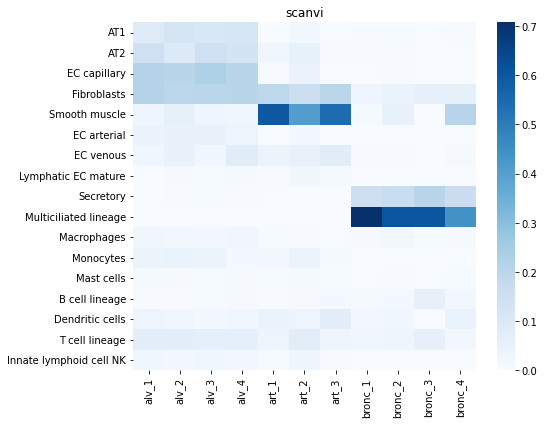

In [23]:

for mod, ad in spas.items():
    to_conc = []
    save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/spatial_composition/lv3_transfer_model/'
    check_dir(save_path)

    for spa_loc,cell_id in spatial_loc.items():
        spa_id = cell_id['Cell ID']
        to_conc.append(pd.Series(ad[ad.obs['cell_id'].isin(spa_id)].obs['pred']).value_counts().rename(spa_loc))
    comp_mat = pd.concat(to_conc, axis = 1).fillna(0)
    comp_mat_norm = pd.DataFrame(np.array(comp_mat) / np.array(comp_mat).sum(axis = 0, keepdims=True), 
                                   index = comp_mat.index, 
                                   columns = comp_mat.columns)
    ct_order = [i for i in celltype_order if i in comp_mat_norm.index]
    comp_mat_norm = comp_mat_norm.loc[ct_order,region_order]
    plt.figure(figsize=(8, 6))
    sns.heatmap(comp_mat_norm, cmap ='Blues')
    plt.title(mod)
    plt.tight_layout()
    plt.savefig(save_path + mod + '.png', transparent=False)
    # training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']


In [27]:
spa_scanvi = adata[adata.obs['dataset'] == 'spatial']

                          bronc_3     alv_1     alv_4     alv_3   bronc_1  \
Multiciliated lineage    0.522388  0.000000  0.004255  0.001855  0.582624   
Secretory                0.216418  0.009324  0.000000  0.005566  0.163543   
Basal                    0.082090  0.016317  0.029787  0.025974  0.127768   
B cell lineage           0.067164  0.004662  0.008511  0.007421  0.013629   
Fibroblasts              0.052239  0.179487  0.165957  0.178108  0.028961   
T cell lineage           0.052239  0.065268  0.059574  0.063080  0.028961   
Innate lymphoid cell NK  0.007463  0.034965  0.034043  0.046382  0.001704   
EC capillary             0.000000  0.188811  0.195745  0.192950  0.001704   
AT2                      0.000000  0.139860  0.114894  0.142857  0.000000   
AT1                      0.000000  0.074592  0.093617  0.089054  0.000000   
EC arterial              0.000000  0.065268  0.051064  0.077922  0.001704   
Smooth muscle            0.000000  0.060606  0.063830  0.051948  0.015332   

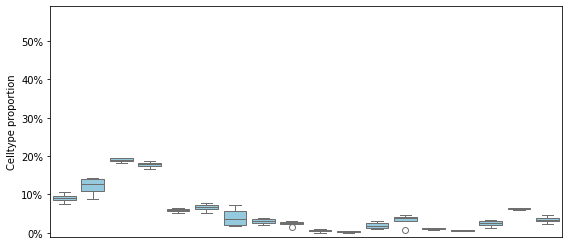

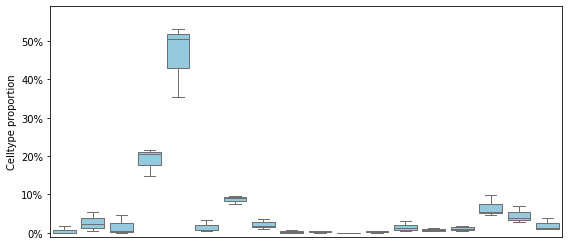

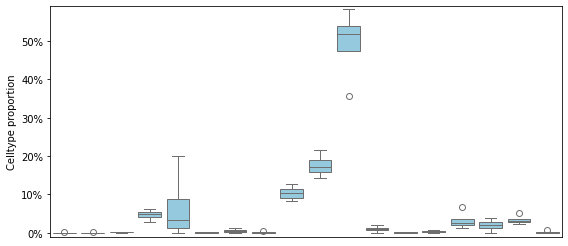

In [43]:
mod = 'scanvi'
ad = spa_scanvi
to_conc = []
save_path = '/home/acollin/scPermut/analysis_notebooks/figures/task_4/spatial_composition/lv3_transfer_model/scanvi/'
check_dir(save_path)


for spa_loc,cell_id in spatial_loc.items():
    spa_id = cell_id['Cell ID']
    to_conc.append(pd.Series(ad[ad.obs['cell_id'].isin(spa_id)].obs['scanvi_pred']).value_counts().rename(spa_loc))
comp_mat = pd.concat(to_conc, axis = 1).fillna(0)
comp_mat_norm = pd.DataFrame(np.array(comp_mat) / np.array(comp_mat).sum(axis = 0, keepdims=True), 
                               index = comp_mat.index, 
                               columns = comp_mat.columns)

ct_order = [i for i in celltype_order if i in comp_mat_norm.index]

comp_mat_norm = comp_mat_norm.loc[ct_order,region_order]
comp_mat_norm['celltype'] = comp_mat_norm.index

melted = pd.melt(comp_mat_norm, id_vars = 'celltype')
melted['niche'] = melted['variable'].replace({'alv_1' : 'Alveolar','alv_1' : 'Alveolar',
                                              'alv_2' : 'Alveolar',
                                             'alv_3' : 'Alveolar',
                                             'alv_4' : 'Alveolar',
                                             'art_1' : 'Vascular',
                                             'art_2' : 'Vascular',
                                             'art_3' : 'Vascular',
                                             'bronc_1' : 'Bronchial',
                                             'bronc_2' : 'Bronchial',
                                             'bronc_3' : 'Bronchial',
                                             'bronc_4' : 'Bronchial',})
for reg in melted['niche'].unique():
    toplot = melted.loc[melted['niche'] == reg,:]
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(toplot, x = 'celltype', y = 'value', color = "skyblue")
    ax.set_ylim(-0.01,0.59)
    plt.xticks(rotation=90, fontsize = 12)
    ax.set_title(f'{mod} - {reg}')
    ax.set_ylabel('Celltype proportion')
    
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

    plt.tight_layout()
    plt.savefig(save_path + f'{mod} - {reg}' + '.png', transparent=False)
# training_scheme = runs_table_df.query(f"sys_id == '{sysid}'")['training_scheme']
    ax.set_title('')
# plt.gca().axes.xaxis.set_ticklabels([])
    ax.axes.get_xaxis().set_visible(False)
    plt.savefig(save_path + f'{mod} - {reg}' + '_pruned.png')

In [ ]:
comp_mat = pd.concat(to_conc, axis = 1).fillna(0)

In [ ]:
comp_mat_norm = pd.DataFrame(np.array(comp_mat) / np.array(comp_mat).sum(axis = 0, keepdims=True), 
                               index = comp_mat.index, 
                               columns = comp_mat.columns)
comp_mat_norm = comp_mat_norm.loc[celltype_order,region_order]

In [ ]:
sns.heatmap(comp_mat_norm, cmap ='Blues')